# Classifier tuning for ACM ASIACC paper

## Loading data and selecting features of interest

In [11]:
import pyarrow as pa
import pyarrow.parquet as pq

#phishing = pq.read_table('floor/phishing_2307.parquet')
phishing = pq.read_table('floor/phishing_2311.parquet')
benign = pq.read_table('floor/benign_2310.parquet')

from transformers.drop_nontrain import drop_nontrain_table as drop_nontrain
phishing = drop_nontrain(phishing)
benign = drop_nontrain(benign)

# realign schemas (parquet files save in nonsense orders)
benign = benign.cast(phishing.schema)

# concatentate tables
data = pa.concat_tables([phishing, benign])
df = data.to_pandas()

print(f"Total records: {len(df)}")

from transformers.cast_timestamp import cast_timestamp
df = cast_timestamp(df)

used_features = [

    # IP  ===============================
    # Used in the original NOMS paper
    "ip_mean_average_rtt",
    "ip_entropy",
    "ip_count",
    #"ip_v4_count", "ip_v6_count", # Moved RDAP and RENAMED to rdap_ip
    
    # Newly added for ACM ASIACCS
    "ip_v4_ratio",
    #"ip_a_aaaa_to_all_ratio", <--- not useful for this dataset
    "ip_as_address_entropy",
    "ip_asn_entropy",
    "ip_distinct_as_count",
    
    # DNS  ===============================
    # Used in the original NOMS paper
    "dns_A_count",
    "dns_AAAA_count",
    "dns_MX_count",
    "dns_NS_count",
    #"dns_SOA_count", <-- REMOVED, very low effect -------------------------------------
    "dns_TXT_count",
    "dns_CNAME_count",
    "dns_soa_primary_ns_len",
    "dns_soa_primary_ns_level", # renamed
    "dns_soa_primary_ns_digit_count",
    "dns_soa_primary_ns_entropy",
    "dns_soa_email_len",
    "dns_soa_email_level", # renamed
    "dns_soa_email_digit_count",
    "dns_soa_email_entropy",
    # "dns_soa_serial", <-- Doesn't convey any kind of comparative information
    "dns_soa_refresh",
    "dns_soa_retry",
    "dns_soa_expire",
    "dns_mx_avg_len",
    "dns_mx_avg_entropy",
    "dns_domain_name_in_mx",
    "dns_txt_spf_exists",
    "dns_txt_avg_entropy",
    "dns_txt_dkim_exists",
    
    "dns_zone_level",
    "dns_zone_digit_count",
    "dns_zone_len",
    "dns_zone_entropy",
    
    # Newly added for ACM ASIACCS
    "dns_resolved_record_types",
    "dns_has_dnskey",
    "dns_dnssec_score",
    "dns_ttl_avg",
    "dns_ttl_stdev",
    "dns_ttl_low",
    "dns_ttl_mid",
    "dns_ttl_distinct_count",
    "dns_soa_min_ttl", # why is this not in NOMS?!
    "dns_txt_external_verification_score",
    "dns_txt_dmarc_exists",
    
    
    # TLS  ===============================
    # Used in the original NOMS paper
    "tls_broken_chain",
    "tls_expired_chain",
    "tls_is_self_signed", # <--- NEW (23-12-02)
    "tls_root_authority_hash", # <--- NEW (23-12-02)
    "tls_leaf_authority_hash", # <--- NEW (23-12-02)
    "tls_total_extension_count",
    "tls_critical_extensions",
    "tls_with_policies_crt_count",
    "tls_percentage_crt_with_policies",
    "tls_x509_anypolicy_crt_count",
    "tls_iso_policy_crt_count",
    "tls_joint_isoitu_policy_crt_count",
    # "tls_iso_policy_oid", <-- Basically a random value, doesn't make much sense when collected like this; policy OIDs need more research
    # "tls_isoitu_policy_oid", <-- same
    #"tls_unknown_policy_crt_count", <-- Abandoned, no useful values
    "tls_root_cert_validity_len",
    "tls_leaf_cert_validity_len",
    "tls_chain_len",
    #"tls_root_cert_lifetime", <---- NO!
    #"tls_leaf_cert_lifetime", <---- NO!
    "tls_subject_count",
    "tls_unique_SLD_count",
    "tls_server_auth_crt_count",
    "tls_client_auth_crt_count",
    "tls_CA_certs_in_chain_ratio",
    "tls_common_name_count",
    
    # Newly added for ACM ASIACCS
    #"tls_has_tls", , <-- REMOVED, very low effect -------------------------------------
    "tls_negotiated_version_id",
    "tls_negotiated_cipher_id",
    
    # LEX ===============================
    # Used in the original NOMS paper
    "lex_name_len",
    #"lex_digit_count", <-- abandoned, almost the same as "lex_sub_digit_ratio"
    "lex_has_digit",
    "lex_phishing_keyword_count",
    #"lex_vowel_count", <-- moved to sub
    #"lex_underscore_hyphen_count", <--- same as nonalnum
    "lex_consecutive_chars",
    "lex_tld_len",
    "lex_tld_abuse_score", # *************************************************************
    "lex_tld_hash", # *************************************************************
    
    "lex_sld_len",
    "lex_sld_norm_entropy", # <-- newly added feature on 23-09-29
    # ============================= New SLD features 23-11
    "lex_sld_phishing_keyword_count",
    #"lex_sld_digit_count",
    #"lex_sld_digit_ratio",
    "lex_sld_vowel_count",
    "lex_sld_vowel_ratio",
    "lex_sld_consonant_count",
    "lex_sld_consonant_ratio",
    "lex_sld_non_alphanum_count",
    "lex_sld_non_alphanum_ratio",
    "lex_sld_hex_count",
    "lex_sld_hex_ratio",
    # =============================      
    
    "lex_sub_count",
    "lex_stld_unique_char_count",
    "lex_begins_with_digit",
    "lex_www_flag",
    "lex_sub_max_consonant_len",
    "lex_sub_norm_entropy",
    "lex_sub_digit_count",
    "lex_sub_digit_ratio",
    "lex_sub_consonant_ratio",
    "lex_sub_non_alphanum_ratio",
    "lex_sub_hex_ratio",

    #"lex_bigram_matches",  # OLD NAME
    #"lex_trigram_matches", # OLD NAME
    "lex_phishing_bigram_matches",  # NEW NAME
    "lex_phishing_trigram_matches", # NEW NAME
    "lex_phishing_tetragram_matches", # *************************************************************
    "lex_phishing_pentagram_matches", # *************************************************************
    "lex_sub_vowel_count",
    "lex_sub_vowel_ratio",
    "lex_sub_consonant_count",
    "lex_sub_non_alphanum_count",
    "lex_sub_hex_count",
    "lex_avg_part_len",
    "lex_stdev_part_lens",
    "lex_longest_part_len",
    "lex_shortest_sub_len",
    
    # RDAP ===============================
    # Used in the original NOMS paper
    "rdap_registration_period",
    "rdap_domain_age",
    "rdap_time_from_last_change",
    "rdap_domain_active_time",
    "rdap_has_dnssec",
    "rdap_ip_v4_count", "rdap_ip_v6_count", # <-- used for NOMS, but now prefixed with rdap_
    
    # Newly added for ACM ASIACCS
    "rdap_registrar_name_len",
    "rdap_registrar_name_entropy",
    "rdap_registrar_name_hash",
    "rdap_registrant_name_len",
    "rdap_registrant_name_entropy",
    "rdap_admin_name_len",
    "rdap_admin_name_entropy",
    "rdap_admin_email_len",
    "rdap_admin_email_entropy",
    
    "rdap_ip_shortest_v4_prefix_len",
    "rdap_ip_longest_v4_prefix_len",
    "rdap_ip_shortest_v6_prefix_len",
    "rdap_ip_longest_v6_prefix_len",
    
    "rdap_ip_avg_admin_name_len",
    "rdap_ip_avg_admin_name_entropy",
    "rdap_ip_avg_admin_email_len",
    "rdap_ip_avg_admin_email_entropy",
    
    # GEO ===============================
    # Used in the original NOMS paper
    "geo_countries_count",
    "geo_continent_hash",
    "geo_countries_hash",
    
    # Newly added for ACM ASIACCS
    "geo_lat_stdev", # <- Puvodne to pridal Adam, ale pak jsme dali pryc, ze to budem resit jinak.
    "geo_lon_stdev",  #    Ale muze byt helpful pro identifikaci, jestli lokality jsou blizko sebe.    
    #"geo_min_lat", # not very useful
    #"geo_max_lat", # not very useful
    #"geo_min_lon", # not very useful
    #"geo_max_lon", # not very useful
    "geo_mean_lat", # *************************************************************
    "geo_mean_lon", # *************************************************************
    #"geo_lat_range", # not very useful
    #"geo_lon_range", # not very useful
    "geo_centroid_lat", # *************************************************************
    "geo_centroid_lon", # *************************************************************
    #"geo_estimated_area",  # not very useful 
]


print("Number of used features: " + str(len(used_features)))

# NUMBER OF AVAILABLE AND UNUSED FEATURES
missing_columns = set(df.columns) - set(used_features) - set(["label"])
print("No. of available unused features: " + str(len(missing_columns)))

df = df[["label", *used_features]]


Total records: 500925
Number of used features: 143
No. of available unused features: 34


In [12]:
df

label  ip_mean_average_rtt  ip_entropy  ip_count  \
0        misp_2310:phishing             0.000000   -0.000000         1   
1        misp_2310:phishing            -1.000000   -0.000000         0   
2        misp_2310:phishing             0.000000   -0.000000         1   
3        misp_2310:phishing            -1.000000   -0.000000         0   
4        misp_2310:phishing            -1.000000   -0.000000         0   
...                     ...                  ...         ...       ...   
500920  benign_2310:unknown            43.488625    4.240224        16   
500921  benign_2310:unknown             3.996786    4.186138        14   
500922  benign_2310:unknown             4.329750    4.000000        12   
500923  benign_2310:unknown            16.280900    4.643856        10   
500924  benign_2310:unknown            12.666600    2.918296        10   

        ip_v4_ratio  ip_as_address_entropy  ip_asn_entropy  \
0               1.0              -0.000000       -0.000000   
1               0.0                    NaN             NaN   
2               1.0              -0.000000       -0.000000   
3               0.0                    NaN             NaN   
4               0.0                    NaN             NaN   
...             ...                    ...             ...   
500920          1.0               4.106891        1.061278   
500921          0.5               3.900424        0.734530   
500922          1.0               2.000000       -0.000000   
500923          0.5               3.043856        0.721928   
500924          1.0               3.918296        1.760964   

        ip_distinct_as_count  dns_A_count  dns_AAAA_count  ...  \
0                        1.0            1               0  ...   
1                        NaN            0               0  ...   
2                        1.0            1               0  ...   
3                        NaN            0               0  ...   
4                        NaN            0               0  ...   
...                      ...          ...             ...  ...   
500920                   3.0            2               0  ...   
500921                   3.0            1               1  ...   
500922                   1.0            2               0  ...   
500923                   2.0            1               1  ...   
500924                   4.0            1               0  ...   

        rdap_ip_avg_admin_email_entropy  geo_countries_count  \
0                              0.000000                    1   
1                              0.000000                    0   
2                              0.000000                    1   
3                              0.000000                    0   
4                              0.000000                    0   
...                                 ...                  ...   
500920                         0.157633                    1   
500921                         0.190507                    1   
500922                         0.149881                    1   
500923                         0.179189                    1   
500924                         0.105152                    1   

        geo_continent_hash  geo_countries_hash  geo_lat_stdev  geo_lon_stdev  \
0                        3                 184        0.00000         0.0000   
1                        0                   0        0.00000         0.0000   
2                        0                 144        0.00000         0.0000   
3                        0                   0        0.00000         0.0000   
4                        0                   0        0.00000         0.0000   
...                    ...                 ...            ...            ...   
500920                   1                 187        0.00000         0.0000   
500921                   1                 187        0.00000         0.0000   
500922                   5                  86        0.00000         0.0000   
500923                   3

## Subsampling entire dataset (only for testing/tuning purposes)

In [13]:
subsample = 1.0 # 1.0 means no subsample

if subsample < 1.0:
    df = df.sample(frac=subsample)

## Supressing unwanted warnings (futures etc.)

In [14]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, module='sklearn.*')
warnings.filterwarnings('ignore', category=FutureWarning, module='xgboost.*')
warnings.filterwarnings('ignore', message="Series.__getitem__ treating keys as positions is deprecated.*")

## Shortening feature names (for paper purposes)

In [15]:
shortening = {
    "lex_stld_unique_char_count": "lex_stld_uniq_char_cnt",
    "lex_sub_max_consonant_len": "lex_max_conson_len",
    "lex_sub_non_alphanum_count": "lex_sub_nonalnum_count",
    "lex_sub_non_alphanum_ratio": "lex_sub_nonalnum_ratio",
    "lex_phishing_keyword_count": "lex_phishing_kw_count",
    "lex_sld_phishing_keyword_count": "lex_sld_phishing_kw_count",
    
    "dns_resolved_record_types": "dns_resolved_rec_types",
    "dns_domain_name_in_mx": "dns_dn_in_mx",
    "dns_txt_external_verification_score": "dns_txt_ext_verif_score",
    "dns_zone_digit_count": "dns_zone_digits",
    "dns_soa_primary_ns_digit_count": "dns_soa_prim_ns_digits",
    "dns_soa_primary_ns_len" : "dns_soa_pri_ns_len",
    "dns_soa_primary_ns_level": "dns_soa_pri_ns_level",
    "dns_soa_primary_ns_entropy": "dns_soa_pri_ns_entropy",
    "dns_soa_email_digit_count": "dns_soa_email_digits",
    
    "tls_percentage_crt_with_policies": "tls_percentage_with_policies",
    "tls_x509_anypolicy_crt_count": "tls_x509_anypol_crt_count",
    "tls_iso_policy_crt_count": "tls_iso_pol_crt_count",
    "tls_joint_isoitu_policy_crt_count": "tls_isoitu_pol_crt_count",
    
    "rdap_ip_avg_admin_name_entropy": "rdap_ip_avg_admin_name_ent",
    "rdap_ip_avg_admin_email_entropy": "rdap_ip_avg_admin_email_ent"
}

df.rename(columns=shortening, inplace=True)

df

label  ip_mean_average_rtt  ip_entropy  ip_count  \
0        misp_2310:phishing             0.000000   -0.000000         1   
1        misp_2310:phishing            -1.000000   -0.000000         0   
2        misp_2310:phishing             0.000000   -0.000000         1   
3        misp_2310:phishing            -1.000000   -0.000000         0   
4        misp_2310:phishing            -1.000000   -0.000000         0   
...                     ...                  ...         ...       ...   
500920  benign_2310:unknown            43.488625    4.240224        16   
500921  benign_2310:unknown             3.996786    4.186138        14   
500922  benign_2310:unknown             4.329750    4.000000        12   
500923  benign_2310:unknown            16.280900    4.643856        10   
500924  benign_2310:unknown            12.666600    2.918296        10   

        ip_v4_ratio  ip_as_address_entropy  ip_asn_entropy  \
0               1.0              -0.000000       -0.000000   
1               0.0                    NaN             NaN   
2               1.0              -0.000000       -0.000000   
3               0.0                    NaN             NaN   
4               0.0                    NaN             NaN   
...             ...                    ...             ...   
500920          1.0               4.106891        1.061278   
500921          0.5               3.900424        0.734530   
500922          1.0               2.000000       -0.000000   
500923          0.5               3.043856        0.721928   
500924          1.0               3.918296        1.760964   

        ip_distinct_as_count  dns_A_count  dns_AAAA_count  ...  \
0                        1.0            1               0  ...   
1                        NaN            0               0  ...   
2                        1.0            1               0  ...   
3                        NaN            0               0  ...   
4                        NaN            0               0  ...   
...                      ...          ...             ...  ...   
500920                   3.0            2               0  ...   
500921                   3.0            1               1  ...   
500922                   1.0            2               0  ...   
500923                   2.0            1               1  ...   
500924                   4.0            1               0  ...   

        rdap_ip_avg_admin_email_ent  geo_countries_count  geo_continent_hash  \
0                          0.000000                    1                   3   
1                          0.000000                    0                   0   
2                          0.000000                    1                   0   
3                          0.000000                    0                   0   
4                          0.000000                    0                   0   
...                             ...                  ...                 ...   
500920                     0.157633                    1                   1   
500921                     0.190507                    1                   1   
500922                     0.149881                    1                   5   
500923                     0.179189                    1                   3   
500924                     0.105152                    1                   1   

        geo_countries_hash  geo_lat_stdev  geo_lon_stdev  geo_mean_lat  \
0                      184        0.00000         0.0000      50.45220   
1                        0        0.00000         0.0000       0.00000   
2                      144        0.00000         0.0000      55.73860   
3                        0        0.00000         0.0000       0.00000   
4                        0        0.00000         0.0000       0.00000   
...                    ...            ...            ...           ...   
500920                 187        0.00000         0.0000      37.75100   
500921                 187        0.00000 

# NaNs will be replaced by -1 (best results)

In [16]:
# Handle NaNs
df.fillna(-1, inplace=True)

# Train-Test Split

In [17]:
from config import Config
from sklearn.model_selection import train_test_split

class_map = {"benign_2310:unknown": 0, "misp_2310:phishing": 1}

labels = df['label'].apply(lambda x: class_map[x]) # y vector
features = df.drop('label', axis=1).copy() # X matrix

X_train, X_test, y_train, y_test = train_test_split(
  features,
  labels,
  test_size=0.3,
  random_state=42,
  shuffle=True, 
  stratify=labels
)

## Custom tuning metric

Allow for setting weights for **Precision, F1, FPR, logloss** and **Overfitting** (difference between train and test scores).
* If you want to use it, the **scoring** should be set to **FETA_Score** on hyperparameter tuning.
* Otherwise, you can set **scoring** to metric you want: **neg_log_loss**, **precision**, **f1**, etc.

In [36]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, log_loss

def FETA_Score(estimator, X, y):
    # Getting predictions
    y_pred = estimator.predict(X)
    y_pred_proba = estimator.predict_proba(X)
    
    # Calculating precision
    precision = precision_score(y, y_pred)
    
    # Calculating recall
    recall = recall_score(y, y_pred)
    
    # Calculating F1-score
    f1 = f1_score(y, y_pred)
    
    # Calculating FPR
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    
    # Calculating Log Loss
    logloss = log_loss(y, y_pred_proba)
    
    # Estimating overfitting
    train_score = estimator.score(X_train, y_train) 
    validation_score = estimator.score(X, y) 
    overfitting = train_score - validation_score
    
    # Assigning weights
    w_precision = 0.1     # Precision
    w_recall = 0.2        # Recall
    w_f1 = 0.6            # F1
    w_fpr = -0.0          # Negative because lower FPR is better
    w_logloss = -0.0      # Negative because lower log loss is better
    w_overfitting = -0.1  # Negative because lower overfitting is better
    
    #w_precision = 0.0     # Precision
    #w_recall = 0.5        # Recall
    #w_f1 = 0.5            # F1
    #w_fpr = -0.0          # Negative because lower FPR is better
    #w_logloss = -0.1      # Negative because lower log loss is better
    #w_overfitting = -0.0  # Negative because lower overfitting is better
    
    # Assigning weights
    #w_precision = 0.1     # Precision
    #w_recall = 0.1        # Recall
    #w_f1 = 0.4            # F1
    #w_fpr = -0.1          # Negative because lower FPR is better
    #w_logloss = -0.1      # Negative because lower log loss is better
    #w_overfitting = -0.5  # Negative because lower overfitting is better
    
    # Combining metrics with weights
    combined_score = (w_precision * precision + w_recall * recall + w_f1 * f1 + w_fpr * fpr + w_overfitting * overfitting)
    
    return combined_score


In [10]:
# Helpers
from kneed import KneeLocator

def plot_metric(metric):
    plt.rcParams["figure.dpi"] = 300
    
    # Plot metric curves
    plt.plot(x_axis, results['training'][metric], label='Training set')
    plt.plot(x_axis, results['valid_1'][metric], label='Testing set')
    
    # Detect elbow using Kneedle algorithm
    kn = KneeLocator(x_axis, results['valid_1'][metric], curve='convex', direction='decreasing')
    if kn.knee:
        plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='red', label='Elbow at tree ' + str(kn.knee))
    
    plt.legend()
    mnames = {'error': 'Classification Error', 'binary_logloss': 'Log Loss', 'auc': 'AUC'}
    mname = mnames.get(metric, metric)  # Return the metric itself if it's not in the dictionary
    plt.ylabel(mname)
    plt.xlabel('Number of trees')
    plt.title('LightGBM ' + mname)
    plt.show()

    
# Tuning - graphs
def DisplayTuningGraph(scores):
    from numpy import array
    from numpy.ma import masked_array

    col_names = ['mean_train_score', 'mean_test_score']
    means_df = scores[col_names]
    ax = means_df.plot(kind='line', grid=True)

    from matplotlib import pyplot as plt
    plt.rcParams["figure.figsize"] = [12, 12]
    plt.rcParams["figure.autolayout"] = True

    plt.rcParams["figure.dpi"] = 300

    max_ids = means_df.idxmax(axis=0)

    for i in range(len(max_ids)):
        for col_name in col_names:
            value = means_df[col_name][max_ids[i]]
            id = max_ids[i]

            color = 'r' if max_ids[i] == max_ids['mean_test_score'] else 'grey'

            ax.scatter([id], [value],
                      marker='o',
                      color=color,
                      label='point',)

            ax.annotate(str(round(value, 3))+"_ID="+str(id),
                        (id, value),
                        xytext=(id+3, value))
    print(scores)
    
def ValidateModel(X_test, y_test, model): 
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)

    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()

    # Calculate False Positive Rate (FPR)
    fpr = fp / (fp + tn)
    tpr = tp / (tp + fn)

    print("TN: " + str(tn) + " <-- True Negatives")
    print("FP: " + str(fp) + " <-- False Positives")
    print("FN: " + str(fn) + " <-- False Negatives")
    print("TP: " + str(tp) + " <-- True Positives")

    print("FPR:" + str(fpr) + " <-- False Positive Rate")
    print("TPR:" + str(tpr) + " <-- True Positive Rate (same as Recall)")
    print(" ")

    import matplotlib.pyplot as plt
    plt.rcParams["figure.figsize"] = [8, 6]
    plt.rcParams["figure.autolayout"] = True
    plt.rcParams["figure.dpi"] = 300

    from sklearn.metrics import classification_report, ConfusionMatrixDisplay, det_curve
    print(classification_report(y_test, y_pred, digits=4))

    # Display the confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)  # Compute confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)  # Create display object
    disp.plot(cmap=plt.cm.Blues)  # Plot confusion matrix
    plt.show()  # Show the plot


import warnings

# Filter out the specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning, module='xgboost.data')

    
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, log_loss, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from kneed import KneeLocator

def ValidateModel_advanced(X_test, y_test, model): 
    y_pred = model.predict(X_test)
    
    # Classification report
    print(classification_report(y_test, y_pred, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    tn, fp, fn, tp = cm.ravel()
    print("Confusion Matrix:")
    print("TN:", tn, "FP:", fp, "FN:", fn, "TP:", tp)

    # Plotting ROC Curve
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Model-specific evaluations
    if isinstance(model, (XGBClassifier, LGBMClassifier)):
        
        if isinstance(model, (XGBClassifier)):
            results = model.evals_result()
        elif isinstance(model, (LGBMClassifier)):
            results = model.evals_result_

        training_key = 'training' if isinstance(model, LGBMClassifier) else 'validation_0'
        validation_key = 'valid_1' if isinstance(model, LGBMClassifier) else 'validation_1'
        
        print("Training metrics:", results[training_key].keys())
        print("Validation metrics:", results[validation_key].keys())

        trees = len(results[validation_key]['binary_logloss']) if isinstance(model, LGBMClassifier) else len(results[validation_key]['logloss'])
        x_axis = range(0, trees)

        def plot_metric(metric):
            plt.rcParams["figure.dpi"] = 300

            # Plot metric curves
            plt.plot(x_axis, results[training_key][metric], label='Training set')
            plt.plot(x_axis, results[validation_key][metric], label='Validation set')

            # Detect elbow using Kneedle algorithm
            kn = KneeLocator(x_axis, results[validation_key][metric], curve='convex', direction='decreasing')
            if kn.knee:
                plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='red', label='Elbow at tree ' + str(kn.knee))

            plt.legend()
            mnames = {'binary_logloss': 'Log Loss', 'auc': 'AUC'}
            mname = mnames.get(metric, metric)
            plt.ylabel(mname)
            plt.xlabel('Number of trees')
            plt.title(f'{type(model).__name__} {mname}')
            plt.show()

        if isinstance(model, LGBMClassifier):
            plot_metric('binary_logloss')
        elif isinstance(model, XGBClassifier):
            plot_metric('logloss')
            
        plot_metric('auc')
        
    elif isinstance(model, (RandomForestClassifier, AdaBoostClassifier)):
        # For RandomForest and AdaBoost, additional model-specific evaluations can be added here
        pass
    
    # Display the confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)  # Compute confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)  # Create display object
    disp.plot(cmap=plt.cm.Blues)  # Plot confusion matrix
    plt.show()  # Show the plot


# Logistic Regression

## Logistic Regression - Training

In [20]:
import warnings
# Filter out specific FutureWarnings from scikit-learn
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.utils.validation")

# Import necessary libraries
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler  # <-- Import this for scaling

# Scale the data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(X_train)
x_test_scaled = scaler.transform(X_test)

# Hyperparameters
params = {
    'C': 30,  # Regularization parameter (default: 1.0)
    'penalty': 'l2',  # (default: l2)
    'max_iter': 3500,  # Maximum number of iterations (default: 100)
    "solver": "liblinear",
    'random_state': 7
}

# Train Logistic Regression model and display results
print("Logistic Regression:")
logreg = LogisticRegression(**params)  # <-- Increase max_iter
logreg.fit(x_train_scaled, y_train)  # <-- Use scaled data

Logistic Regression:


LogisticRegression(C=30, max_iter=3500, random_state=7, solver='liblinear')

## Logistic Regression - Validation

TN: 38308 <-- True Negatives
FP: 552 <-- False Positives
FN: 1161 <-- False Negatives
TP: 5063 <-- True Positives
FPR:0.014204837879567679 <-- False Positive Rate
TPR:0.8134640102827764 <-- True Positive Rate (same as Recall)
 
              precision    recall  f1-score   support

           0     0.9706    0.9858    0.9781     38860
           1     0.9017    0.8135    0.8553      6224

    accuracy                         0.9620     45084
   macro avg     0.9361    0.8996    0.9167     45084
weighted avg     0.9611    0.9620    0.9612     45084



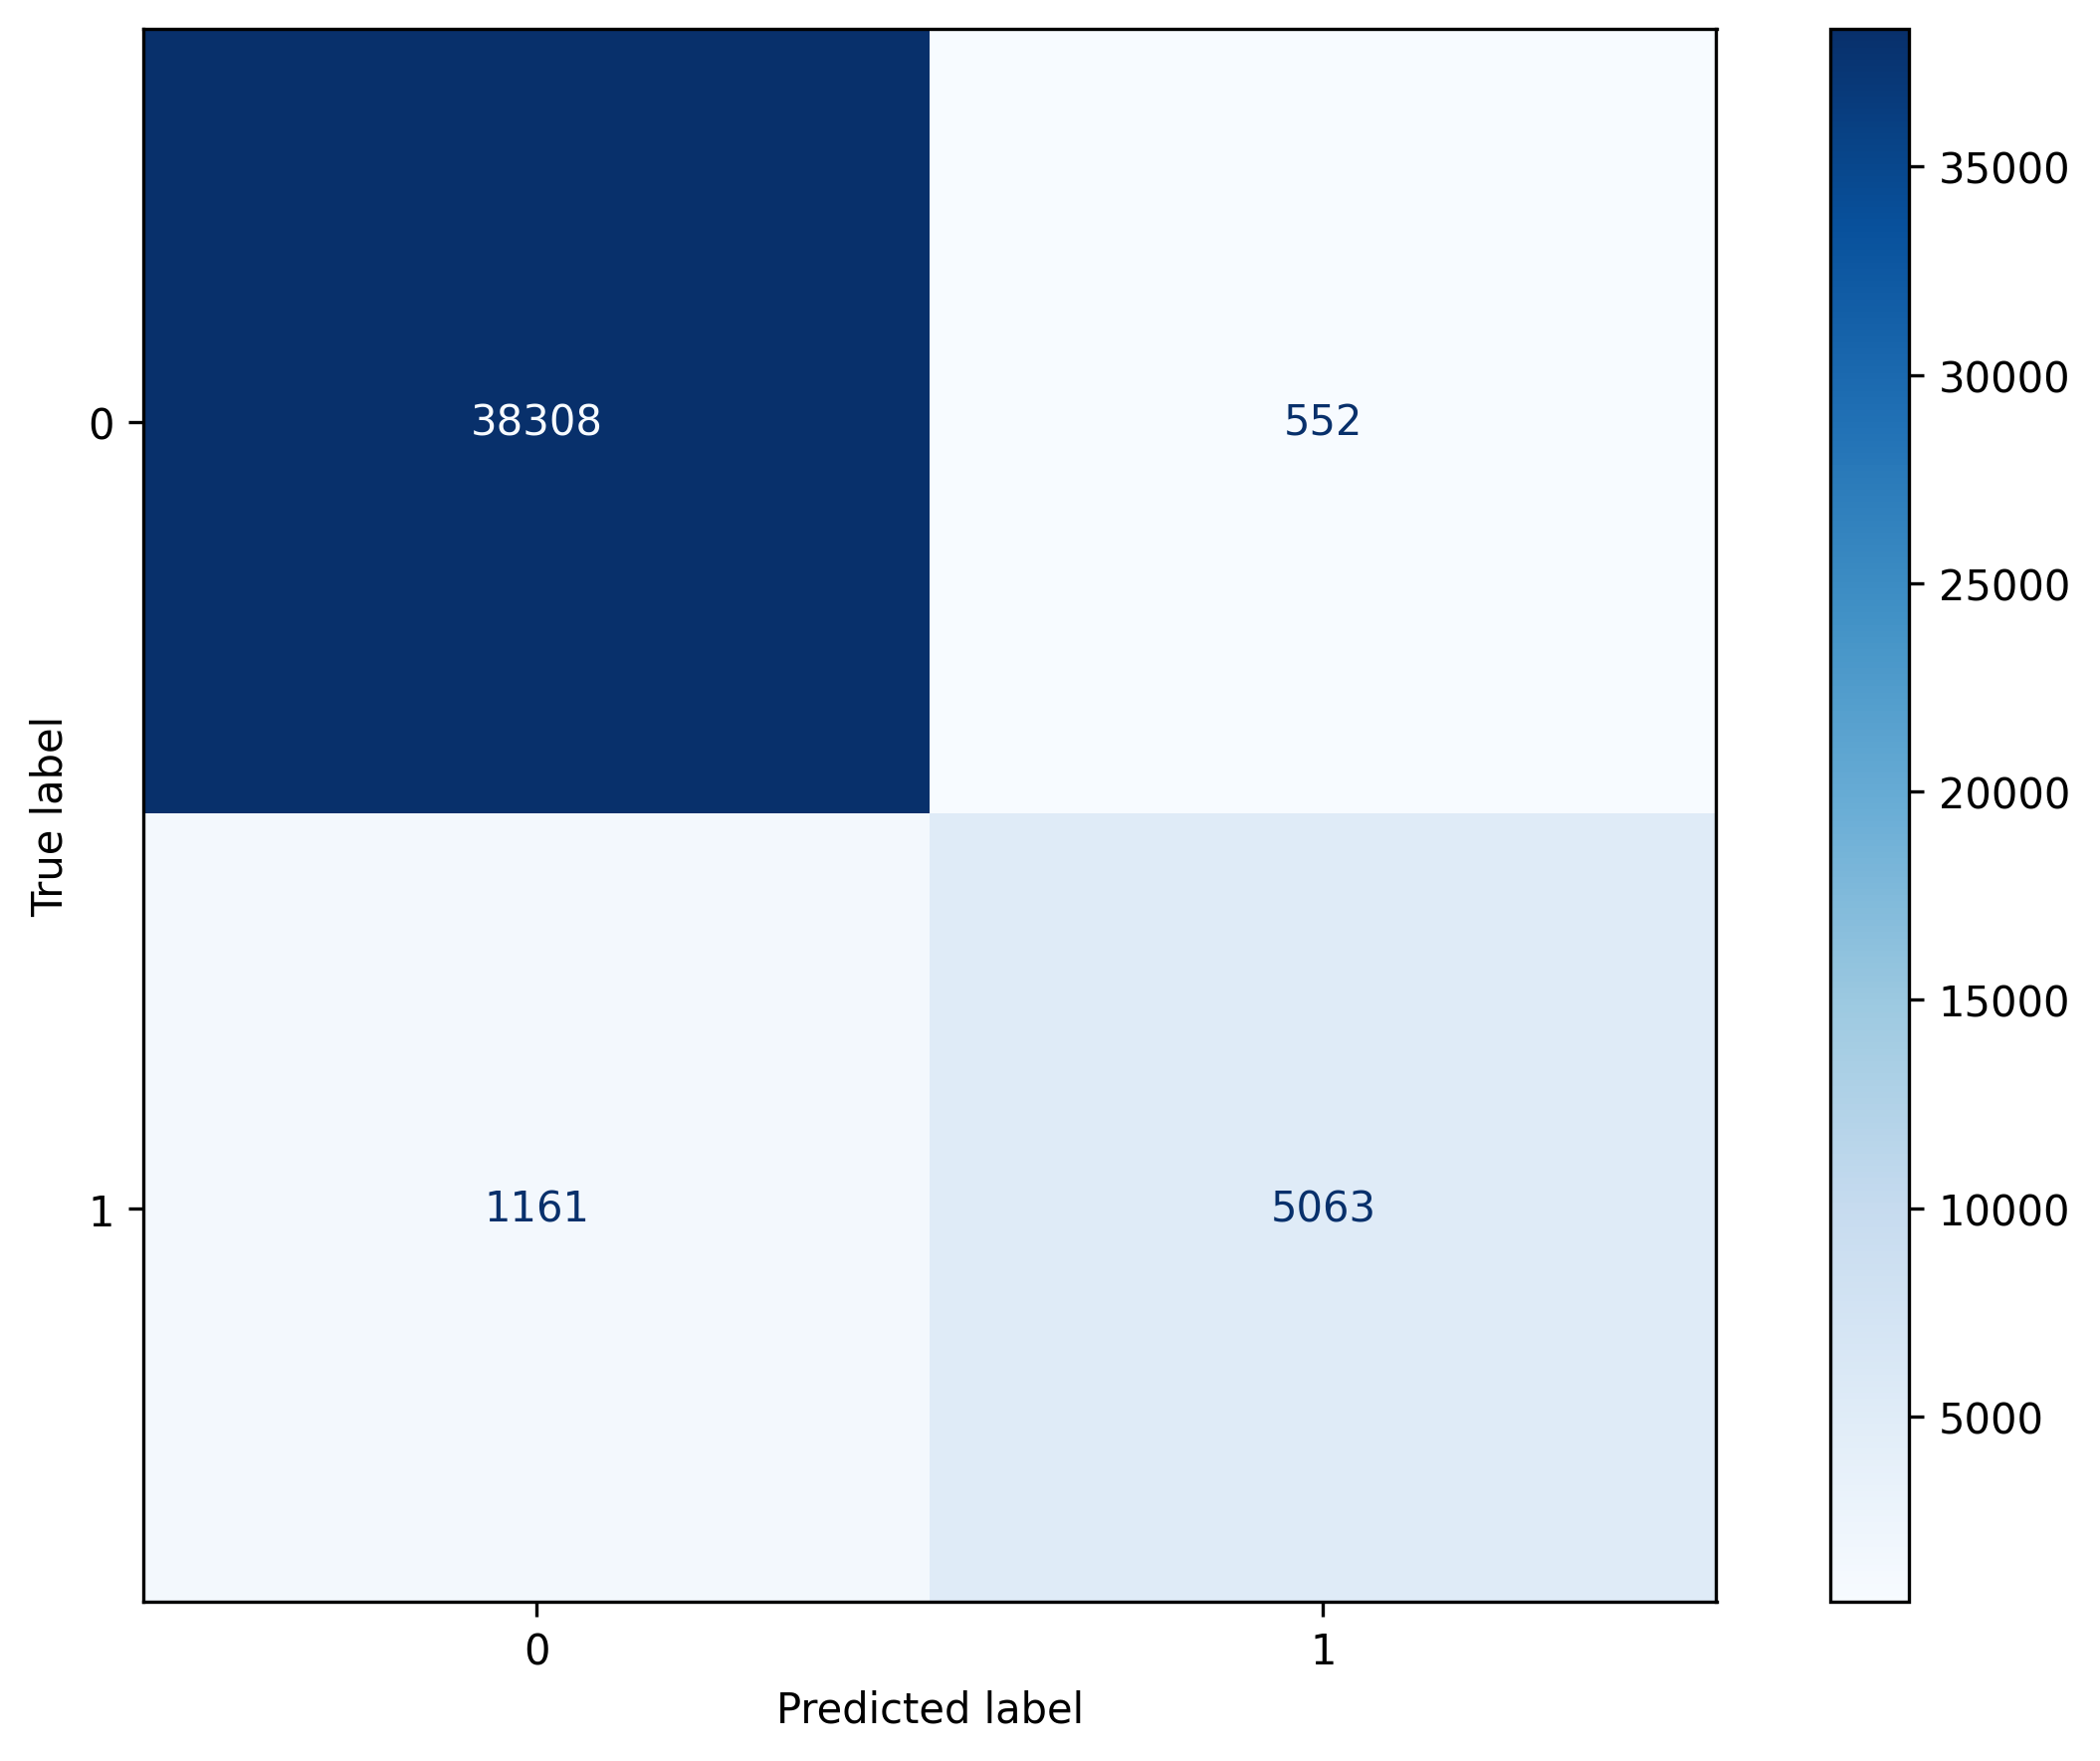

In [21]:
ValidateModel(x_test_scaled, y_test, logreg)

## Logistic Regression - Tuning

In [22]:
lr_tuning = False

if lr_tuning:
    import pandas as pd
    from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
    from sklearn.linear_model import LogisticRegression
    from sklearn.preprocessing import StandardScaler

    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Logistic Regression base model
    logreg = LogisticRegression(random_state=7)

    # Grid of parameters to search
    grid = {
        'C': [30],  # Regularization parameter (default: 1.0)
        'penalty': ['l2'],  # None, l1, l2 (default), elasticnet (both l1 and l2)
        #'max_iter': [3500],  # Maximum number of iterations (default: 100)
        'max_iter': [3500],  # Maximum number of iterations (default: 100)
        "solver": ["liblinear"], #{‘lbfgs’, ‘liblinear’, ‘newton-cg’, ‘newton-cholesky’, ‘sag’, ‘saga’}
    }

    # Stratified K-Folds cross-validator
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)

    # Grid Search
    grid_search = GridSearchCV(
        estimator=logreg,
        param_grid=grid,
        cv=cv,
        #scoring='f1',  # You can change this to another scoring method if needed
        scoring=FETA_Score,  # Custom metric
        verbose=3,
        return_train_score=True
    )

    grid_search.fit(X_train_scaled, y_train)

    # Best estimator
    best_logreg = grid_search.best_estimator_

    # Results
    scores = pd.DataFrame(grid_search.cv_results_)
    

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 1/2] END C=20, max_iter=3500, penalty=l2, solver=liblinear;, score=(train=0.864, test=0.865) total time= 3.5min
[CV 2/2] END C=20, max_iter=3500, penalty=l2, solver=liblinear;, score=(train=0.866, test=0.863) total time= 6.7min
[CV 1/2] END C=25, max_iter=3500, penalty=l2, solver=liblinear;, score=(train=0.864, test=0.865) total time= 5.2min
[CV 2/2] END C=25, max_iter=3500, penalty=l2, solver=liblinear;, score=(train=0.866, test=0.864) total time= 5.7min
[CV 1/2] END C=30, max_iter=3500, penalty=l2, solver=liblinear;, score=(train=0.864, test=0.865) total time= 5.1min
[CV 2/2] END C=30, max_iter=3500, penalty=l2, solver=liblinear;, score=(train=0.866, test=0.864) total time= 4.5min
[CV 1/2] END C=35, max_iter=3500, penalty=l2, solver=liblinear;, score=(train=0.864, test=0.865) total time= 4.5min
[CV 2/2] END C=35, max_iter=3500, penalty=l2, solver=liblinear;, score=(train=0.866, test=0.863) total time= 5.3min


   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0     306.944702     97.767193         0.072786        0.018480      20   
1     328.292865     16.260689         0.055395        0.001292      25   
2     289.493390     16.603389         0.058014        0.003574      30   
3     294.348258     23.094815         0.075473        0.016893      35   

  param_max_iter param_penalty param_solver  \
0           3500            l2    liblinear   
1           3500            l2    liblinear   
2           3500            l2    liblinear   
3           3500            l2    liblinear   

                                              params  split0_test_score  \
0  {'C': 20, 'max_iter': 3500, 'penalty': 'l2', '...           0.864666   
1  {'C': 25, 'max_iter': 3500, 'penalty': 'l2', '...           0.864670   
2  {'C': 30, 'max_iter': 3500, 'penalty': 'l2', '...           0.864700   
3  {'C': 35, 'max_iter': 3500, 'penalty': 'l2', '...           0.864678   

   split1_te

/tmp/ipykernel_3863682/2064128811.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  value = means_df[col_name][max_ids[i]]
/tmp/ipykernel_3863682/2064128811.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  id = max_ids[i]
/tmp/ipykernel_3863682/2064128811.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color = 'r' if max_ids[i] == max_ids['mean_test_score'] else 'grey'


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0     306.944702     97.767193         0.072786        0.018480      20   
1     328.292865     16.260689         0.055395        0.001292      25   
2     289.493390     16.603389         0.058014        0.003574      30   
3     294.348258     23.094815         0.075473        0.016893      35   

  param_max_iter param_penalty param_solver  \
0           3500            l2    liblinear   
1           3500            l2    liblinear   
2           3500            l2    liblinear   
3           3500            l2    liblinear   

                                              params  split0_test_score  \
0  {'C': 20, 'max_iter': 3500, 'penalty': 'l2', '...           0.864666   
1  {'C': 25, 'max_iter': 3500, 'penalty': 'l2', '...           0.864670   
2  {'C': 30, 'max_iter': 3500, 'penalty': 'l2', '...           0.864700   
3  {'C': 35, 'max_iter': 3500, 'penalty': 'l2', '...           0.864678   

   split1_test_score  mean_test_score  std_test_score  rank_test_score  \
0           0.863406         0.864036        0.000630                3   
1           0.863561         0.864115        0.000555                2   
2           0.863553         0.864126        0.000573                1   
3           0.863365         0.864022        0.000657                4   

   split0_train_score  split1_train_score  mean_train_score  std_train_score  
0            0.863941            0.866308          0.865125         0.001184  
1            0.864153            0.866393          0.865273         0.001120  
2            0.864176            0.866365          0.865271         0.001094  
3            0.864464            0.866428          0.865446         0.000982

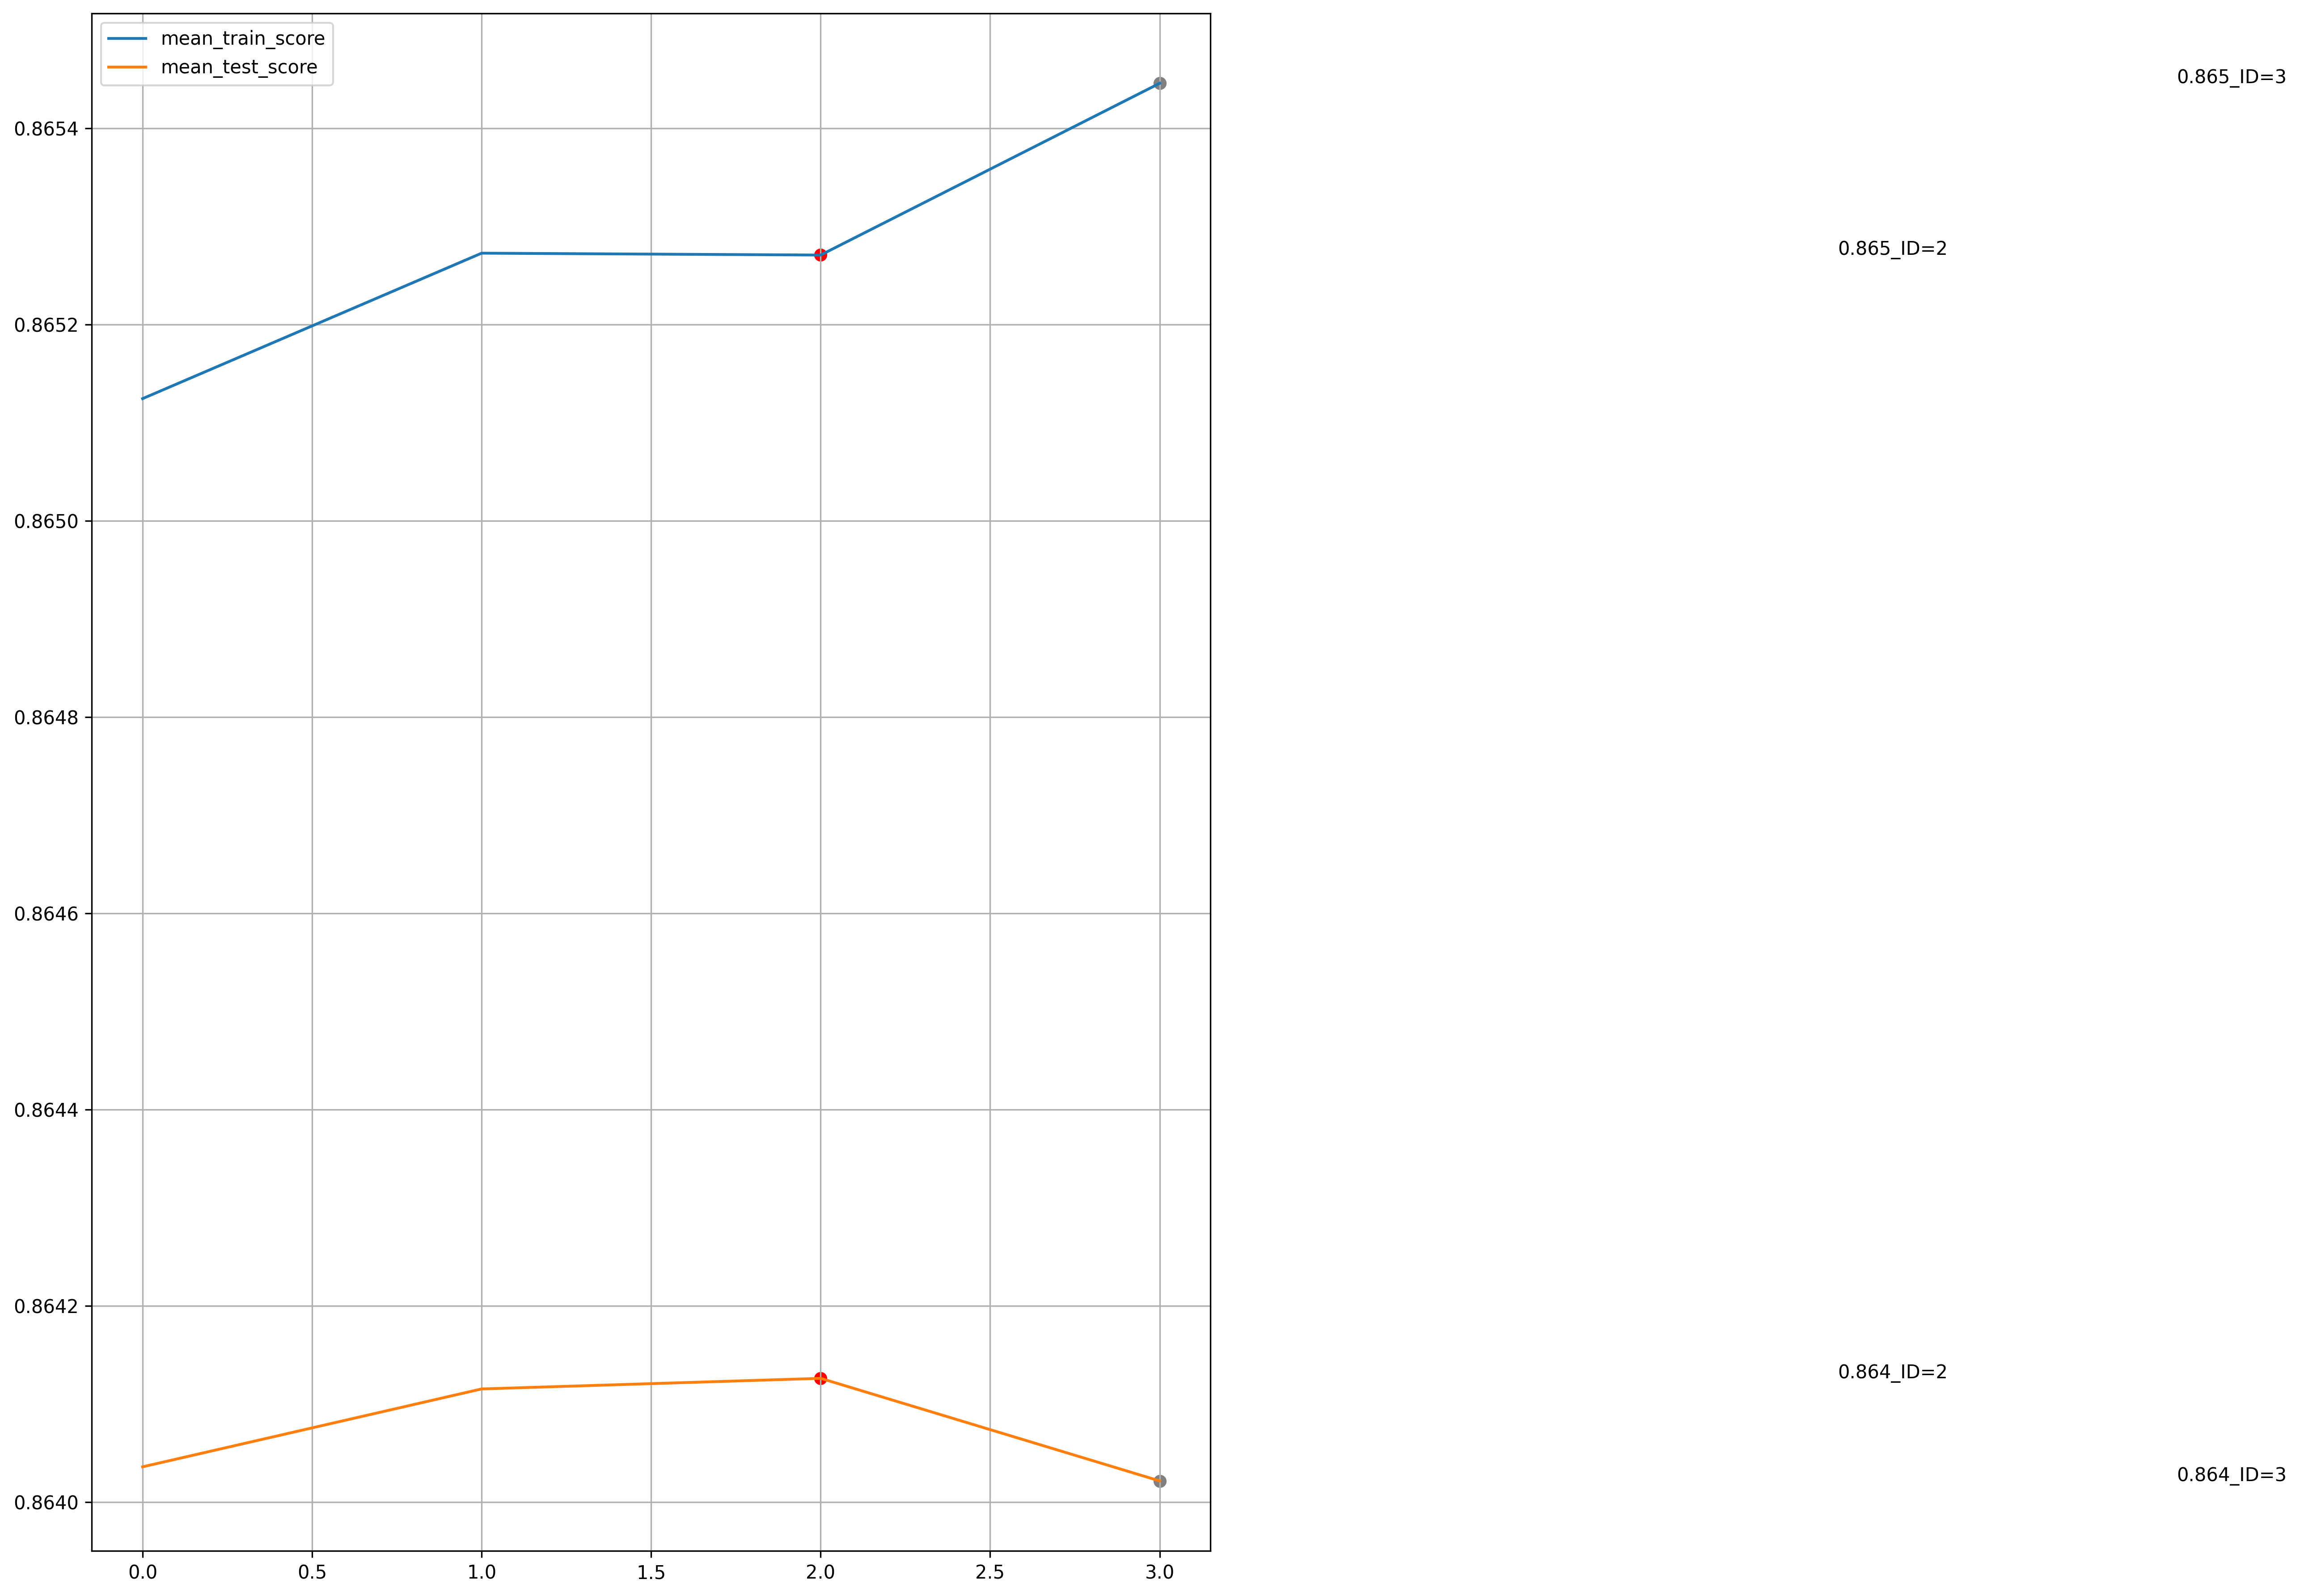

In [27]:
if lr_tuning: 
    DisplayTuningGraph(scores)
    scores
scores

# SVM

# SVM - Training

In [22]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using: ", torch.cuda.get_device_name(device))


import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd

import copy

svm_x_train = copy.deepcopy(X_train)
svm_x_test = copy.deepcopy(X_test)

svm_y_train = copy.deepcopy(y_train)
svm_y_test = copy.deepcopy(y_test)


subsample = 1.0  # False for real training on the entire dataset
if subsample < 1.0:
    svm_x_train, _, svm_y_train, _ = train_test_split(
        svm_x_train,
        svm_y_train,
        test_size=1.0 - subsample,
        random_state=42,
        shuffle=True,
        stratify=svm_y_train
    )
    
    # Check the number of samples after subsampling
    print(f"After Subsampling - svm_x_train: {len(svm_x_train)}, svm_y_train: {len(svm_y_train)}")
    
    
    
# PREPROCESSING
# fill nans with 0 in X_train and X_test and y_train and y_test
svm_x_train = svm_x_train.fillna(0)
svm_x_test = svm_x_test.fillna(0)
    
svm_y_train = svm_y_train.fillna(0)
svm_y_test = svm_y_test.fillna(0)
    
# convert x_train to numpy array
svm_x_train = svm_x_train.to_numpy()
svm_x_test = svm_x_test.to_numpy()

svm_y_train = svm_y_train.to_numpy()
svm_y_test = svm_y_test.to_numpy()
    
# Converting False and True to 0 and 1
svm_x_train = np.where(svm_x_train == False, 0, svm_x_train)
svm_x_train = np.where(svm_x_train == True, 1, svm_x_train)
    
svm_x_test = np.where(svm_x_test == False, 0, svm_x_test)
svm_x_test = np.where(svm_x_test == True, 1, svm_x_test)
    
feature_count = svm_x_train.shape[1]
sample_count = svm_x_train.shape[0]

# print number of samples and features
print("Number of features: ", sample_count)
print("Number of samples: ", sample_count)


# Scaling 
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

# MinMax data scaler
scaler = MinMaxScaler()
svm_x_train = scaler.fit_transform(svm_x_train)
svm_x_test = scaler.transform(svm_x_test)

params = {
    #"class_weight": "balanced",
    "C": 59,
    "gamma": 0.1,
    "kernel": "rbf", # ['rbf', 'linear', 'poly', 'sigmoid']
    "random_state": 7,
    #"shrinking": True
}


model = SVC(**params, verbose=True)
model.fit(svm_x_train, svm_y_train)

Using:  NVIDIA GeForce RTX 3070
After Subsampling - svm_x_train: 21038, svm_y_train: 21038
Number of features:  21038
Number of samples:  21038
[LibSVM]....................*..........*
optimization finished, #iter = 30703
obj = -26854.321606, rho = -1.257979
nSV = 1878, nBSV = 283
Total nSV = 1878


SVC(C=59, gamma=0.1, random_state=7, verbose=True)

# SVM - Validation

TN: 38391 <-- True Negatives
FP: 469 <-- False Positives
FN: 584 <-- False Negatives
TP: 5640 <-- True Positives
FPR:0.01206896551724138 <-- False Positive Rate
TPR:0.9061696658097687 <-- True Positive Rate (same as Recall)
 
              precision    recall  f1-score   support

           0     0.9850    0.9879    0.9865     38860
           1     0.9232    0.9062    0.9146      6224

    accuracy                         0.9766     45084
   macro avg     0.9541    0.9471    0.9505     45084
weighted avg     0.9765    0.9766    0.9766     45084



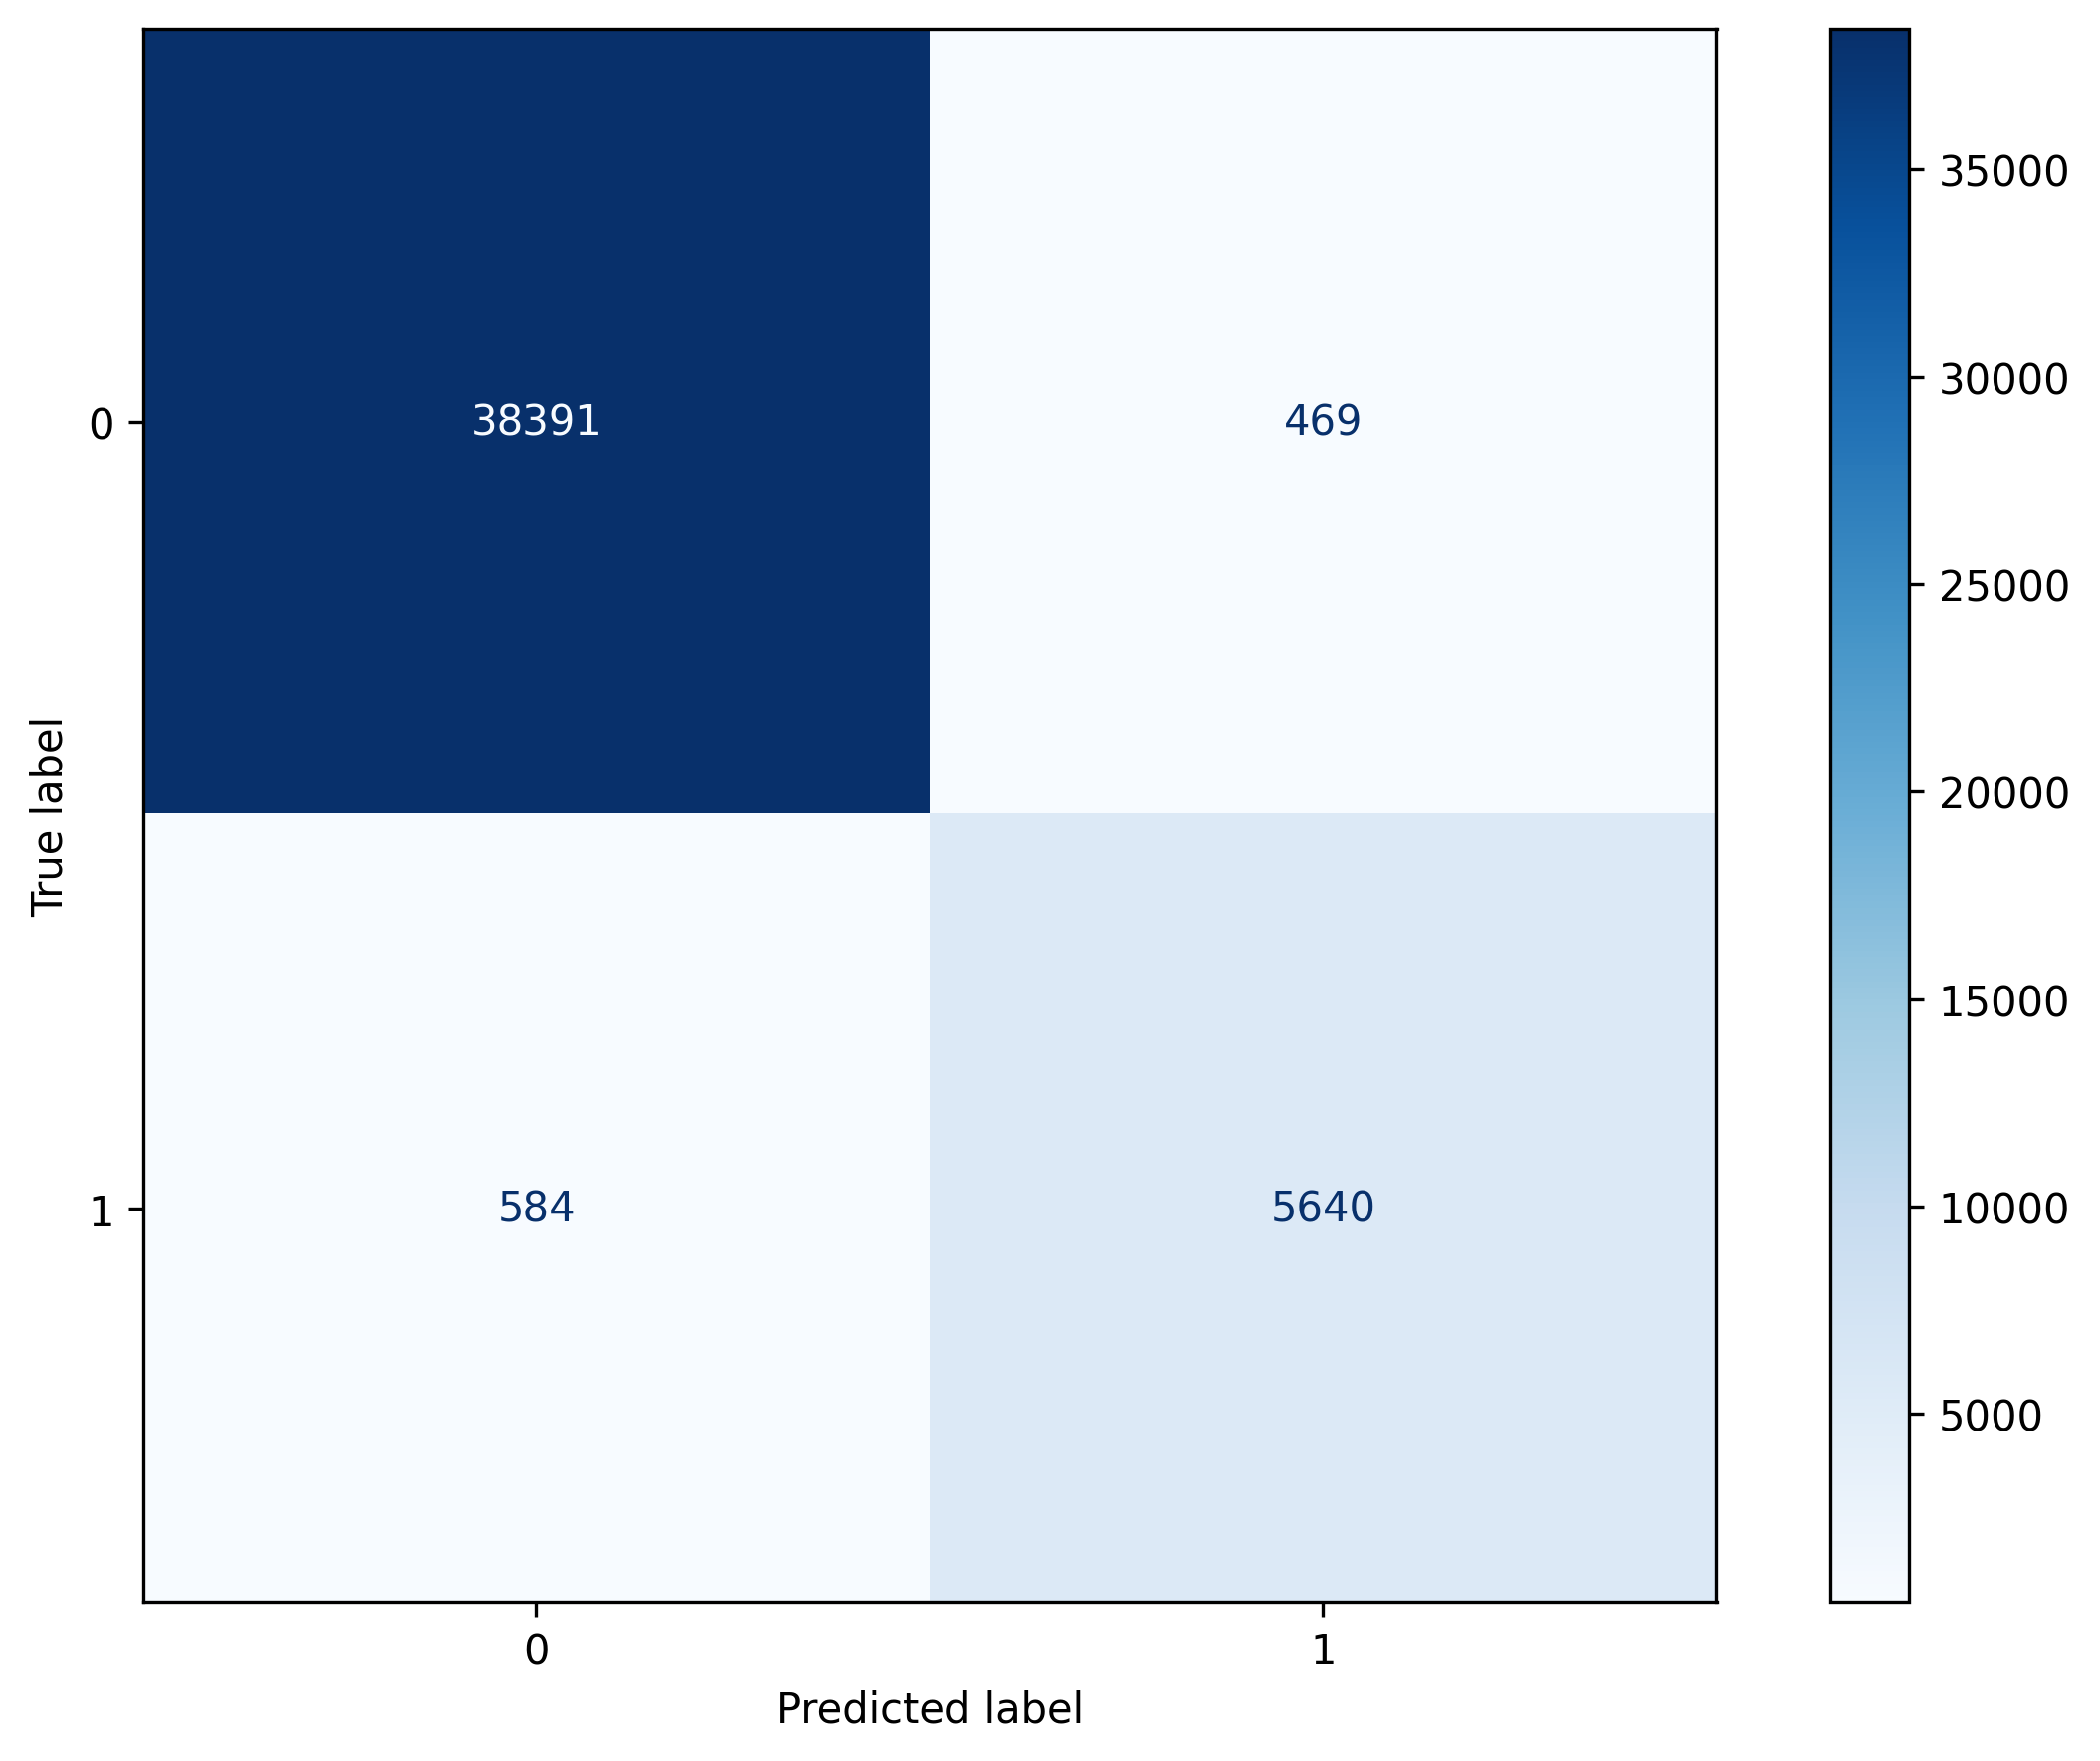

In [23]:
ValidateModel(svm_x_test, svm_y_test, model)

# SVM - Tuning

In [ ]:
svm_tuning = False

import warnings
# Suppress specific FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

if svm_tuning:
    import numpy as np
    import pandas as pd
    from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
    from sklearn.svm import SVC
    from sklearn.preprocessing import MinMaxScaler

    # Assuming df is your DataFrame and class_map maps your classes
    #labels = df['label'].apply(lambda x: class_map[x])
    #features = df.drop('label', axis=1).copy()

    # Split the dataset
    #X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42, shuffle=True, stratify=labels)

    
    import copy

    svm_x_train = copy.deepcopy(X_train)
    svm_x_test = copy.deepcopy(X_test)

    svm_y_train = copy.deepcopy(y_train)
    svm_y_test = copy.deepcopy(y_test)

    
    #############################
    # SUBSAMPLE FOR GRID SEARCH #
    #############################
    subsample = 1.0
    if subsample < 1.0:
        svm_x_train, _, svm_y_train, _ = train_test_split(
            X_train,
            y_train,
            test_size=1.0 - subsample,
            random_state=42,
            shuffle=True,
            stratify=y_train
        )

    # Preprocessing: Fill NaNs and scale features
    svm_x_train = svm_x_train.fillna(0)
    #svm_X_test = svm_X_test.fillna(0)
    scaler = MinMaxScaler()
    svm_x_train = scaler.fit_transform(svm_x_train)
    #svm_X_test = scaler.transform(svm_X_test)

    # SVM base model
    svm = SVC(random_state=7)

    # Grid of parameters to search
    grid = {
        "C": [58, 59, 60],  # Regularization parameter
        #"gamma": ["scale", "auto"],  # Kernel coefficient
        "gamma": [0.09, 0.1, 0.11],
        "kernel": ["rbf"], #['rbf', 'linear', 'poly', 'sigmoid']
        #"shrinking": [True, False]
    }

    # Stratified K-Folds cross-validator
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)

    # Grid Search
    grid_search = GridSearchCV(
        estimator=svm,
        param_grid=grid,
        cv=cv,
        #scoring='f1',  # You can change this to another scoring method if needed
        scoring=FETA_Score,  # Custom metric
        verbose=3,
        return_train_score=True
    )

    grid_search.fit(svm_x_train, svm_y_train)

    # Best estimator
    best_svm = grid_search.best_estimator_

    # Results
    scores = pd.DataFrame(grid_search.cv_results_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END .......C=58, gamma=0.09, kernel=rbf, shrinking=True; total time=19.8min
[CV] END .......C=58, gamma=0.09, kernel=rbf, shrinking=True; total time=18.2min
[CV] END .......C=58, gamma=0.09, kernel=rbf, shrinking=True; total time=17.8min
[CV] END .....C=58, gamma=0.09, kernel=rbf, shrinking=False; total time=114.8min
[CV] END .....C=58, gamma=0.09, kernel=rbf, shrinking=False; total time=112.2min
[CV] END .....C=58, gamma=0.09, kernel=rbf, shrinking=False; total time=113.3min
[CV] END ........C=58, gamma=0.1, kernel=rbf, shrinking=True; total time=19.2min
[CV] END ........C=58, gamma=0.1, kernel=rbf, shrinking=True; total time=18.0min
[CV] END ........C=58, gamma=0.1, kernel=rbf, shrinking=True; total time=18.2min
[CV] END ......C=58, gamma=0.1, kernel=rbf, shrinking=False; total time=114.2min
[CV] END ......C=58, gamma=0.1, kernel=rbf, shrinking=False; total time=113.5min
[CV] END ......C=58, gamma=0.1, kernel=rbf, shri

In [ ]:
if svm_tuning:
    DisplayTuningGraph(scores)

scores

# Decision Tree

## Decision Tree - Training

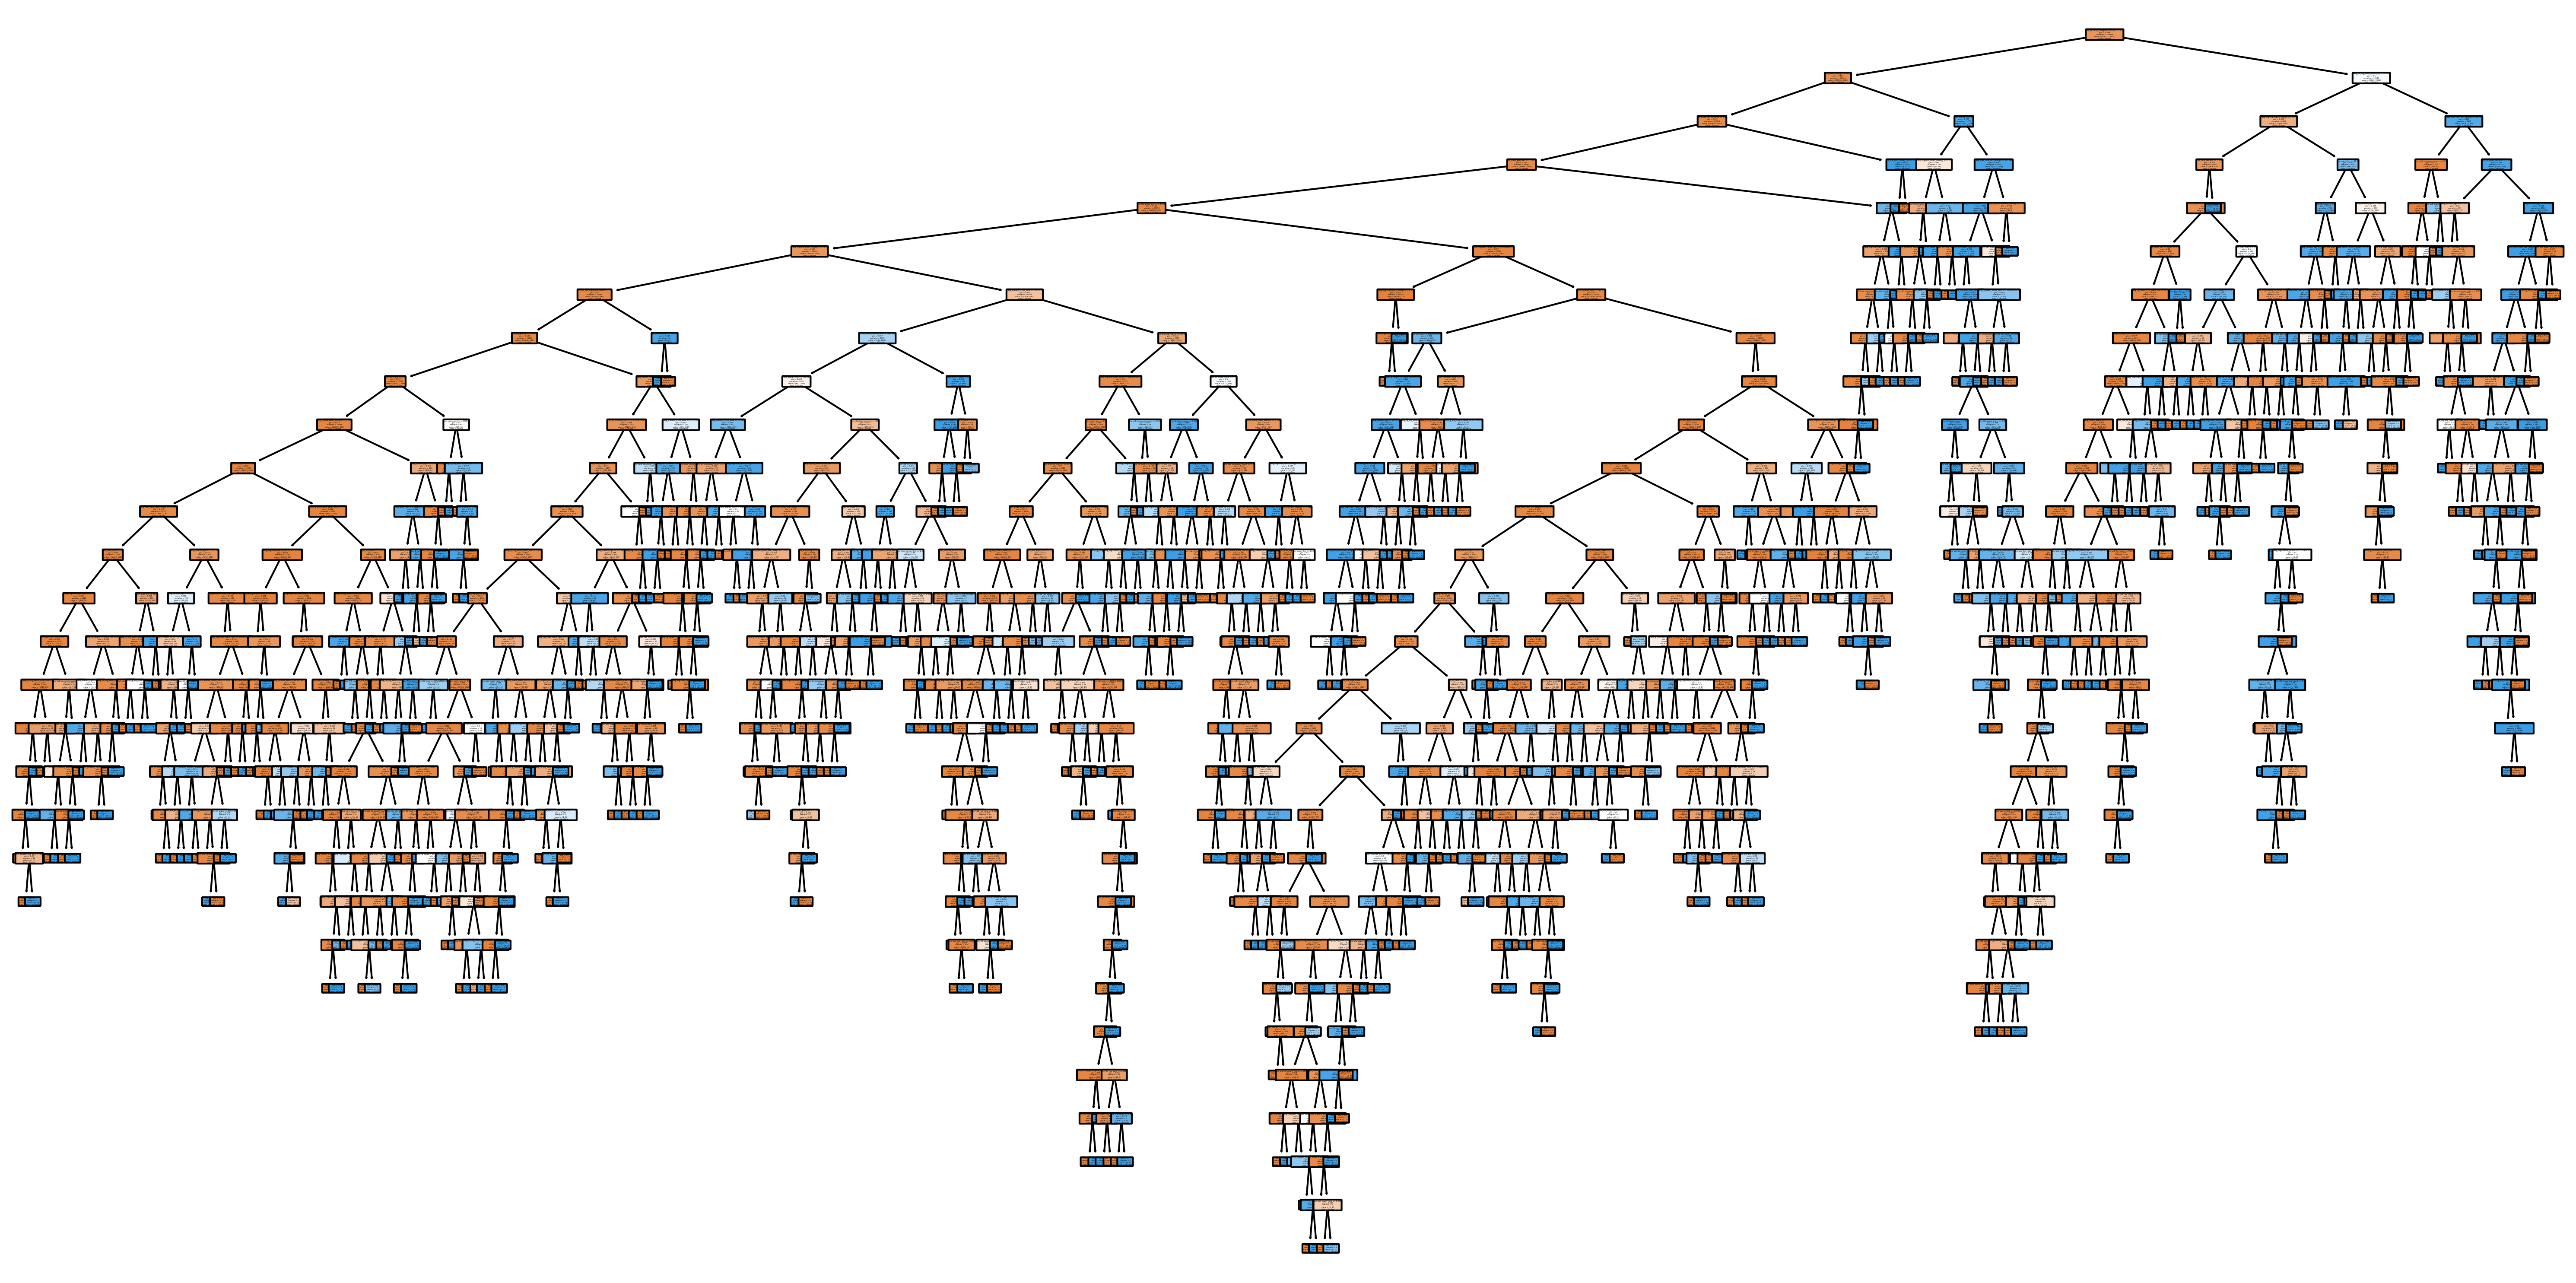

<Figure size 2400x1800 with 0 Axes>

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

params = {
    "max_depth": 30,
    "max_leaf_nodes": 803,
    "min_samples_leaf": 1,
    "min_samples_split": 2,
    "random_state": 7
}

model = DecisionTreeClassifier(**params)
model.fit(X_train, y_train)


from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# To visualize the trained Decision Tree
plt.figure(figsize=(20, 10))  # Set the figure size, you may need to adjust this to fit the tree
plot_tree(model, filled=True, feature_names=X_train.columns, class_names=['benign', 'phishing'], rounded=True)
plt.show()

plt.savefig('decision_tree.pdf', format='pdf', bbox_inches='tight')  # Save the plot to a PDF file

## Decision Tree - Validation

TN: 38434 <-- True Negatives
FP: 426 <-- False Positives
FN: 621 <-- False Negatives
TP: 5603 <-- True Positives
FPR:0.010962429233144621 <-- False Positive Rate
TPR:0.9002249357326478 <-- True Positive Rate (same as Recall)
 
              precision    recall  f1-score   support

           0     0.9841    0.9890    0.9866     38860
           1     0.9293    0.9002    0.9146      6224

    accuracy                         0.9768     45084
   macro avg     0.9567    0.9446    0.9506     45084
weighted avg     0.9765    0.9768    0.9766     45084



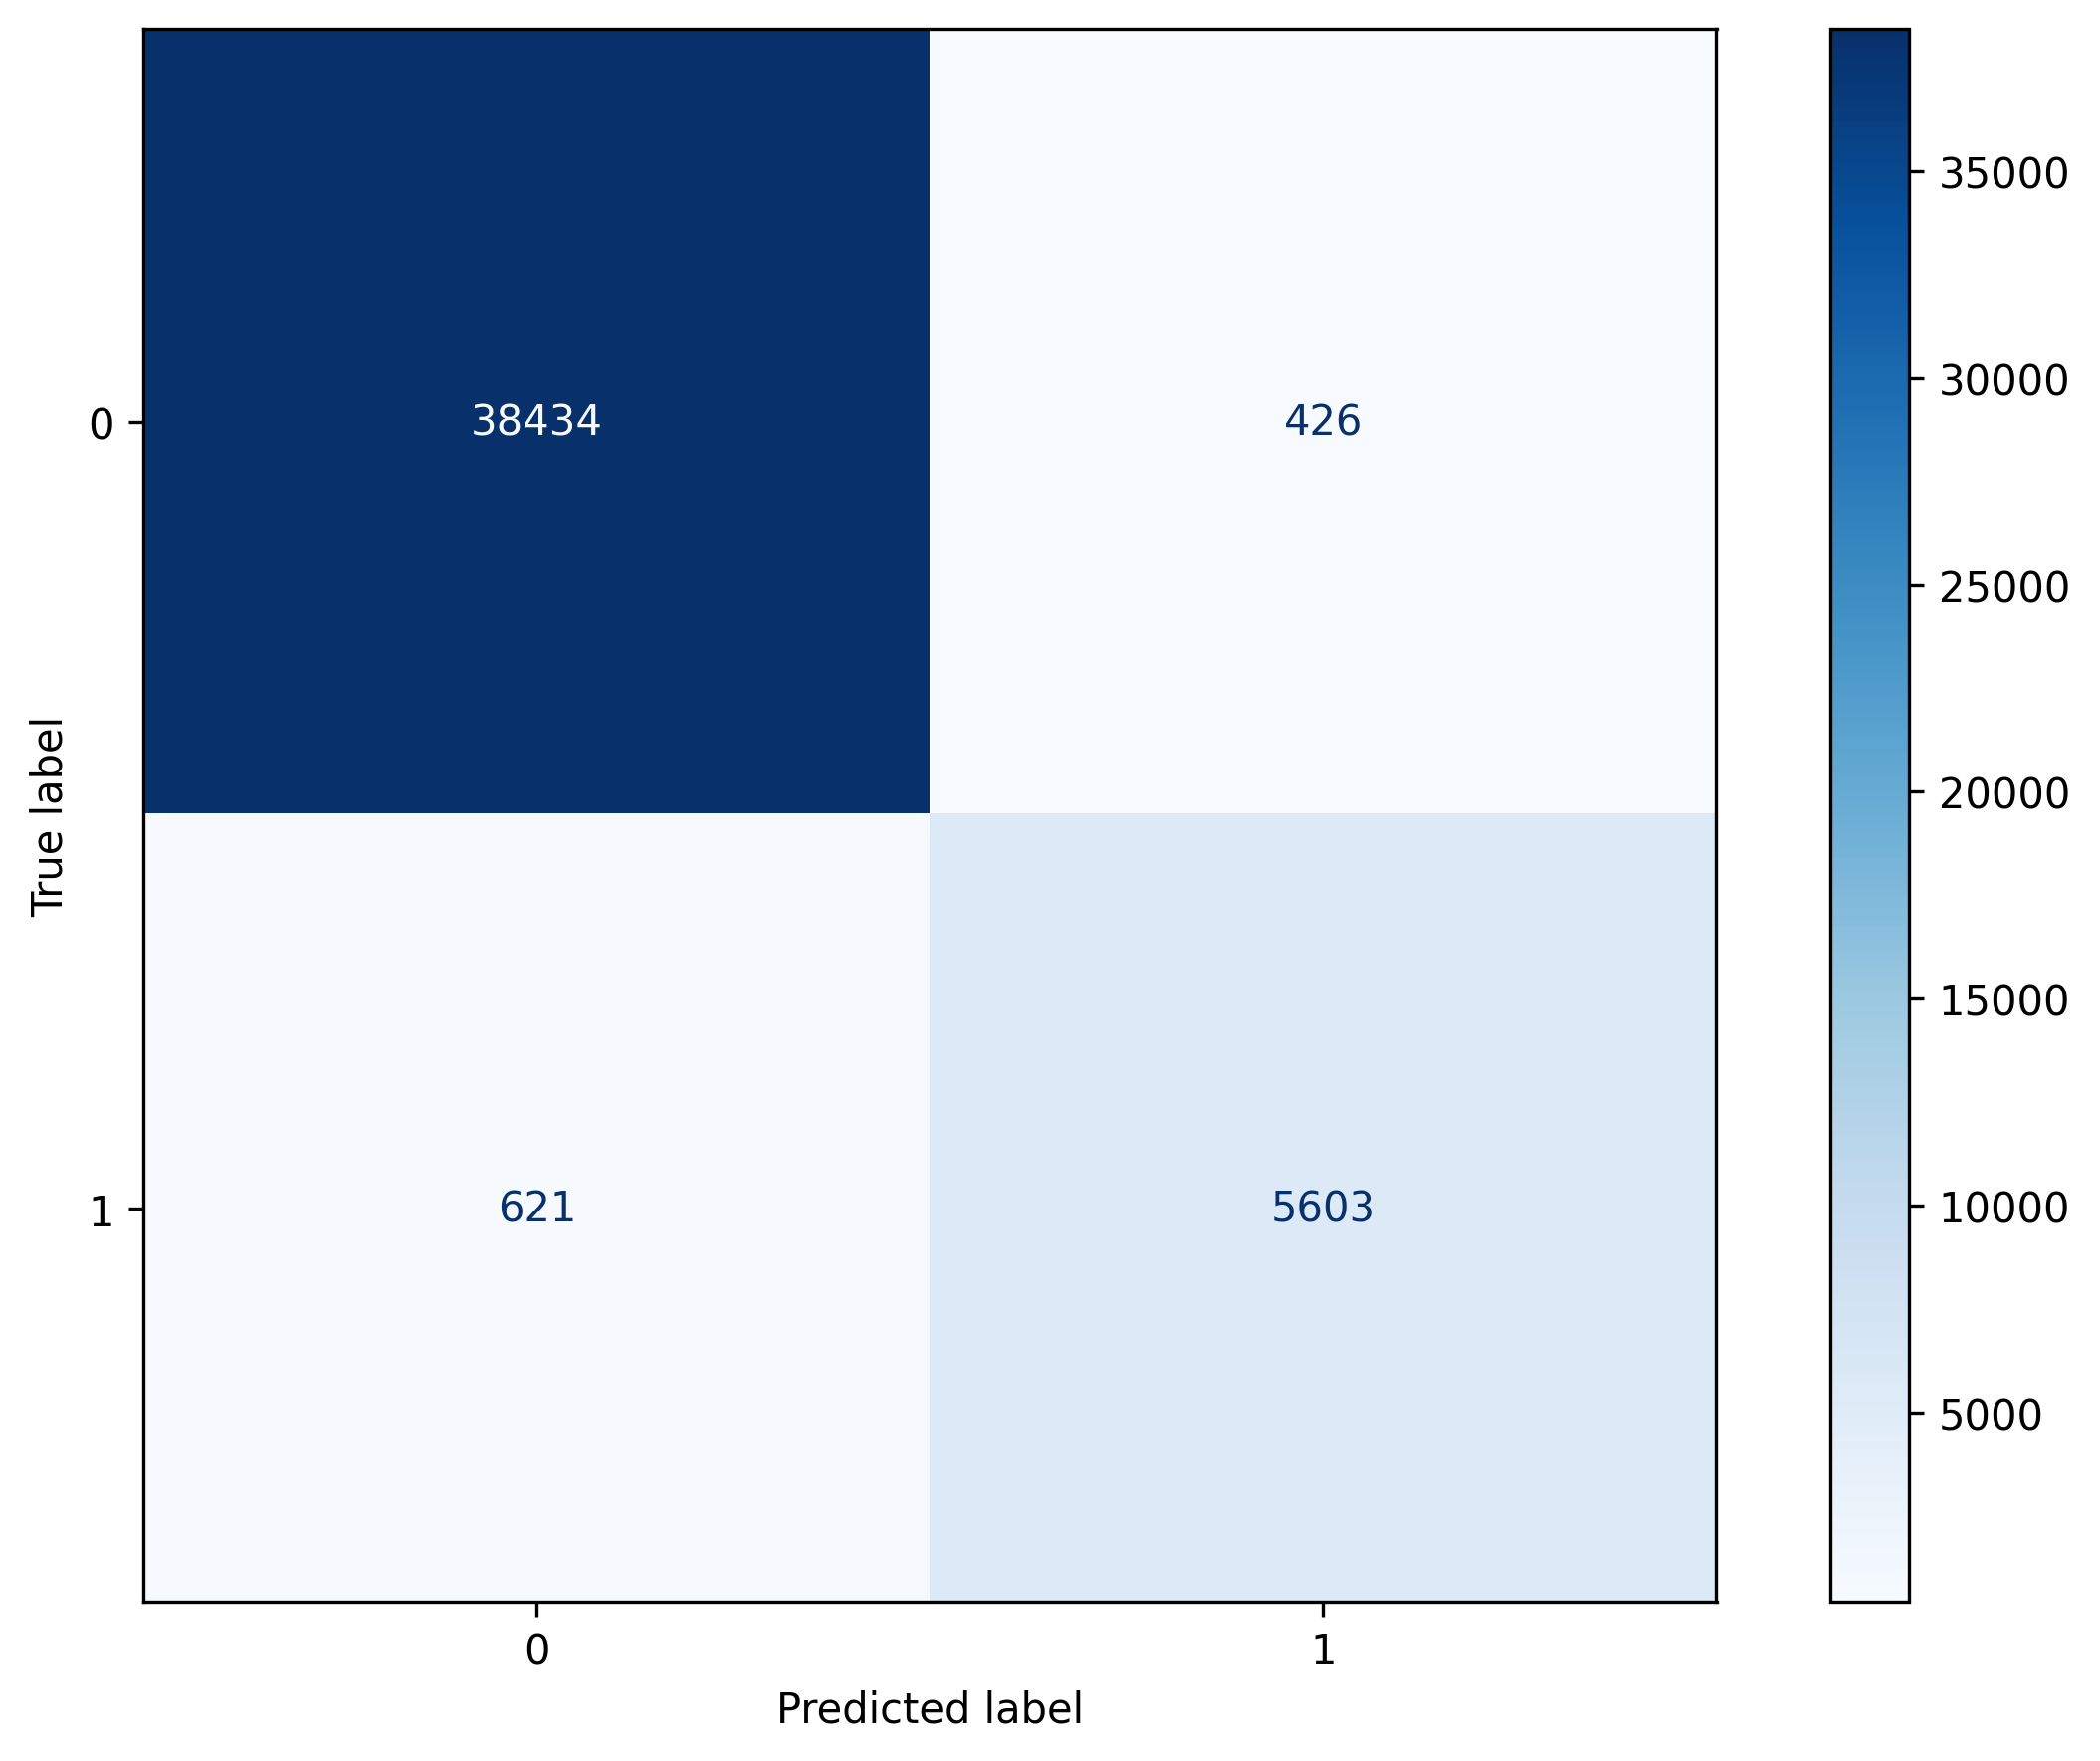

In [25]:
ValidateModel(X_test, y_test, model)

## Decision Tree - Tuning

In [33]:
dt_tuning = False

if dt_tuning:

    import pandas as pd
    from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
    from sklearn.tree import DecisionTreeClassifier

    # Assuming df is your DataFrame and class_map maps your classes
    #labels = df['label'].apply(lambda x: class_map[x])
    #features = df.drop('label', axis=1).copy()

    # Split the dataset
    #X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42, shuffle=True, stratify=labels)

    # Fixed parameters
    params = {
        "max_depth": 30, # Maximum depth of the tree
        "min_samples_leaf": 1, # Minimum number of samples required to be at a leaf node
        "max_leaf_nodes": 803, # Maximum number of leaf nodes
    }
    
    # Decision Tree base model
    dt = DecisionTreeClassifier(**params, random_state=7)

    # Grid of parameters to search
    grid = {
        'min_samples_split': [5,6,7],  # Minimum number of samples required to split an internal node
    }

    # Stratified K-Folds cross-validator
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

    # Grid Search
    grid_search = GridSearchCV(
        estimator=dt,
        param_grid=grid,
        cv=cv,
        #scoring='f1',  # You can change this to another scoring method if needed
        scoring=FETA_Score,  # Custom metric
        verbose=3,
        return_train_score=True
    )

    grid_search.fit(X_train, y_train)

    # Best estimator
    best_dt = grid_search.best_estimator_

    # Results
    scores = pd.DataFrame(grid_search.cv_results_)


In [34]:
if dt_tuning:
    DisplayTuningGraph(scores)

scores

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      16.061821      0.211475         1.075103        0.023072   
1      15.670874      0.127885         1.046873        0.017982   
2      16.020327      0.094979         1.068186        0.002844   

  param_class_weight                            params  split0_test_score  \
0     {0: 1, 1: 2.1}  {'class_weight': {0: 1, 1: 2.1}}           0.946548   
1       {0: 1, 1: 2}    {'class_weight': {0: 1, 1: 2}}           0.947427   
2     {0: 1, 1: 1.9}  {'class_weight': {0: 1, 1: 1.9}}           0.947087   

   split1_test_score  mean_test_score  std_test_score  rank_test_score  \
0           0.943688         0.945118        0.001430                3   
1           0.944706         0.946067        0.001361                2   
2           0.945068         0.946078        0.001010                1   

   split0_train_score  split1_train_score  mean_train_score  std_train_score  
0            0.995877            0.997421          0.996649         0.000772  
1            0.996004            0.997171          0.996588         0.000583  
2            0.995503            0.997129          0.996316         0.000813

# Random Forest

## Random Forest - Training

In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


# Random Forest parameters
params = {
    "n_estimators": 143,
    "criterion": 'entropy',
    "max_depth": 19,
    "min_samples_split": 2,
    "min_samples_leaf": 1,
    "max_leaf_nodes": 174,
    
    "random_state":7
}
model = RandomForestClassifier(**params)


# at last, train the model
_ = model.fit(X_train, y_train)





## Random Forest - Validation

              precision    recall  f1-score   support

           0     0.9779    0.9974    0.9875     25947
           1     0.9811    0.8574    0.9151      4109

    accuracy                         0.9782     30056
   macro avg     0.9795    0.9274    0.9513     30056
weighted avg     0.9783    0.9782    0.9776     30056

Confusion Matrix:
TN: 25879 FP: 68 FN: 586 TP: 3523


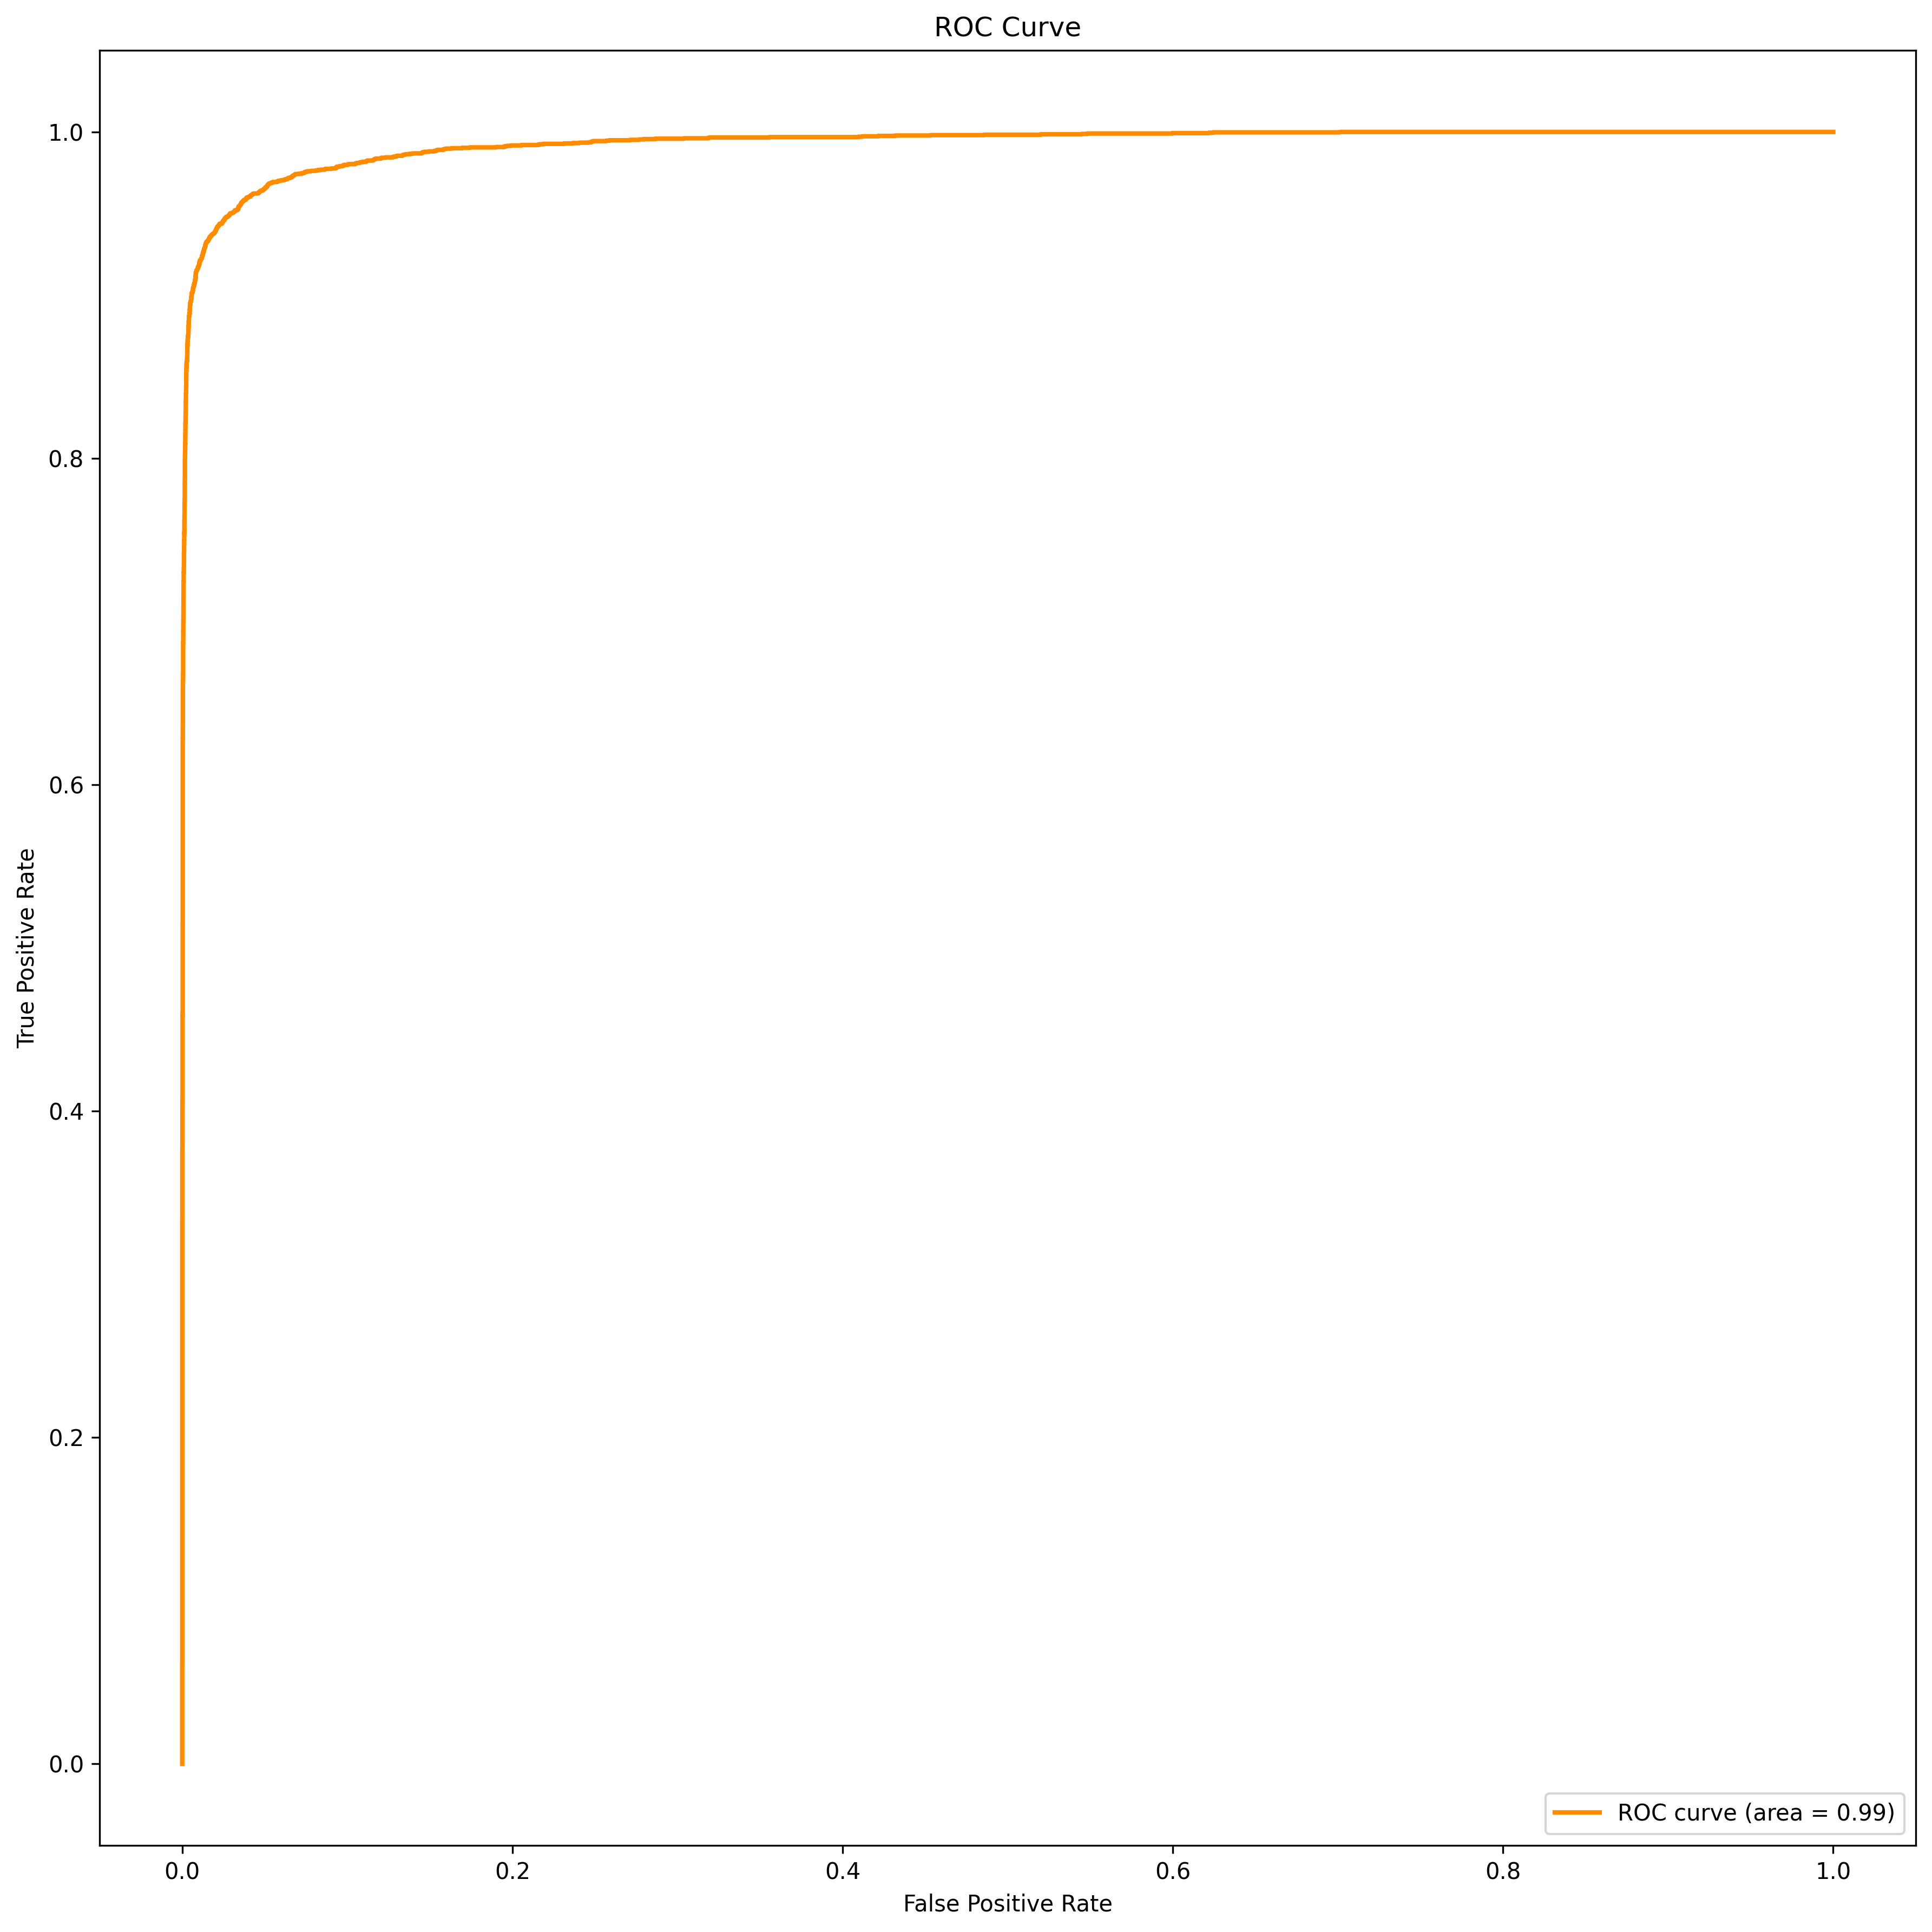

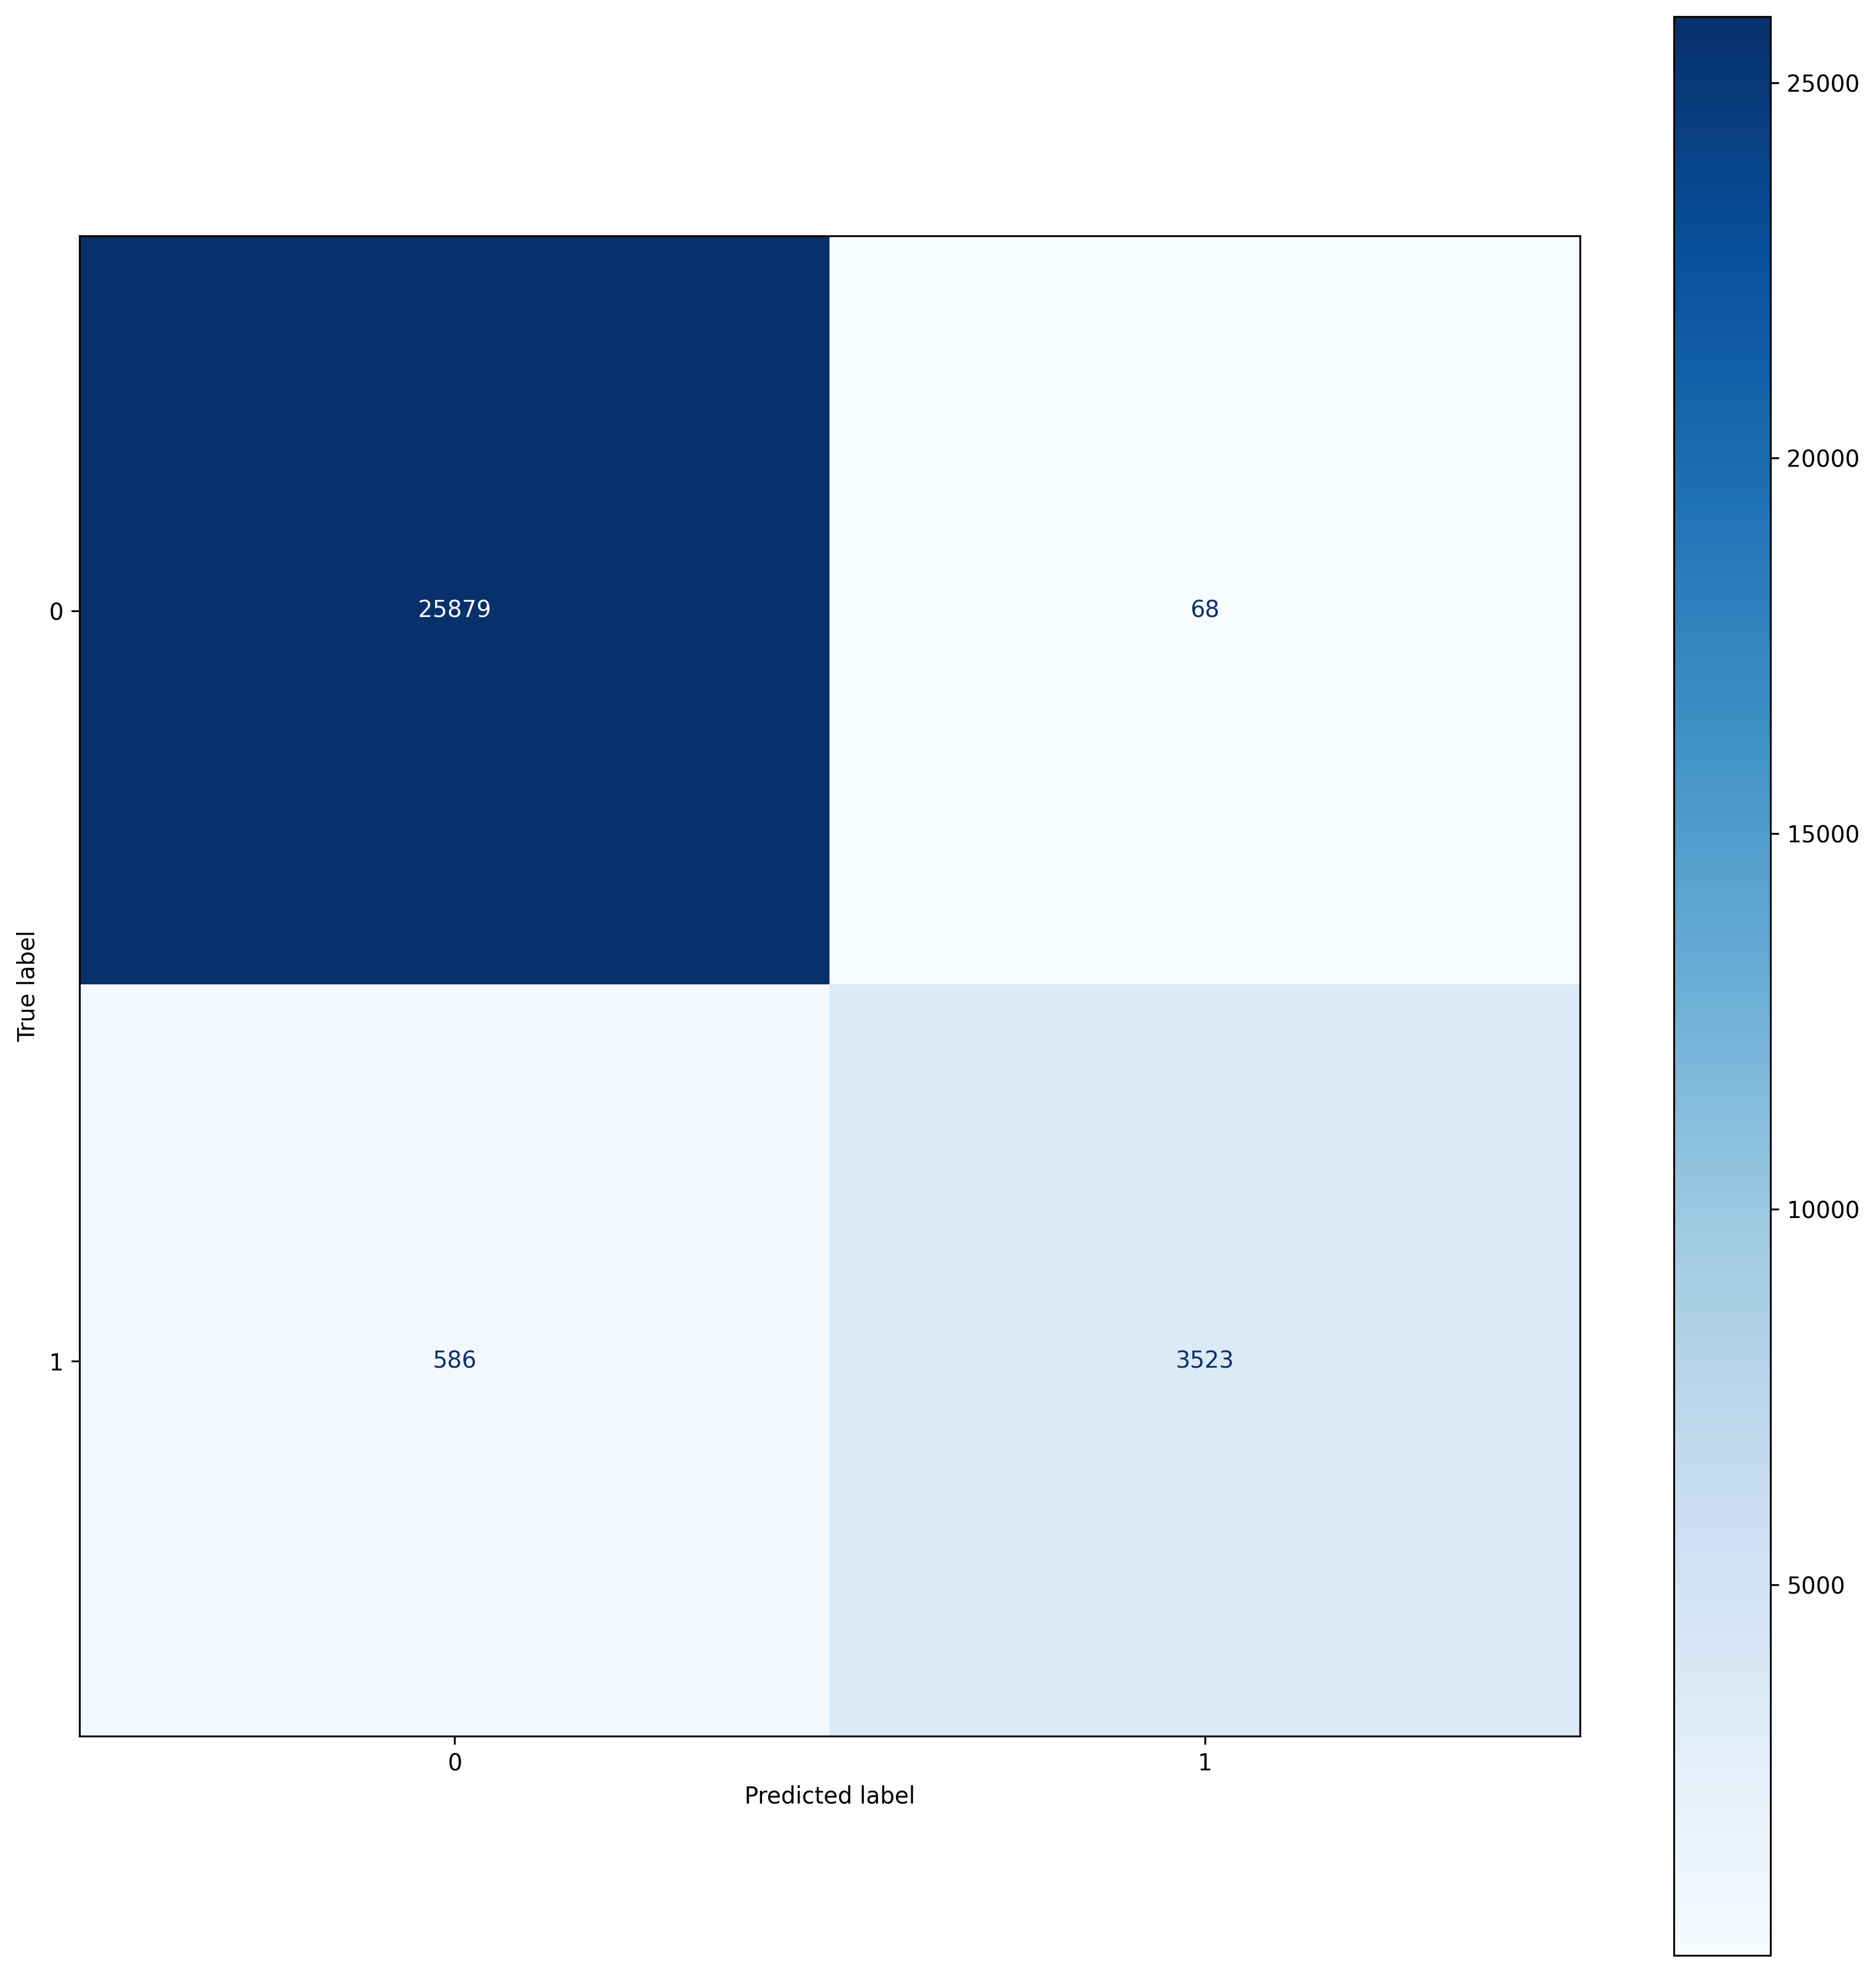

In [69]:
ValidateModel_advanced(X_test, y_test, model)

## Random Forest - Tuning

In [46]:
rf_tuning = True

if rf_tuning:
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
    import pandas as pd

    # Assuming df is your DataFrame and class_map maps your classes
    labels = df['label'].apply(lambda x: class_map[x])
    features = df.drop('label', axis=1).copy()

   
    params = {
        "n_estimators": 143,
        "criterion": 'entropy',
        "max_depth": 19,
        "min_samples_split": 2,
        "min_samples_leaf": 1,
        "class_weight": {0:1, 1:5}
        #"max_features": None,
        #"max_leaf_nodes": 174,
    }
    
     # Random Forest base model
    rf = RandomForestClassifier(random_state=7, **params)
    
    # Grid of parameters to search    
    grid = {
        'n_estimators': [50, 70, 143, 200],  # Number of trees in the forest
        'max_depth': [10, 14, 17],  # Maximum depth of the tree
        #'min_samples_split': [2],  # Minimum number of samples required to split an internal node
        #'min_samples_leaf': [1, 2, 3],  # Minimum number of samples required to be at a leaf node
        #'max_leaf_nodes': [None, 50],  # Maximum number of leaf nodes, None means unlimited
        # Add other parameters here if needed
    }

    # Stratified K-Folds cross-validator
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)

    # Grid Search
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=grid,
        cv=cv,
        #scoring='f1',  # You can change this to another scoring method if needed
        scoring=FETA_Score,  # Custom metric
        verbose=3,
        return_train_score=True
    )

    grid_search.fit(X_train, y_train)

    # Best estimator
    best_rf = grid_search.best_estimator_

    # Results
    scores = pd.DataFrame(grid_search.cv_results_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END max_depth=10, n_estimators=50;, score=(train=0.844, test=0.831) total time=   6.8s
[CV 2/3] END max_depth=10, n_estimators=50;, score=(train=0.846, test=0.835) total time=   6.8s
[CV 3/3] END max_depth=10, n_estimators=50;, score=(train=0.847, test=0.829) total time=   6.8s
[CV 1/3] END max_depth=10, n_estimators=70;, score=(train=0.845, test=0.831) total time=   9.4s
[CV 2/3] END max_depth=10, n_estimators=70;, score=(train=0.845, test=0.833) total time=   9.5s
[CV 3/3] END max_depth=10, n_estimators=70;, score=(train=0.846, test=0.829) total time=   9.4s
[CV 1/3] END max_depth=10, n_estimators=143;, score=(train=0.846, test=0.832) total time=  19.2s
[CV 2/3] END max_depth=10, n_estimators=143;, score=(train=0.846, test=0.834) total time=  19.6s
[CV 3/3] END max_depth=10, n_estimators=143;, score=(train=0.847, test=0.828) total time=  19.3s
[CV 1/3] END max_depth=10, n_estimators=200;, score=(train=0.846, test=0

    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        5.614485      0.002446         1.220421        0.005923   
1        7.802818      0.025474         1.658215        0.001119   
2       16.090455      0.169359         3.295436        0.024482   
3       22.638152      0.171887         4.632015        0.084036   
4        6.836456      0.045588         1.476225        0.002689   
5        9.476983      0.073306         2.023049        0.006791   
6       19.323973      0.149552         4.019866        0.016097   
7       27.108513      0.168815         5.539452        0.021572   
8        7.237905      0.101814         1.607037        0.081269   
9       11.030406      0.050915         2.349062        0.004291   
10      22.567116      0.156383         4.608327        0.040456   
11      31.468570      0.150656         6.328724        0.028518   

   param_max_depth param_n_estimators                                  params  \
0               10                

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        5.614485      0.002446         1.220421        0.005923   
1        7.802818      0.025474         1.658215        0.001119   
2       16.090455      0.169359         3.295436        0.024482   
3       22.638152      0.171887         4.632015        0.084036   
4        6.836456      0.045588         1.476225        0.002689   
5        9.476983      0.073306         2.023049        0.006791   
6       19.323973      0.149552         4.019866        0.016097   
7       27.108513      0.168815         5.539452        0.021572   
8        7.237905      0.101814         1.607037        0.081269   
9       11.030406      0.050915         2.349062        0.004291   
10      22.567116      0.156383         4.608327        0.040456   
11      31.468570      0.150656         6.328724        0.028518   

   param_max_depth param_n_estimators                                  params  \
0               10                 50   {'max_depth': 10, 'n_estimators': 50}   
1               10                 70   {'max_depth': 10, 'n_estimators': 70}   
2               10                143  {'max_depth': 10, 'n_estimators': 143}   
3               10                200  {'max_depth': 10, 'n_estimators': 200}   
4               14                 50   {'max_depth': 14, 'n_estimators': 50}   
5               14                 70   {'max_depth': 14, 'n_estimators': 70}   
6               14                143  {'max_depth': 14, 'n_estimators': 143}   
7               14                200  {'max_depth': 14, 'n_estimators': 200}   
8               17                 50   {'max_depth': 17, 'n_estimators': 50}   
9               17                 70   {'max_depth': 17, 'n_estimators': 70}   
10              17                143  {'max_depth': 17, 'n_estimators': 143}   
11              17                200  {'max_depth': 17, 'n_estimators': 200}   

    split0_test_score  split1_test_score  split2_test_score  mean_test_score  \
0            0.831152           0.835084           0.828806         0.831681   
1            0.831218           0.833099           0.828957         0.831091   
2            0.832377           0.834201           0.828297         0.831625   
3            0.832665           0.834904           0.828114         0.831894   
4            0.833630           0.836105           0.830422         0.833385   
5            0.833748           0.835449           0.831911         0.833702   
6            0.835172           0.836733           0.832287         0.834731   
7            0.835048           0.837483           0.832199         0.834910   
8            0.831345           0.832248           0.829079         0.830891   
9            0.831093           0.832916           0.828174         0.830728   
10           0.831306           0.832753           0.828560         0.830873   
11           0.831112           0.833290           0.828490         0.830964   

    std_test_score  rank_test_score  split0_train_score  split1_train_score  \
0         0.002590                6            0.843891            0.846124   
1         0.001693                8            0.844844            0.845027   
2         0.002468                7            0.846345            0.845525   
3         0.002825                5            0.846445            0.846168   
4         0.002326                4            0.877271            0.876066   
5         0.001445                3            0.877982            0.876343   
6         0.001841                2            0.877658            0.877259   
7         0.002159                1            0.877337            0.877047   
8         0.001333               10            0.890799            0.890678   
9         0.001953               12            0.892238            0.891753   
10        0.001739               11            0.892611            0.892724   
11        0.001963                9            0.892381            0.892092 

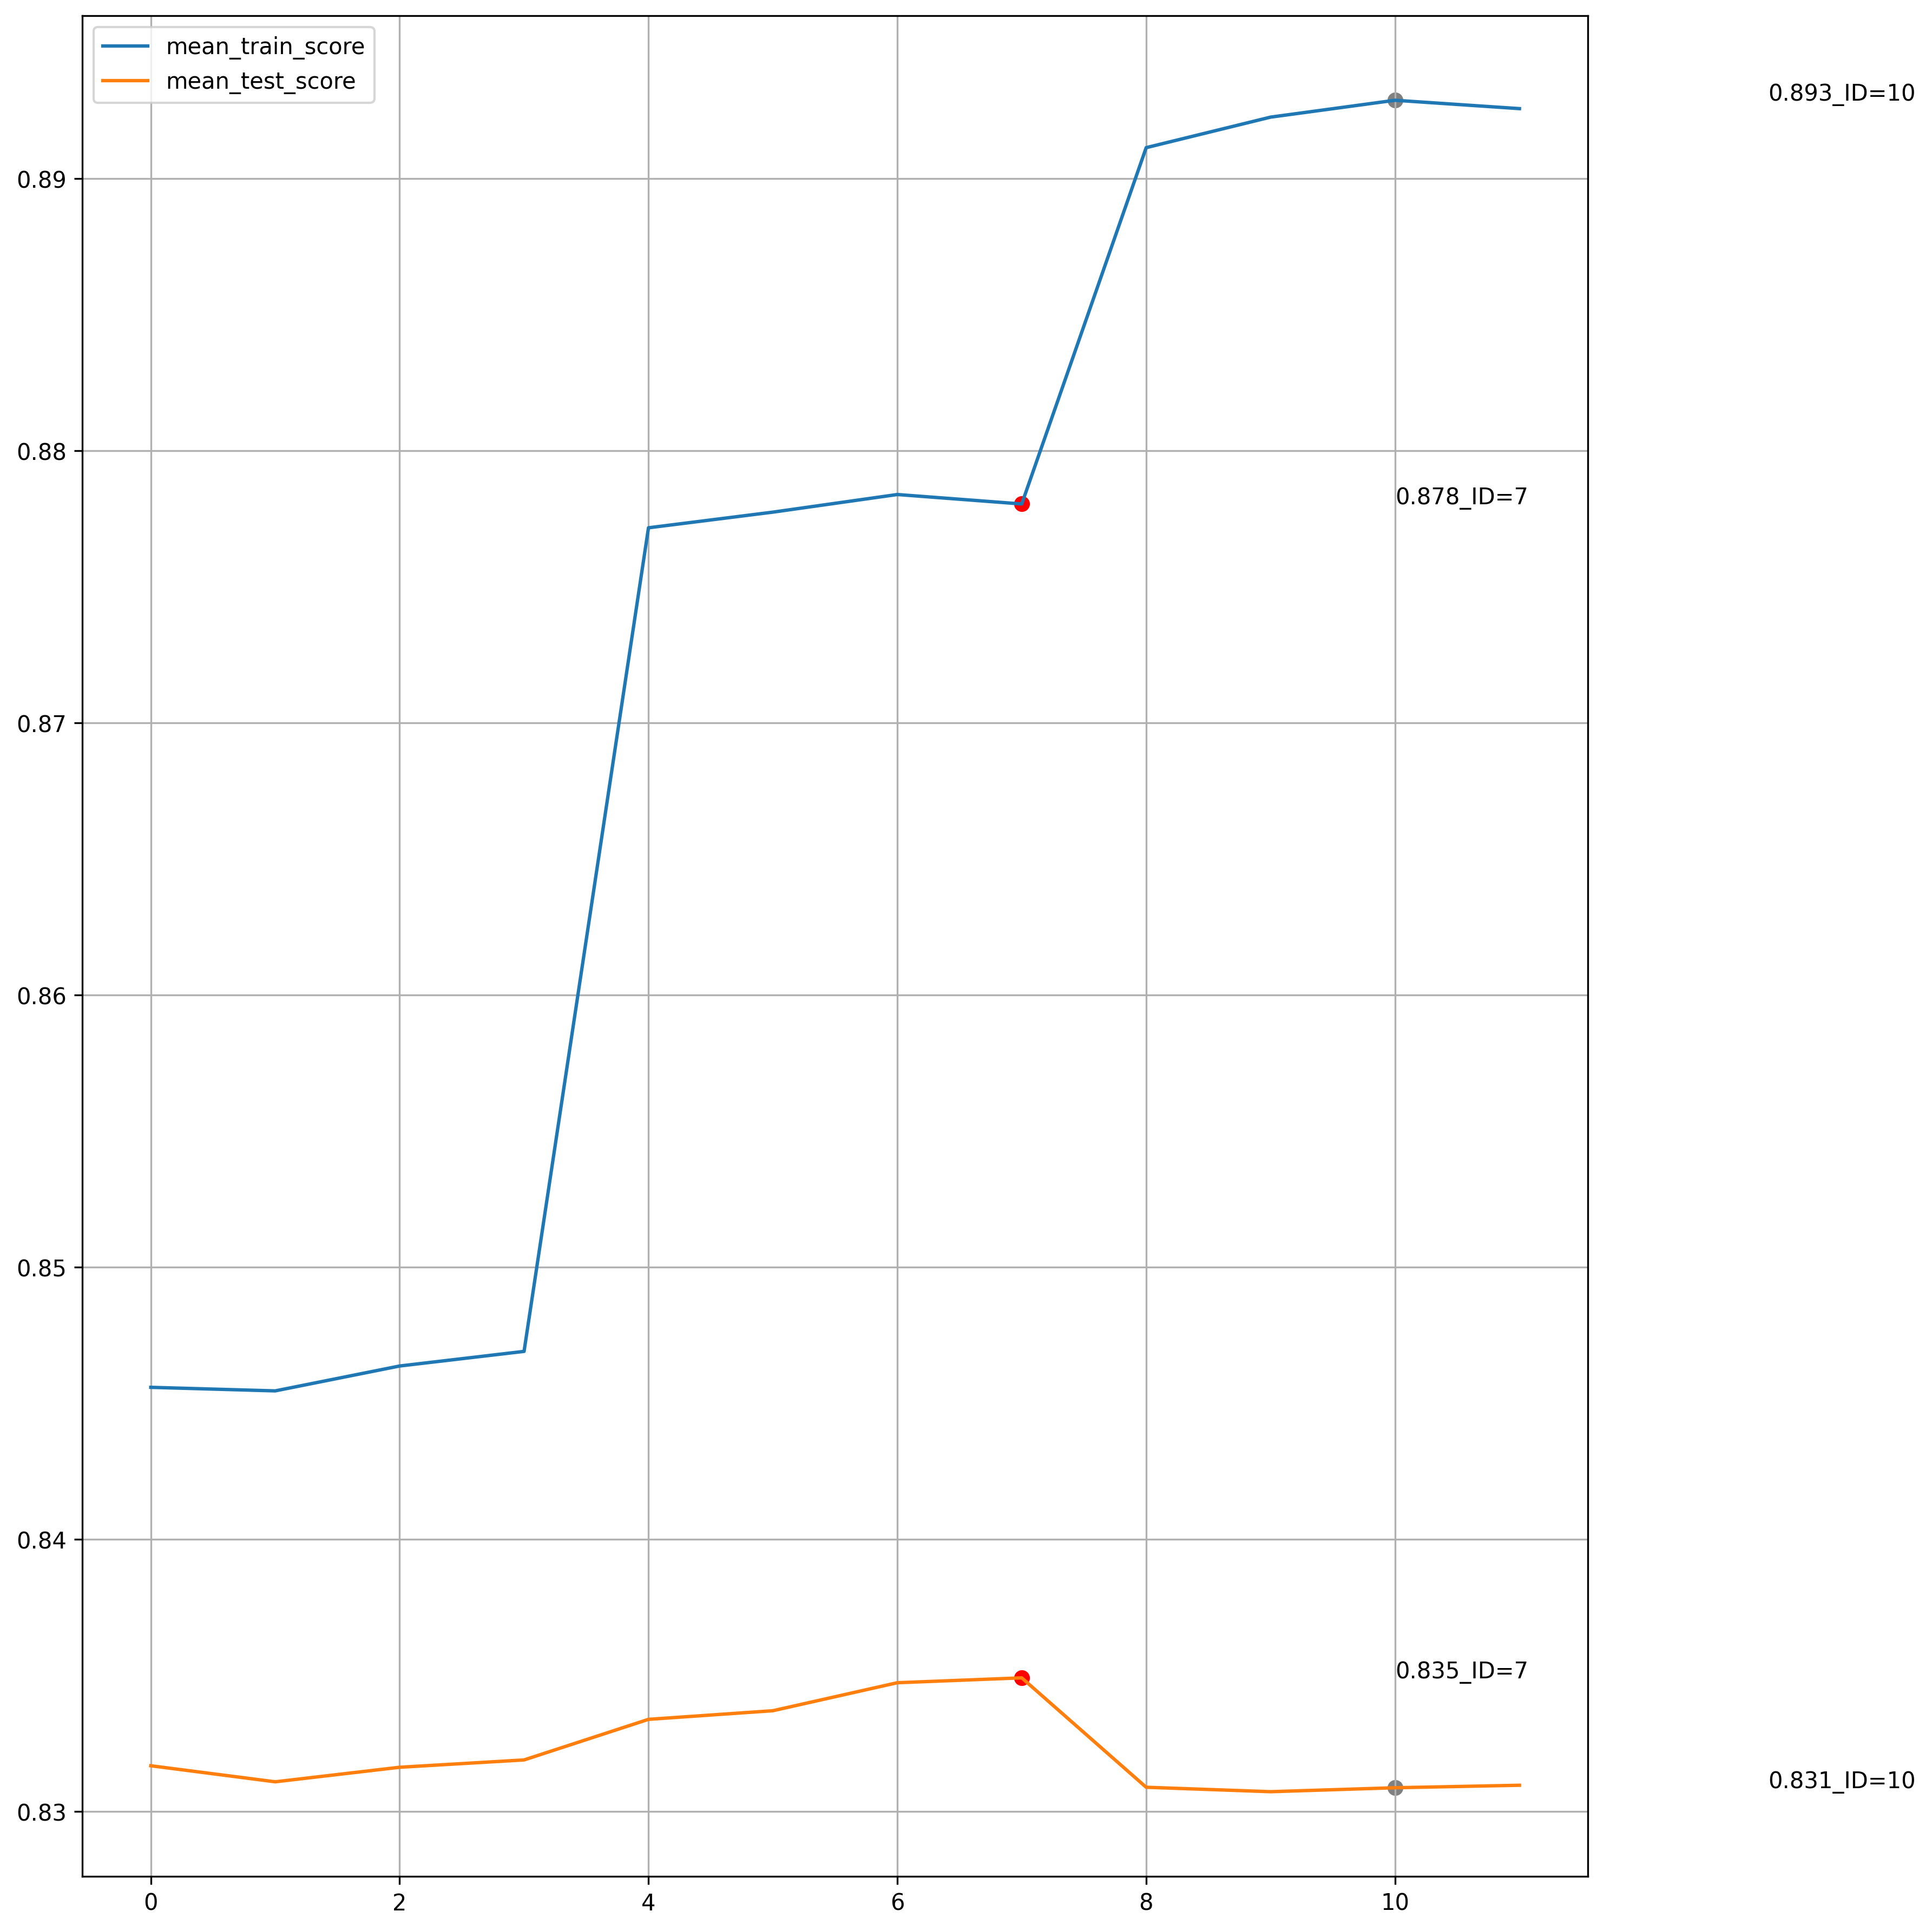

In [47]:
if rf_tuning:
    DisplayTuningGraph(scores)

scores

# AdaBoost

## AdaBoost - Training

In [27]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


# AdaBoost parameters with variable seed
params = {
    #"base_estimator": DecisionTreeClassifier(max_depth=4),  #  base estimator
    #"n_estimators": 643,  # Number of weak learners to train iteratively
    "base_estimator": DecisionTreeClassifier(max_depth=2),  #  base estimator
    "n_estimators": 643,  # Number of weak learners to train iteratively
    "random_state": 7,  # It will control the randomness of the algorithm
}

# Create and train the model
model = AdaBoostClassifier(
    **params,
)
model.fit(X_train, y_train)


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   n_estimators=200, random_state=7)

## AdaBoost - Validation

TN: 38487 <-- True Negatives
FP: 373 <-- False Positives
FN: 800 <-- False Negatives
TP: 5424 <-- True Positives
FPR:0.00959855892949048 <-- False Positive Rate
TPR:0.87146529562982 <-- True Positive Rate (same as Recall)
 
              precision    recall  f1-score   support

           0     0.9796    0.9904    0.9850     38860
           1     0.9357    0.8715    0.9024      6224

    accuracy                         0.9740     45084
   macro avg     0.9576    0.9309    0.9437     45084
weighted avg     0.9736    0.9740    0.9736     45084



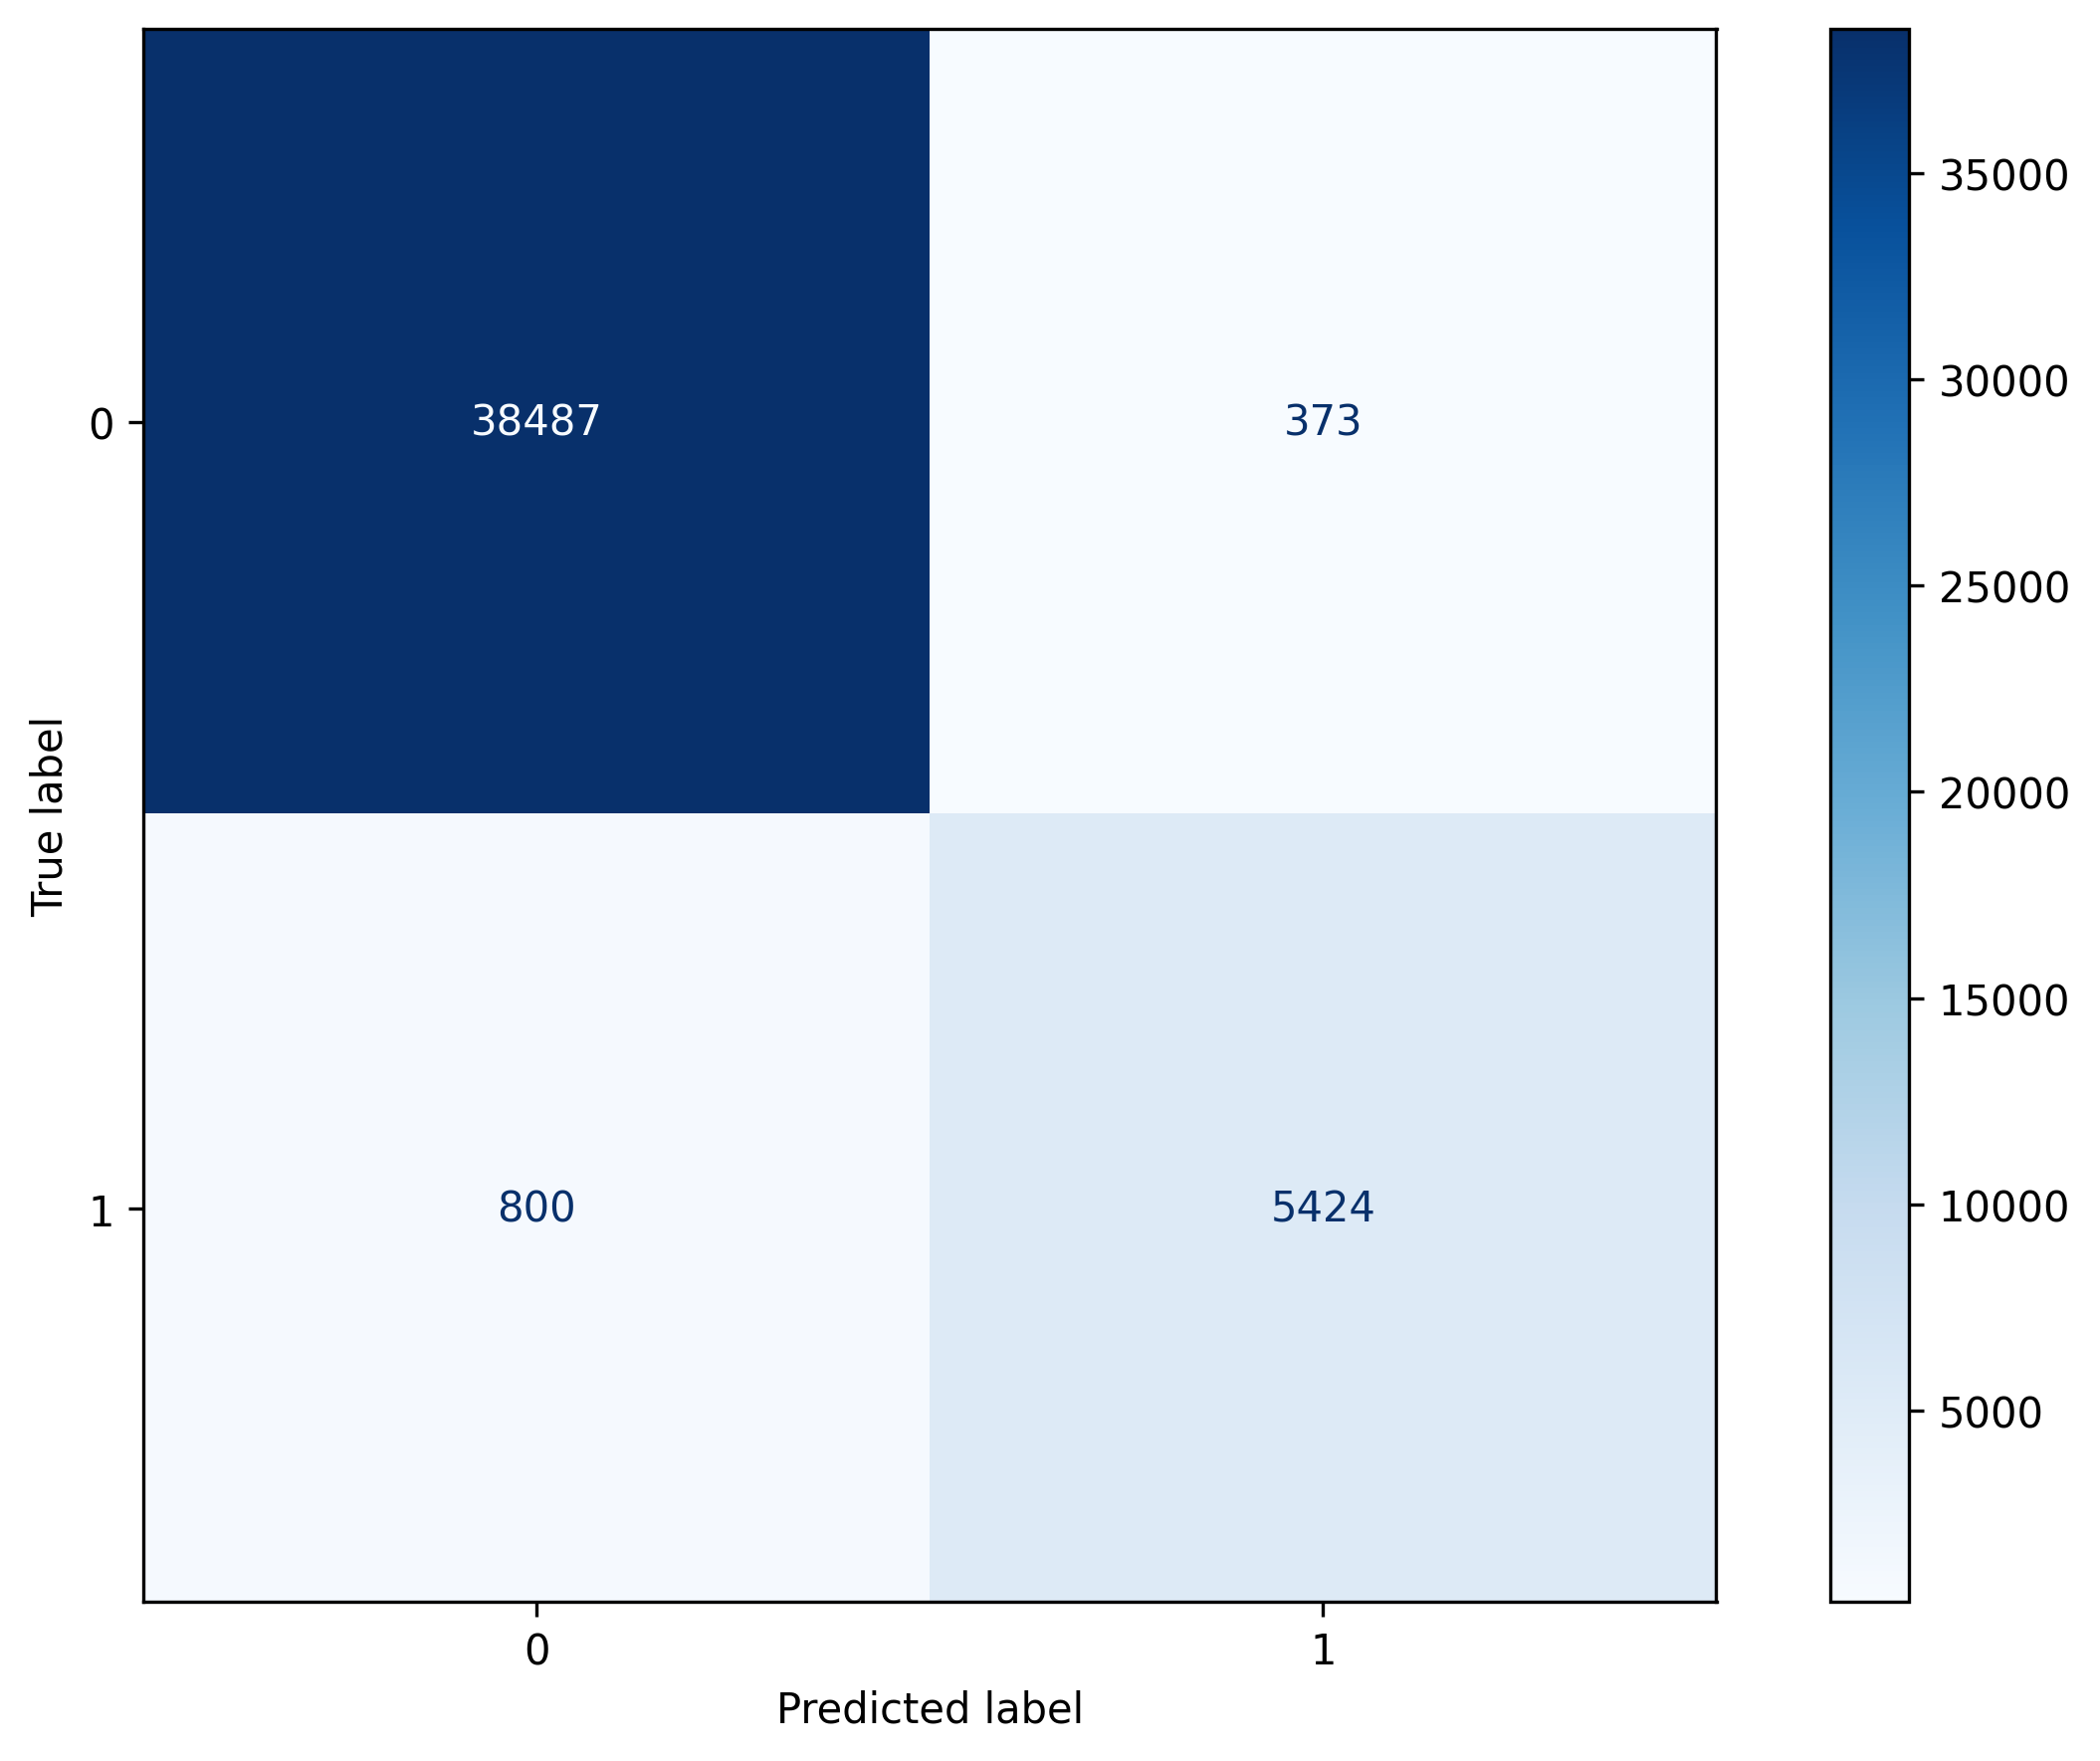

In [28]:
ValidateModel(X_test, y_test, model)

## AdaBoost - Tuning

In [73]:
ada_tuning = True

if ada_tuning:
    from sklearn.ensemble import AdaBoostClassifier
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
    import pandas as pd

    # Assuming df is your DataFrame and class_map maps your classes
    labels = df['label'].apply(lambda x: class_map[x])
    features = df.drop('label', axis=1)

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42, shuffle=True, stratify=labels)

    # AdaBoost base model parameters
    params = {
        "base_estimator": DecisionTreeClassifier(max_depth=4),  # Base estimator
        "random_state": 7
    }

    # AdaBoost base model
    ada = AdaBoostClassifier(**params)

    # Grid of parameters to search
    grid = {
        #"base_estimator": [DecisionTreeClassifier(max_depth=3), DecisionTreeClassifier(max_depth=4), DecisionTreeClassifier(max_depth=5)], 
        "n_estimators": [200, 400, 650],  # Number of weak learners to train iteratively
        #'learning_rate': [0.01, 0.1, 1.0],  # Learning rate shrinks the contribution of each classifier
        # Add other parameters here if needed
    }

    # Stratified K-Folds cross-validator
    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=7)

    # Grid Search
    grid_search = GridSearchCV(
        estimator=ada,
        param_grid=grid,
        cv=cv,
        #scoring='f1',  # You can change this to another scoring method if needed
        scoring=FETA_Score,  # Custom metric
        verbose=3,
        return_train_score=True
    )

    grid_search.fit(X_train, y_train)

    # Best estimator
    best_ada = grid_search.best_estimator_

    # Results
    scores = pd.DataFrame(grid_search.cv_results_)


Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV 1/2] END n_estimators=200;, score=(train=0.505, test=0.463) total time= 1.1min
[CV 2/2] END n_estimators=200;, score=(train=0.504, test=0.468) total time= 1.1min
[CV 1/2] END n_estimators=400;, score=(train=0.504, test=0.467) total time= 2.3min
[CV 2/2] END n_estimators=400;, score=(train=0.504, test=0.471) total time= 2.1min
[CV 1/2] END n_estimators=650;, score=(train=0.504, test=0.470) total time= 4.0min
[CV 2/2] END n_estimators=650;, score=(train=0.504, test=0.473) total time= 3.6min


In [ ]:
if ada_tuning:
    DisplayTuningGraph(scores)

scores

# XGBoost

## XGBoost - Training

In [40]:
from xgboost import XGBClassifier
# uncomment the two disabled lines to use GPU
params = {
    "max_depth": 9,
    "eta": 0.15,
    "objective": "binary:logistic",
    "tree_method": "gpu_hist",
    "min_child_weight": 2.0,
    "subsample": 0.6,
    "sampling_method": "gradient_based",
    "alpha": 0,
    "gamma": 0.1,
    "lambda": 1.0,
    "max_delta_step": 0,
    "grow_policy": "lossguide",
    "max_bin": 512,
    "n_estimators": 550,
    
    "random_state": 7,
    
    
    "scale_pos_weight": 4.5,
}

model = XGBClassifier(
  **params,
  eval_metric=["error", "logloss", "auc"]
)

# at last, train the model
eval_set = [(X_train, y_train), (X_test, y_test)]
_ = model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

## XGBoost - Validation

              precision    recall  f1-score   support

           0     0.9953    0.9973    0.9963    129772
           1     0.9824    0.9703    0.9763     20506

    accuracy                         0.9936    150278
   macro avg     0.9889    0.9838    0.9863    150278
weighted avg     0.9936    0.9936    0.9936    150278

Confusion Matrix:
TN: 129416 FP: 356 FN: 609 TP: 19897


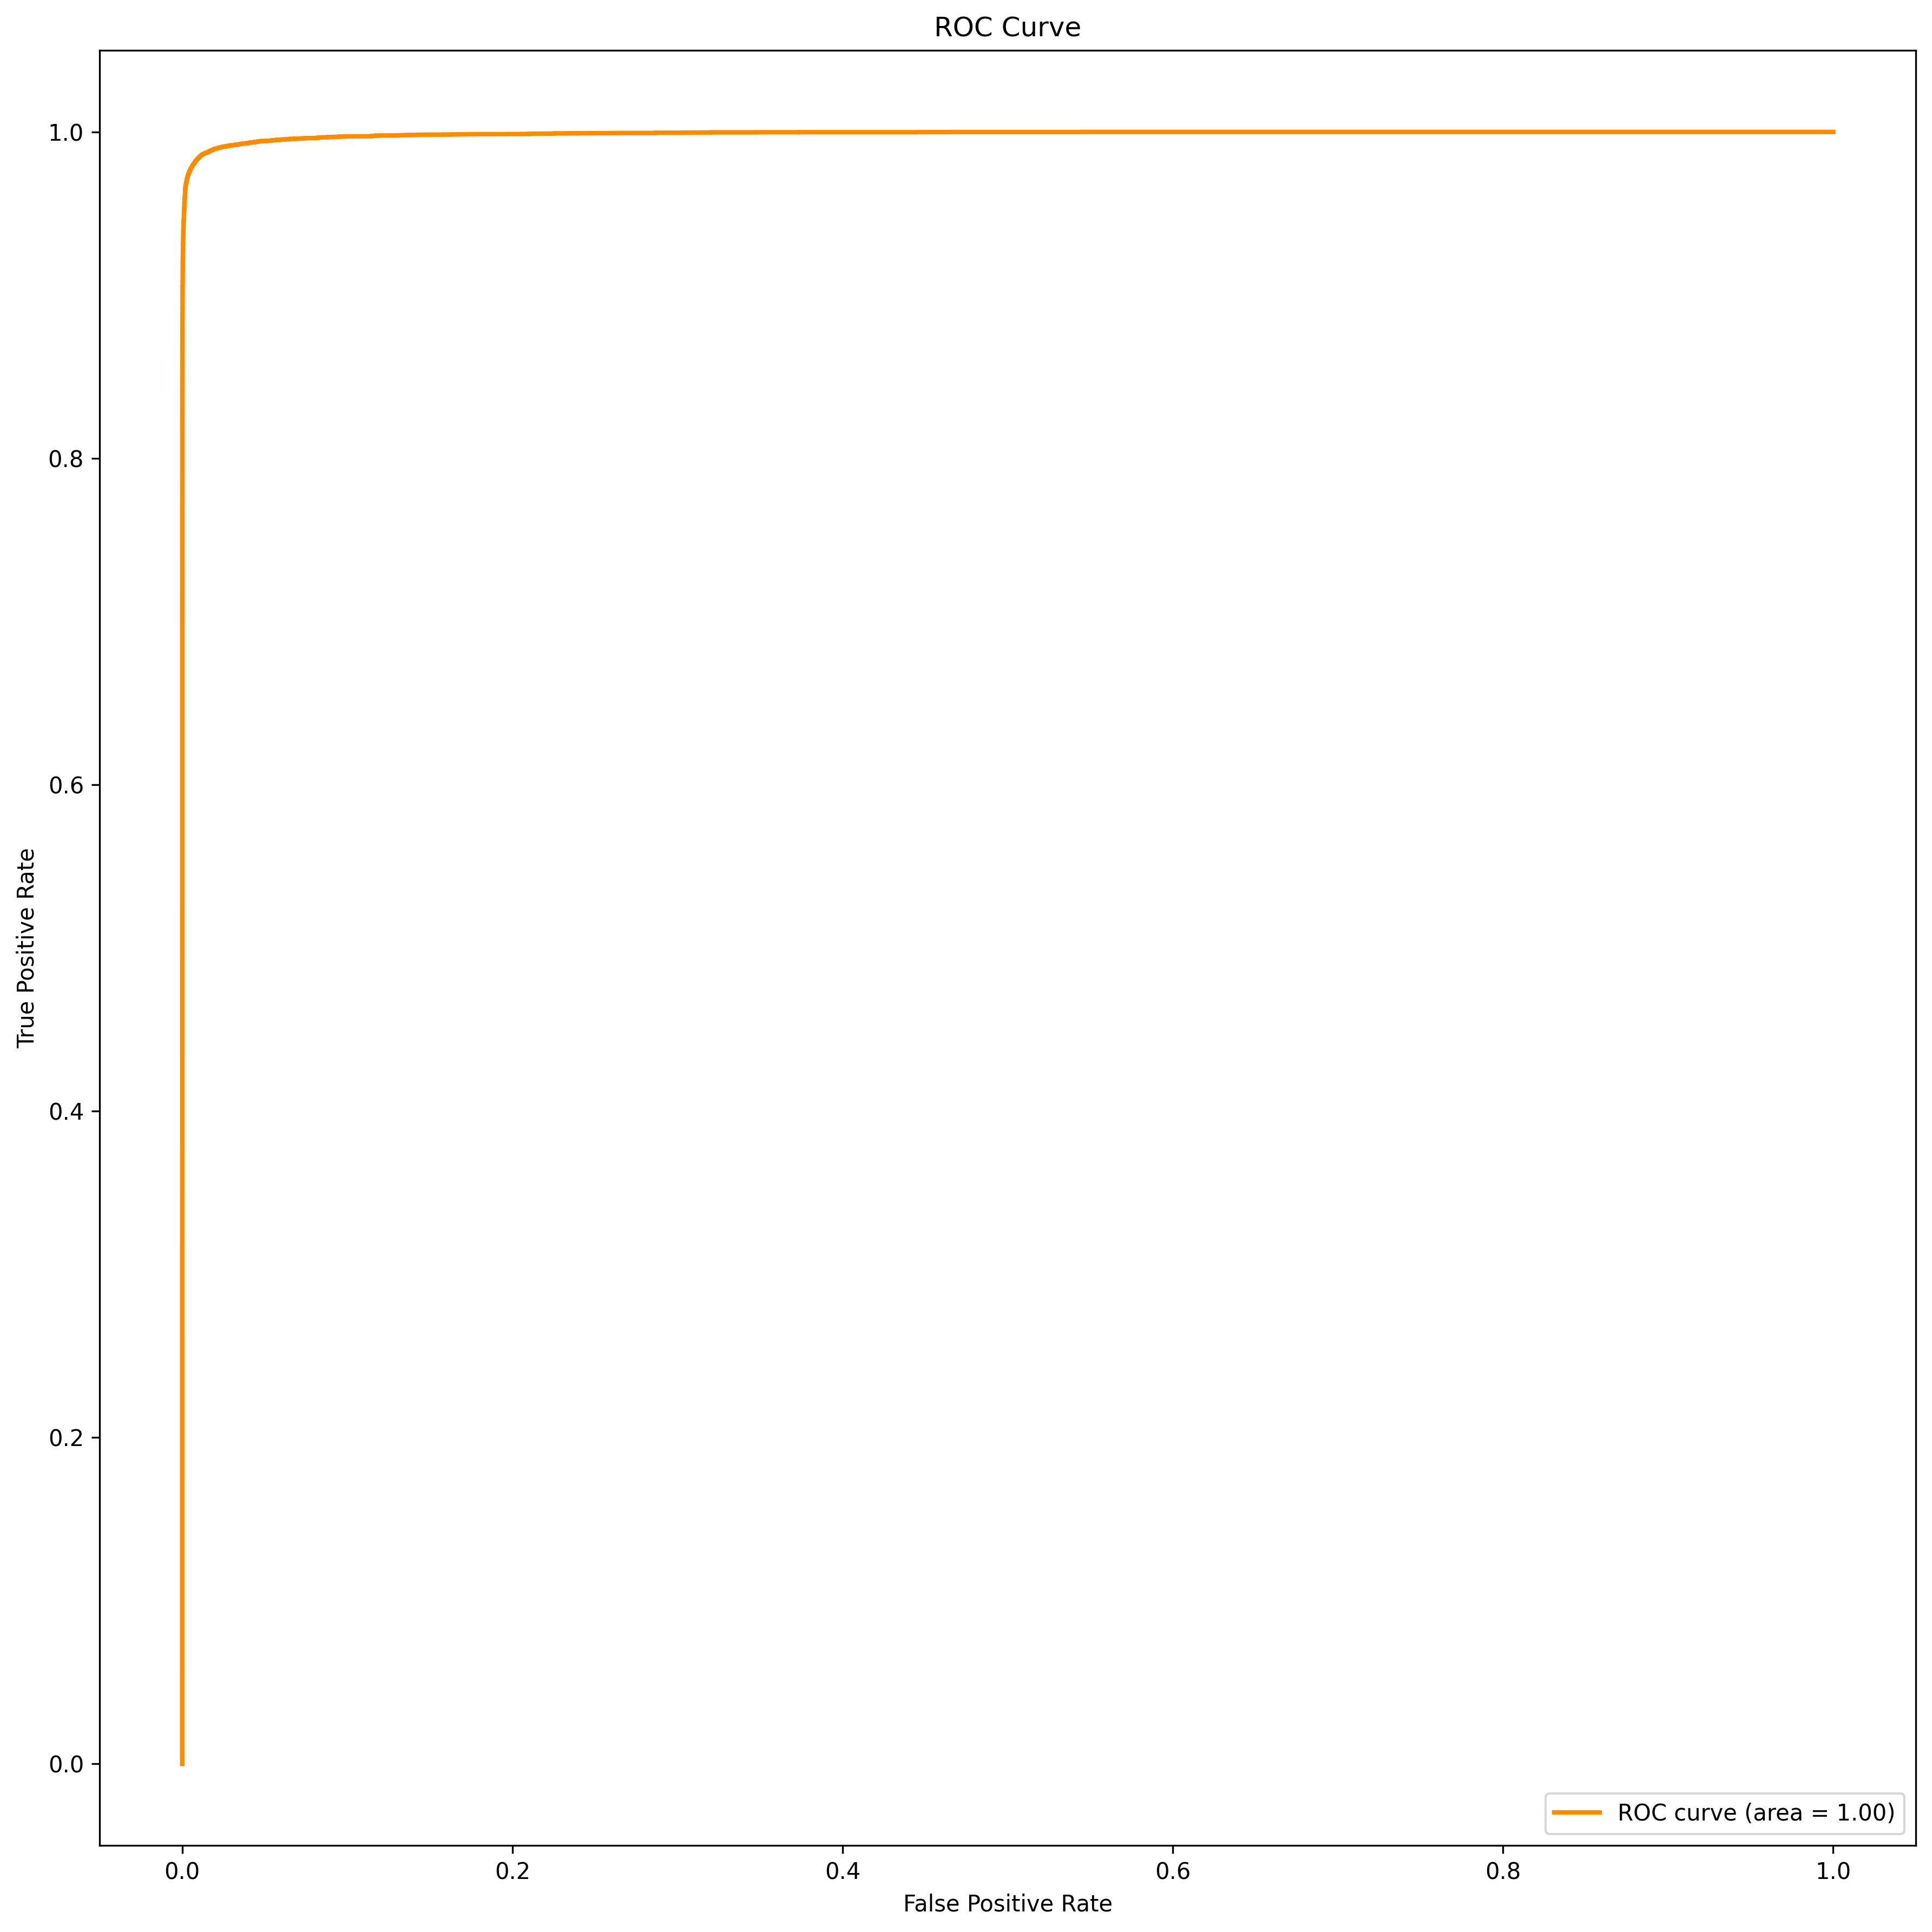

Training metrics: odict_keys(['error', 'logloss', 'auc'])
Validation metrics: odict_keys(['error', 'logloss', 'auc'])


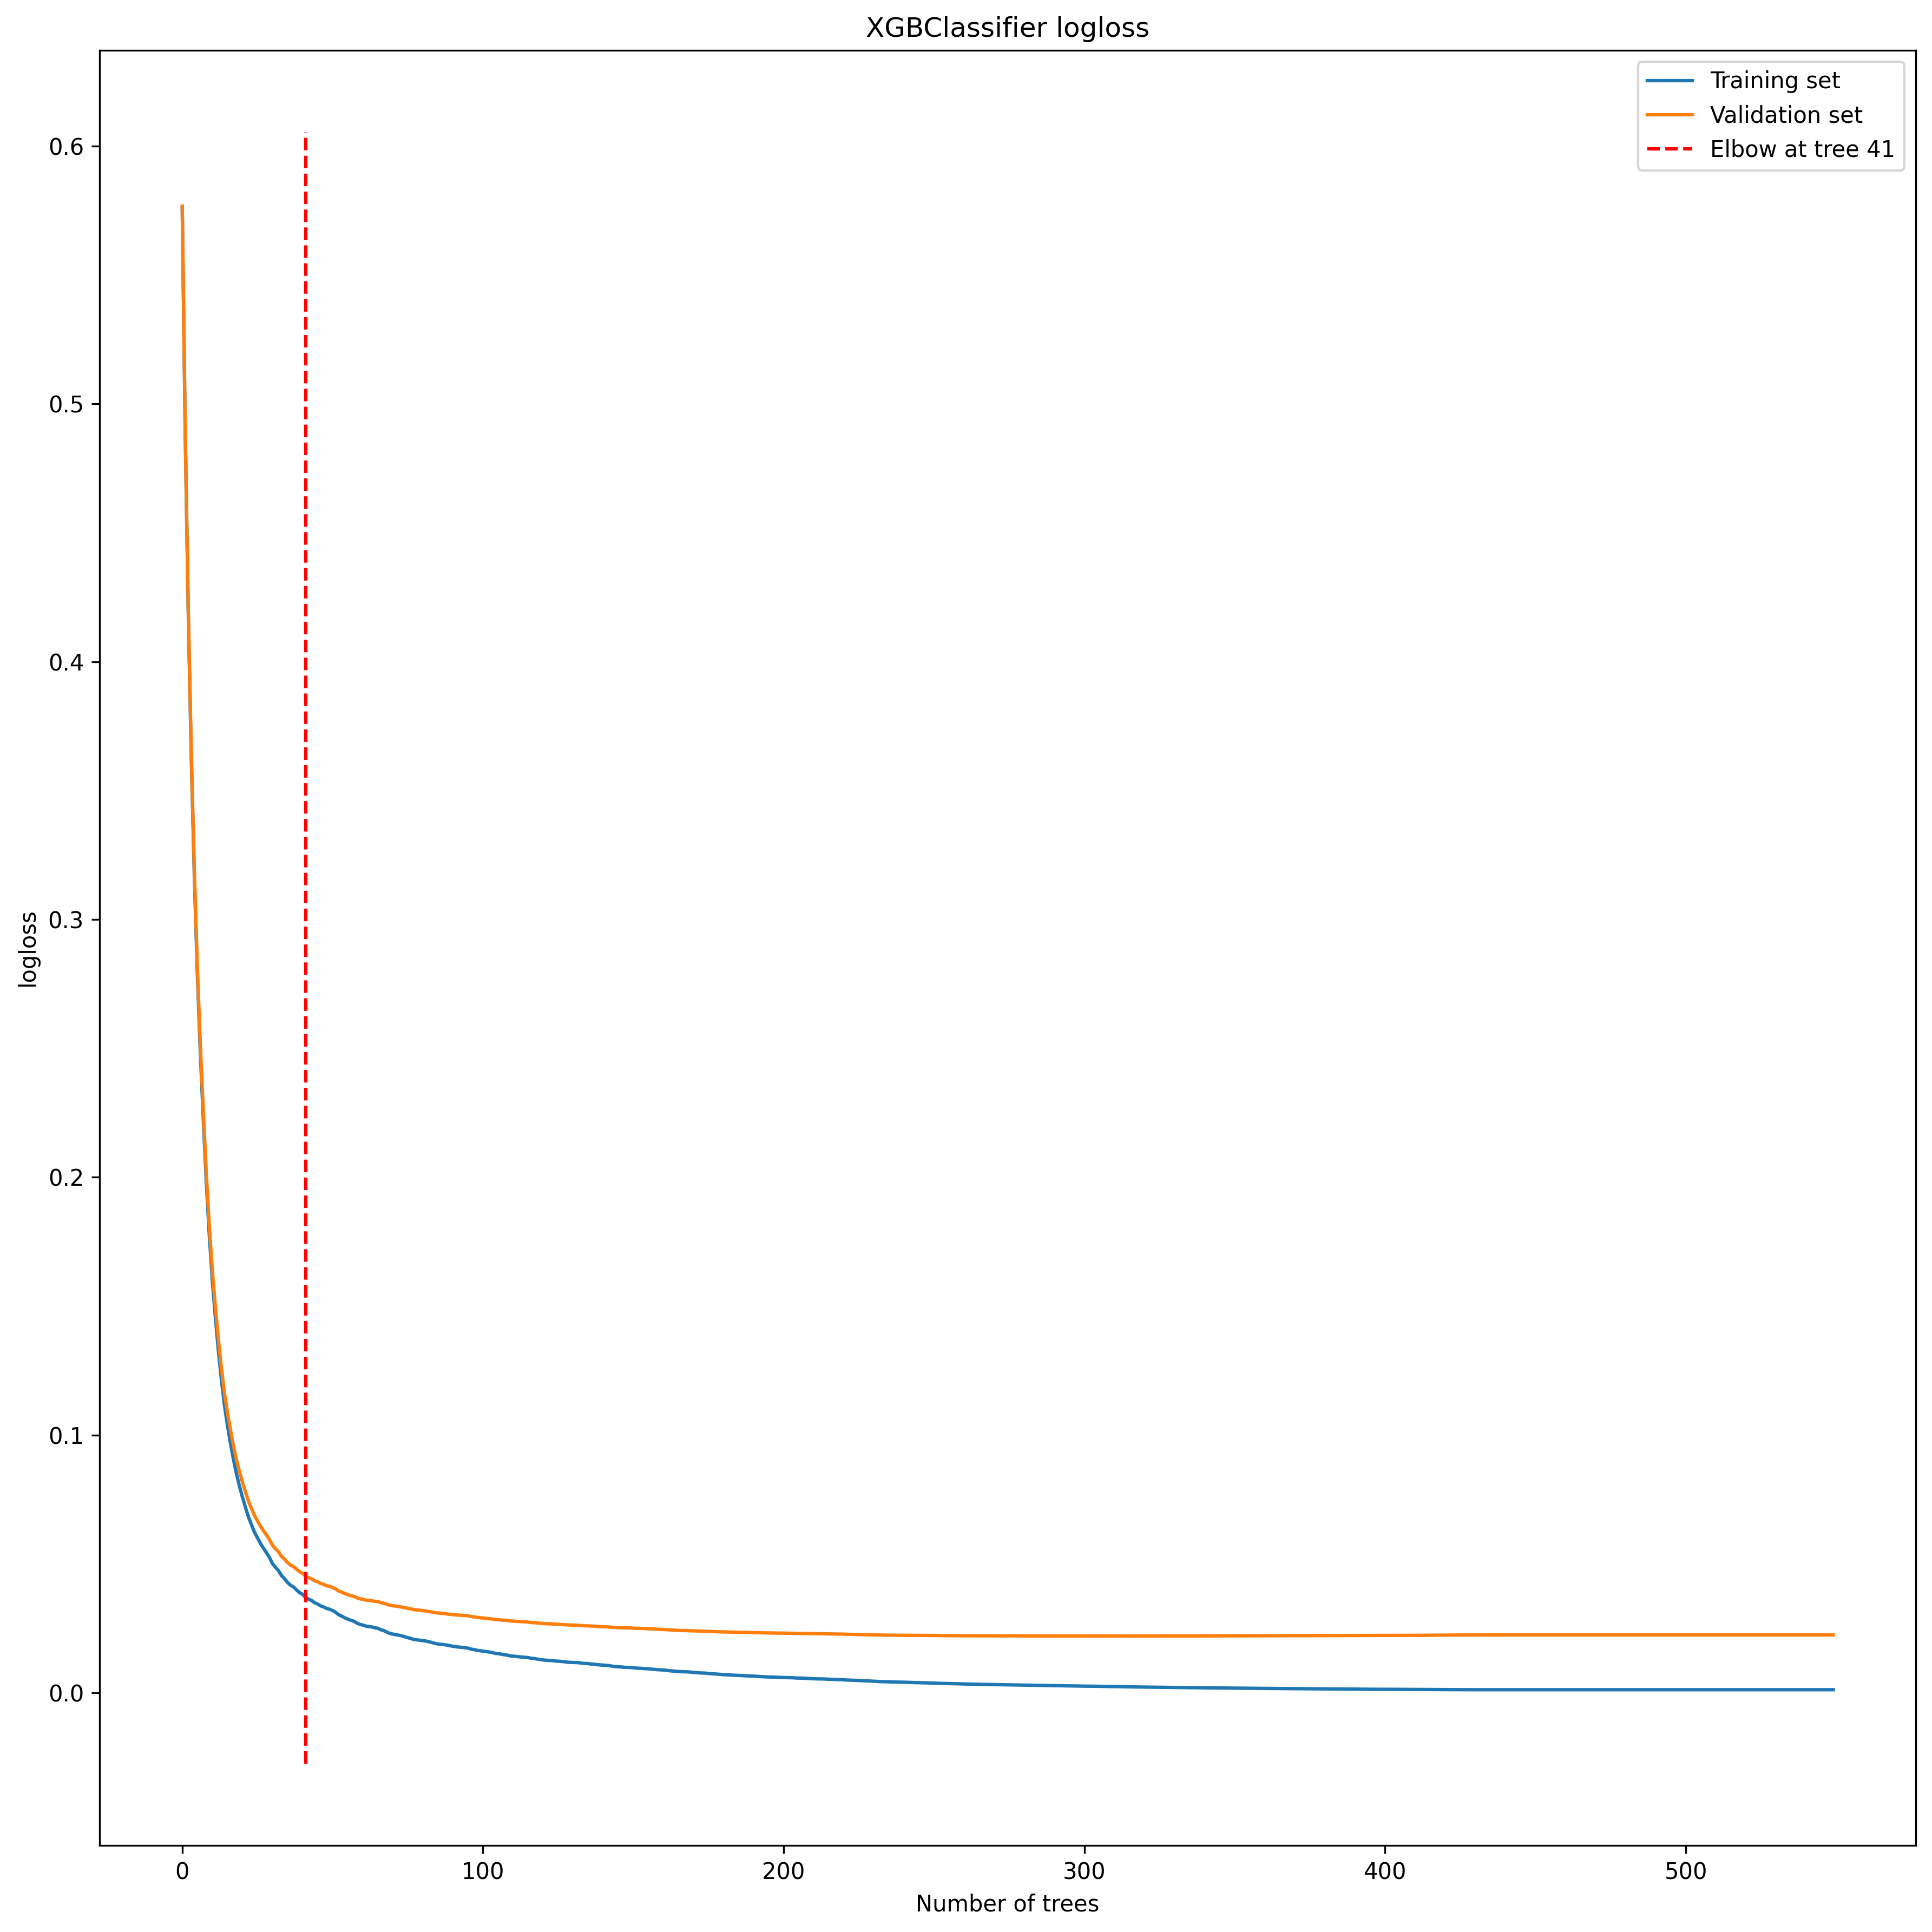

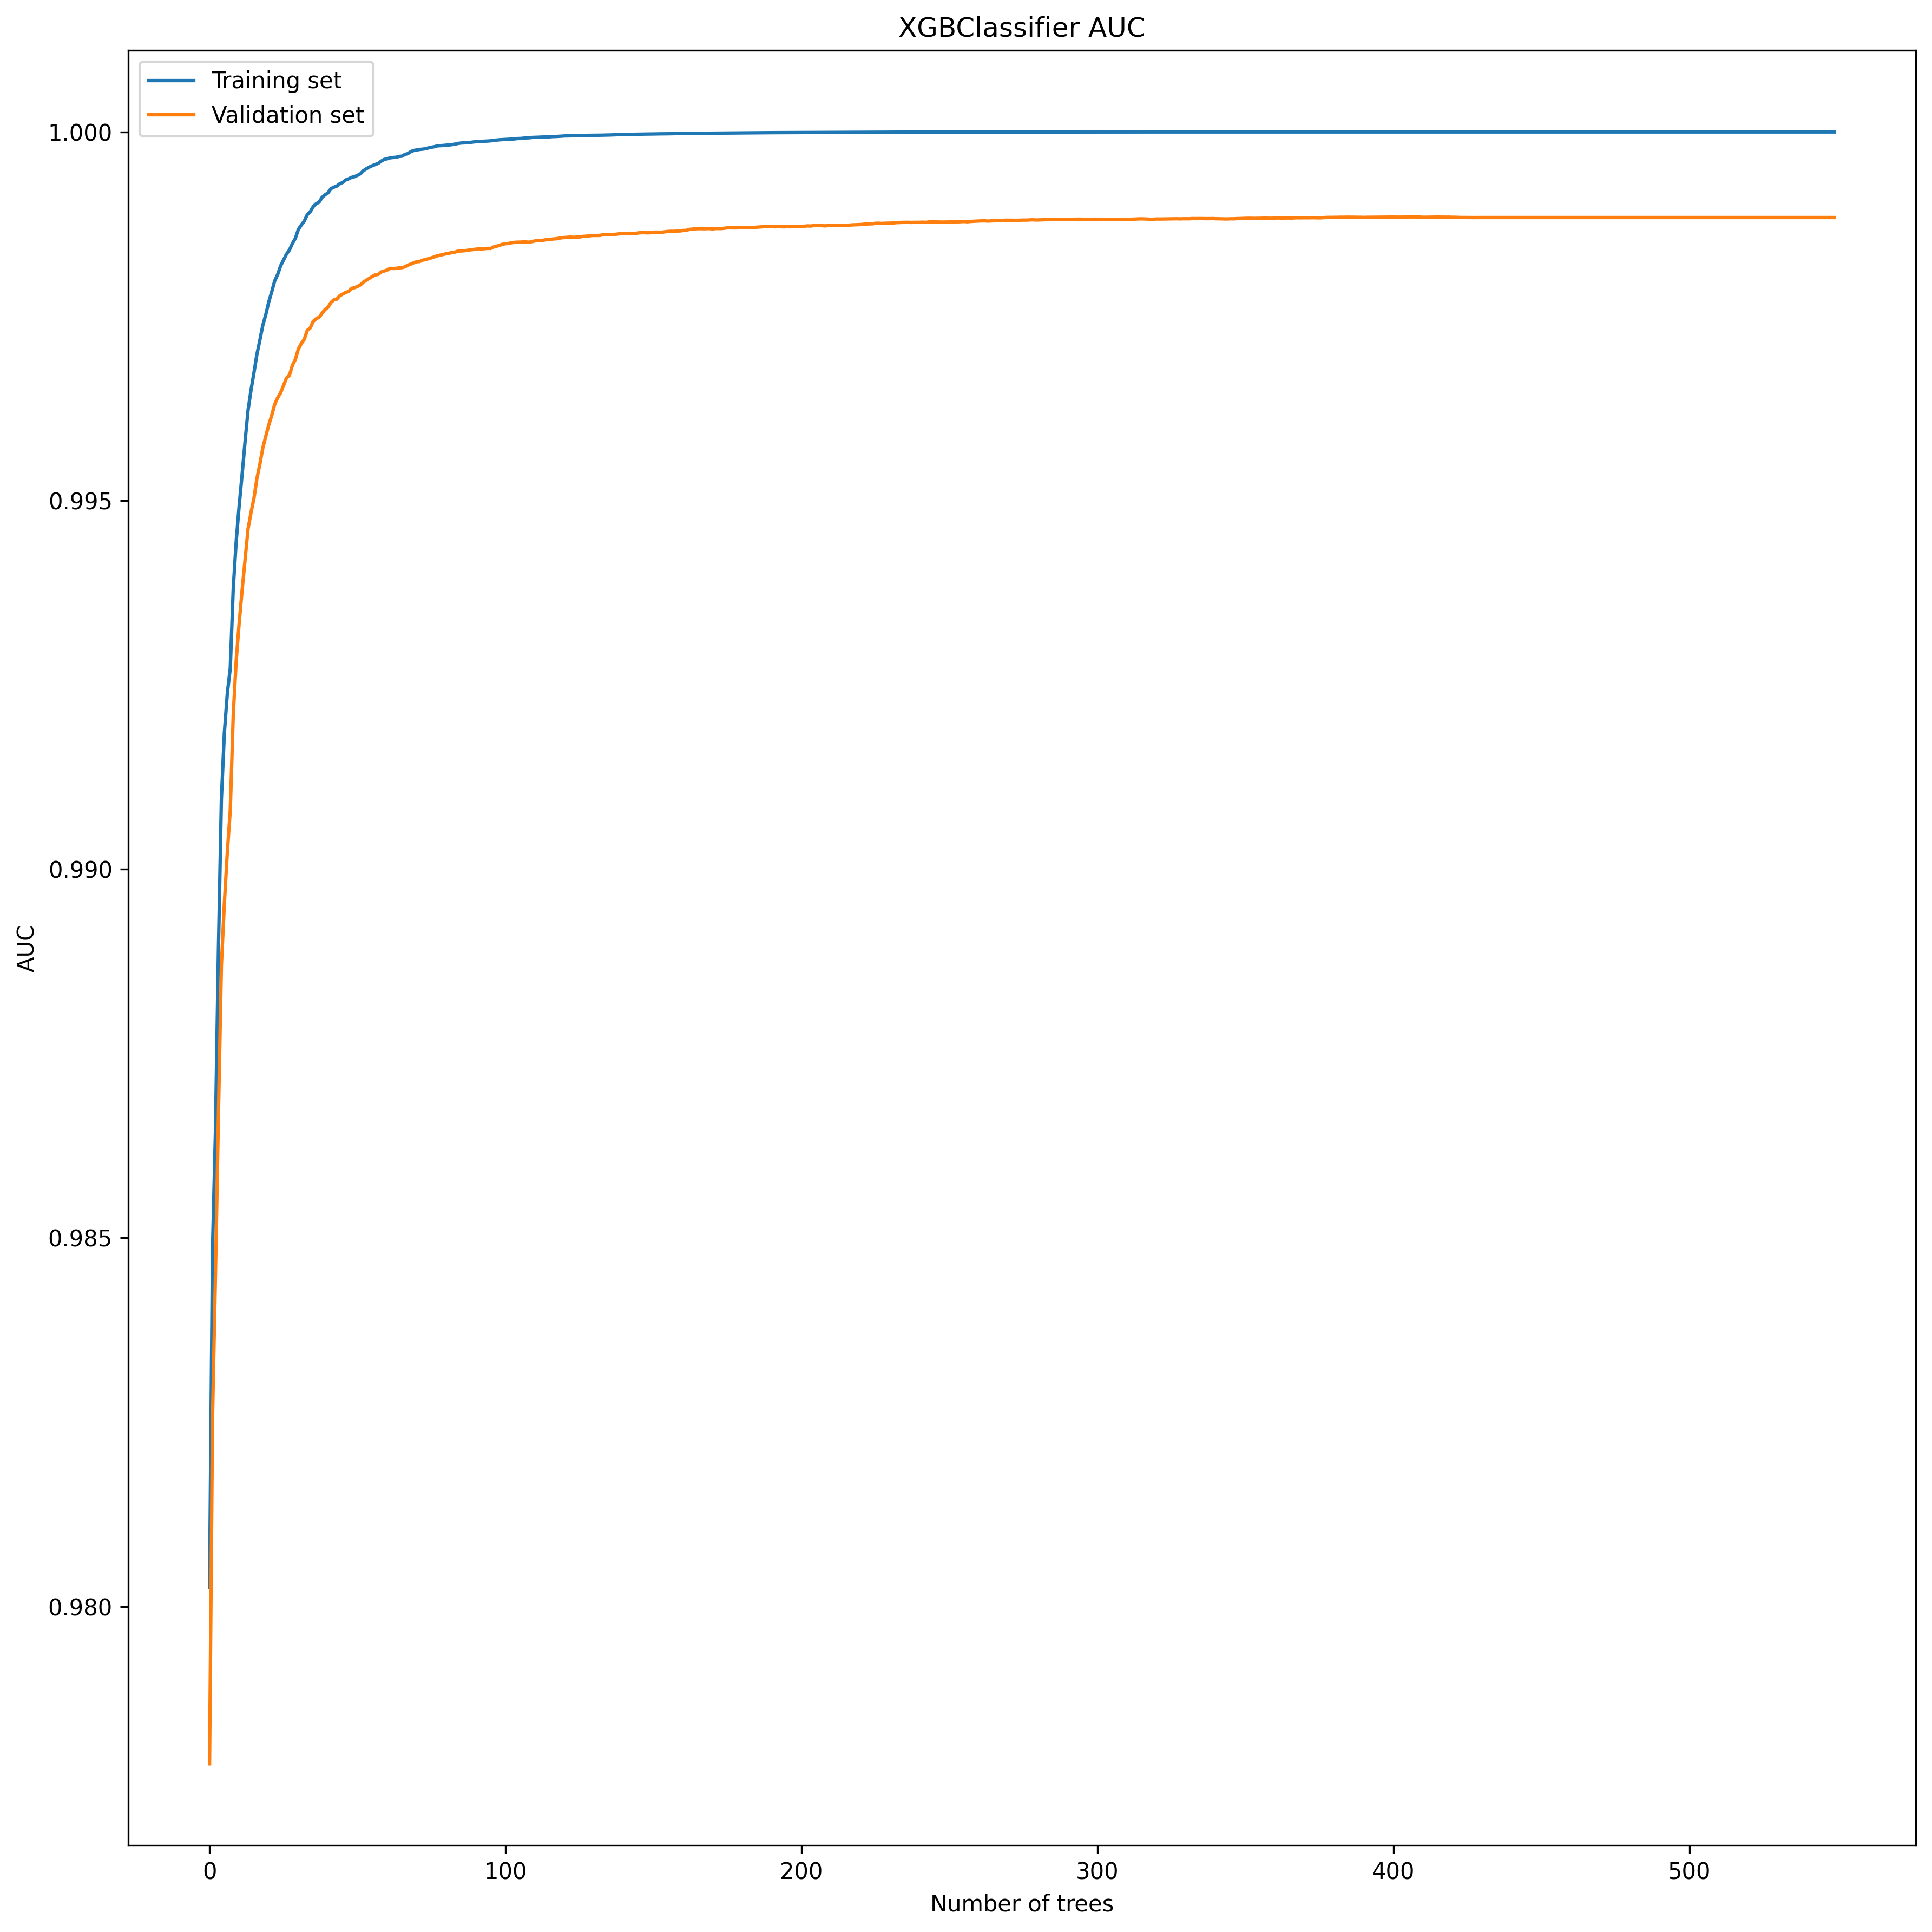

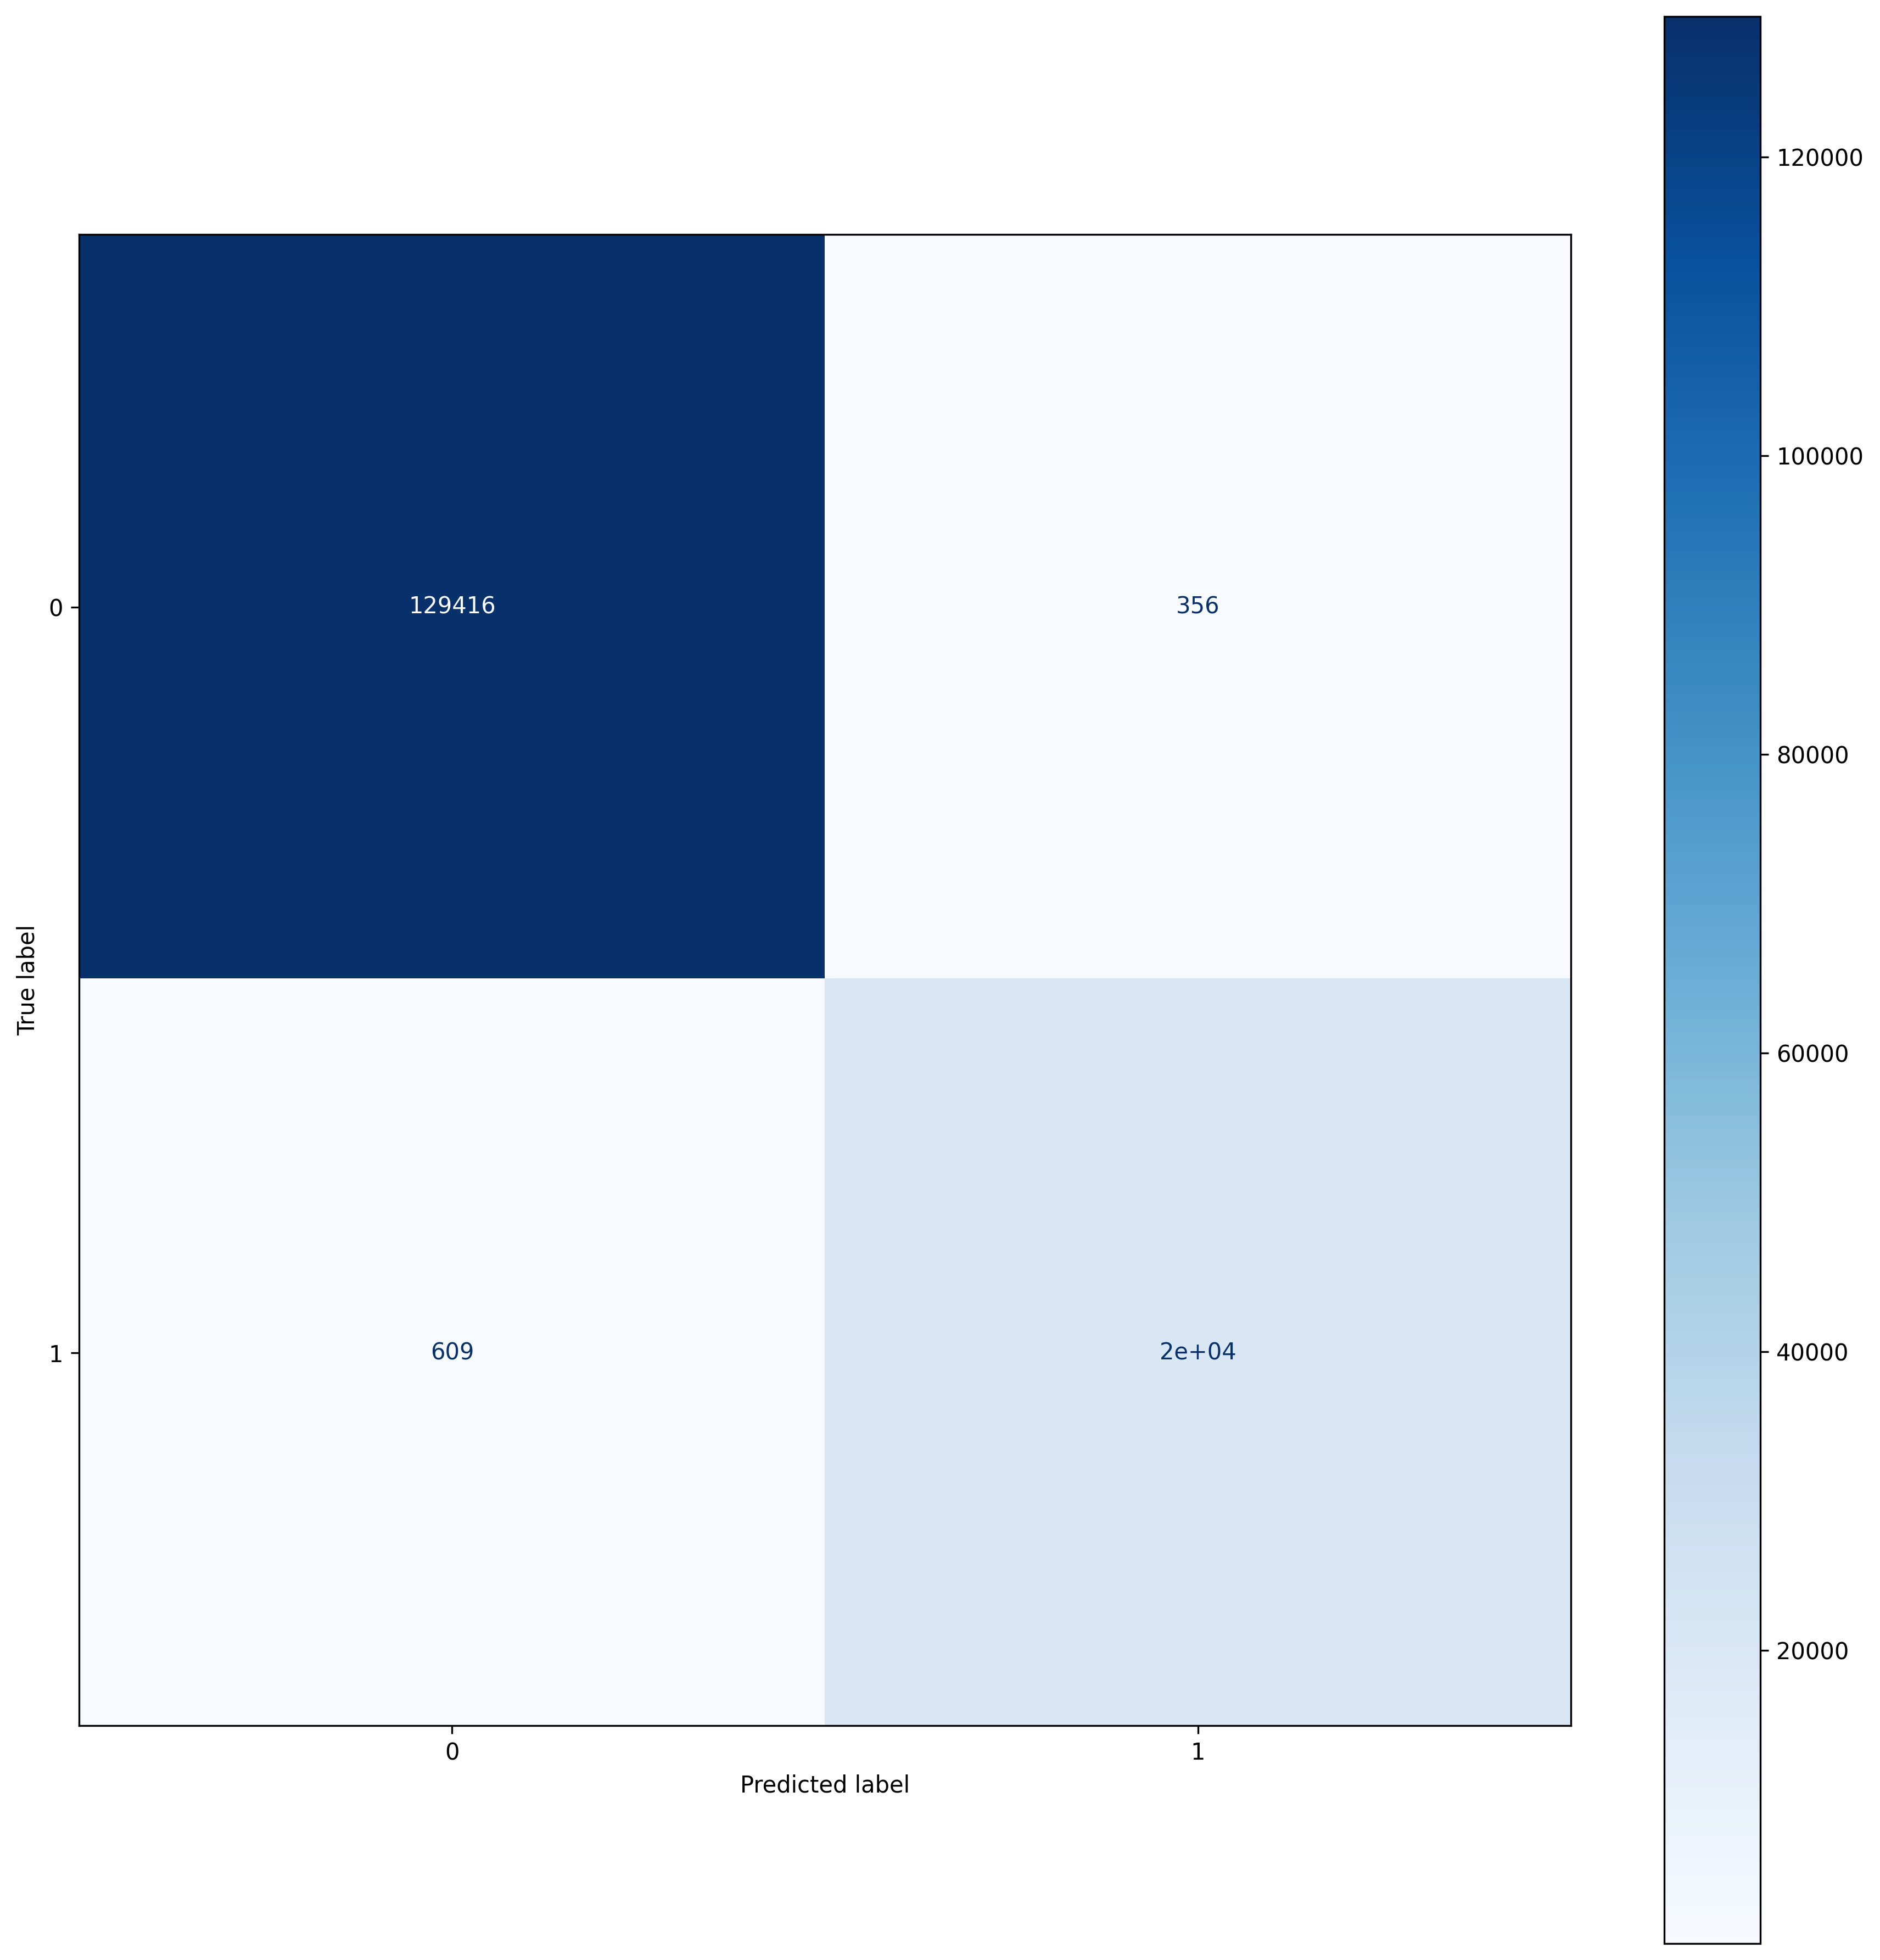

In [41]:
ValidateModel_advanced(X_test, y_test, model)

## XGBoost - Tuning

In [37]:
xgb_tuning = True

if xgb_tuning:
    from xgboost import XGBClassifier
    from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
    import pandas as pd

    # Assuming df is your DataFrame and class_map maps your classes
    labels = df['label'].apply(lambda x: class_map[x])
    features = df.drop('label', axis=1).copy()

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42, shuffle=True, stratify=labels)

    params = {
        "max_depth": 9,
        "eta": 0.15,
        "objective": "binary:logistic",
        "tree_method": "gpu_hist",
        "min_child_weight": 2.0,
        "subsample": 0.6,
        "sampling_method": "gradient_based",
        "alpha": 0,
        "gamma": 0.1,
        "lambda": 1.0,
        "max_delta_step": 0,
        "grow_policy": "lossguide",
        "max_bin": 512,
        "n_estimators": 550,
        "eval_metric": ["error", "logloss", "auc"],
        "random_state": 7
    }
    
    # XGBoost base model
    xgb = XGBClassifier(**params)
    
    # Grid of parameters to search    
    grid = {
        'scale_pos_weight': [1, 2, 3, 4, 4.5, 5, 5.2, 6.28],
        # Add other parameters here if needed
    }
    

    # Stratified K-Folds cross-validator
    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=7)

    # Grid Search
    grid_search = GridSearchCV(
        estimator=xgb,
        param_grid=grid,
        cv=cv,
        #scoring='f1',  # You can change this to another scoring method if needed
        scoring=FETA_Score,  # Custom metric
        verbose=3,
        return_train_score=True
    )

    grid_search.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

    # Best estimator
    best_xgb = grid_search.best_estimator_

    # Results
    scores = pd.DataFrame(grid_search.cv_results_)


Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV 1/2] END scale_pos_weight=1;, score=(train=0.900, test=0.870) total time=  19.3s
[CV 2/2] END scale_pos_weight=1;, score=(train=0.900, test=0.870) total time=  19.5s
[CV 1/2] END scale_pos_weight=2;, score=(train=0.900, test=0.871) total time=  19.9s
[CV 2/2] END scale_pos_weight=2;, score=(train=0.900, test=0.871) total time=  19.8s
[CV 1/2] END scale_pos_weight=3;, score=(train=0.900, test=0.872) total time=  20.3s
[CV 2/2] END scale_pos_weight=3;, score=(train=0.900, test=0.872) total time=  20.2s
[CV 1/2] END scale_pos_weight=4;, score=(train=0.900, test=0.873) total time=  20.5s
[CV 2/2] END scale_pos_weight=4;, score=(train=0.900, test=0.872) total time=  20.3s
[CV 1/2] END scale_pos_weight=4.5;, score=(train=0.900, test=0.873) total time=  20.5s
[CV 2/2] END scale_pos_weight=4.5;, score=(train=0.900, test=0.873) total time=  20.7s
[CV 1/2] END scale_pos_weight=5;, score=(train=0.900, test=0.872) total time=  20.5s
[

   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      15.154472      0.078794         4.273883        0.019089   
1      15.565898      0.035877         4.287163        0.007265   
2      15.940080      0.027580         4.317130        0.000176   
3      16.069557      0.052413         4.323189        0.008017   
4      16.264899      0.086074         4.333006        0.012213   
5      16.228921      0.015535         4.322449        0.005185   
6      16.318663      0.161983         4.317556        0.017208   
7      16.545114      0.045846         4.386091        0.000960   

  param_scale_pos_weight                      params  split0_test_score  \
0                      1     {'scale_pos_weight': 1}           0.870416   
1                      2     {'scale_pos_weight': 2}           0.871459   
2                      3     {'scale_pos_weight': 3}           0.872062   
3                      4     {'scale_pos_weight': 4}           0.872597   
4                    

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      15.154472      0.078794         4.273883        0.019089   
1      15.565898      0.035877         4.287163        0.007265   
2      15.940080      0.027580         4.317130        0.000176   
3      16.069557      0.052413         4.323189        0.008017   
4      16.264899      0.086074         4.333006        0.012213   
5      16.228921      0.015535         4.322449        0.005185   
6      16.318663      0.161983         4.317556        0.017208   
7      16.545114      0.045846         4.386091        0.000960   

  param_scale_pos_weight                      params  split0_test_score  \
0                      1     {'scale_pos_weight': 1}           0.870416   
1                      2     {'scale_pos_weight': 2}           0.871459   
2                      3     {'scale_pos_weight': 3}           0.872062   
3                      4     {'scale_pos_weight': 4}           0.872597   
4                    4.5   {'scale_pos_weight': 4.5}           0.872746   
5                      5     {'scale_pos_weight': 5}           0.872357   
6                    5.2   {'scale_pos_weight': 5.2}           0.871855   
7                   6.28  {'scale_pos_weight': 6.28}           0.873058   

   split1_test_score  mean_test_score  std_test_score  rank_test_score  \
0           0.870387         0.870402        0.000014                8   
1           0.871120         0.871290        0.000169                7   
2           0.872213         0.872137        0.000075                5   
3           0.872184         0.872390        0.000207                3   
4           0.872721         0.872734        0.000013                1   
5           0.871916         0.872136        0.000220                6   
6           0.872531         0.872193        0.000338                4   
7           0.871956         0.872507        0.000551                2   

   split0_train_score  split1_train_score  mean_train_score  std_train_score  
0            0.900126            0.900397          0.900261         0.000135  
1            0.900354            0.900375          0.900364         0.000011  
2            0.900314            0.900378          0.900346         0.000032  
3            0.900326            0.900364          0.900345         0.000019  
4            0.900290            0.900356          0.900323         0.000033  
5            0.900296            0.900370          0.900333         0.000037  
6            0.900321            0.900377          0.900349         0.000028  
7            0.900289            0.900355          0.900322         0.000033

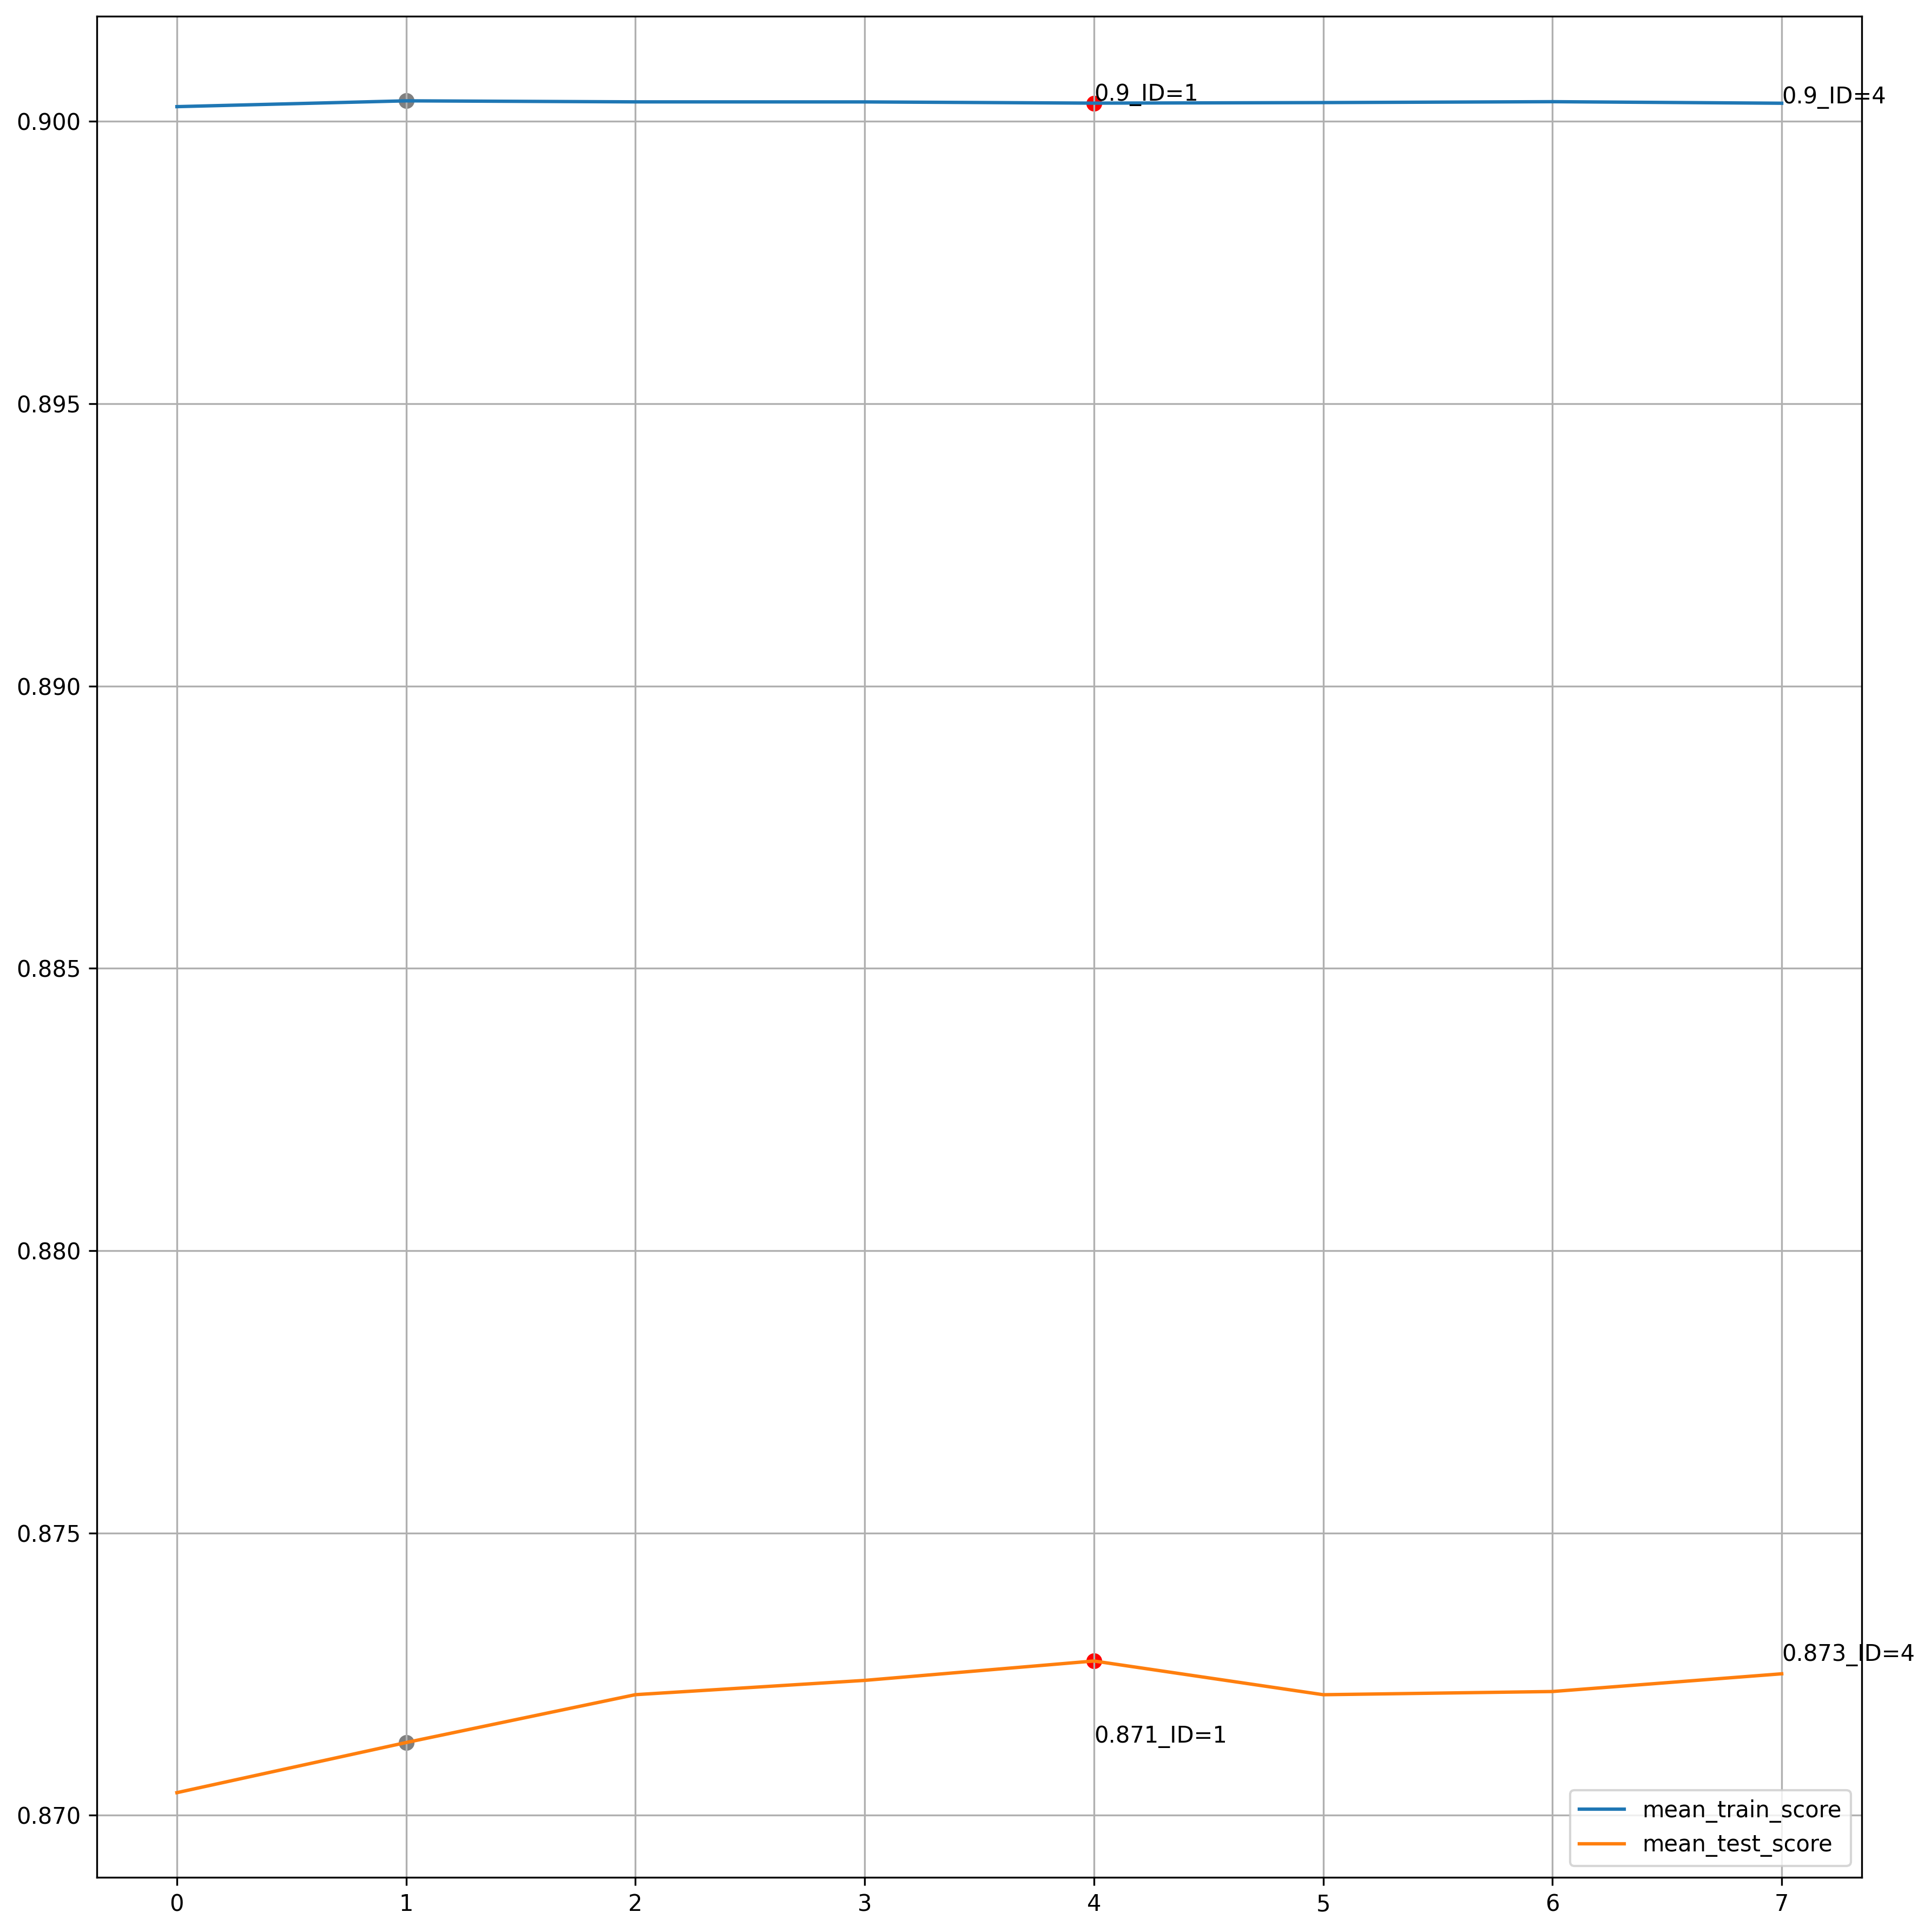

In [39]:
if xgb_tuning:
    DisplayTuningGraph(scores)

scores

# LightGBM

In [46]:
## LightGBM - Training

In [47]:
import warnings

# Suppress specific FutureWarnings from XGBoost
warnings.filterwarnings('ignore', category=FutureWarning, module='xgboost.*')
# Suppress specific FutureWarnings from Sklearn
warnings.filterwarnings('ignore', category=FutureWarning, module='sklearn.*')

import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# LightGBM parameters
params = {
    "objective": "binary",  # binary classification
    "boosting_type": "gbdt",  # Gradient Boosting Decision Tree
    "n_estimators": 897, # Number of boosted trees to fit, equivalent to number of boosting iterations
    "num_leaves": 59,
    "max_depth": 17,
    "learning_rate": 0.15,
    "objective": "binary",
    "min_child_samples": 27,
    "colsample_bytree": 0.9,
    "reg_lambda": 0.11,
    "scale_pos_weight": 1.1, # default: 1.0
    "subsample_for_bin": 240000,
    "random_state": 7,
}

model = lgb.LGBMClassifier(**params)

eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_set=eval_set)



[LightGBM] [Info] Number of positive: 47847, number of negative: 302800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021796 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12392
[LightGBM] [Info] Number of data points in the train set: 350647, number of used features: 135
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.136453 -> initscore=-1.845064
[LightGBM] [Info] Start training from score -1.845064
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier(colsample_bytree=0.9, max_depth=10,
               metric=['error', 'binary_logloss', 'auc'], min_child_samples=27,
               n_estimators=897, num_leaves=59, objective='binary',
               random_state=7, reg_lambda=0.1, scale_pos_weight=1.8)

## LightGBM - Validation

              precision    recall  f1-score   support

           0     0.9945    0.9976    0.9960    129772
           1     0.9847    0.9649    0.9747     20506

    accuracy                         0.9932    150278
   macro avg     0.9896    0.9813    0.9854    150278
weighted avg     0.9931    0.9932    0.9931    150278

Confusion Matrix:
TN: 129464 FP: 308 FN: 719 TP: 19787


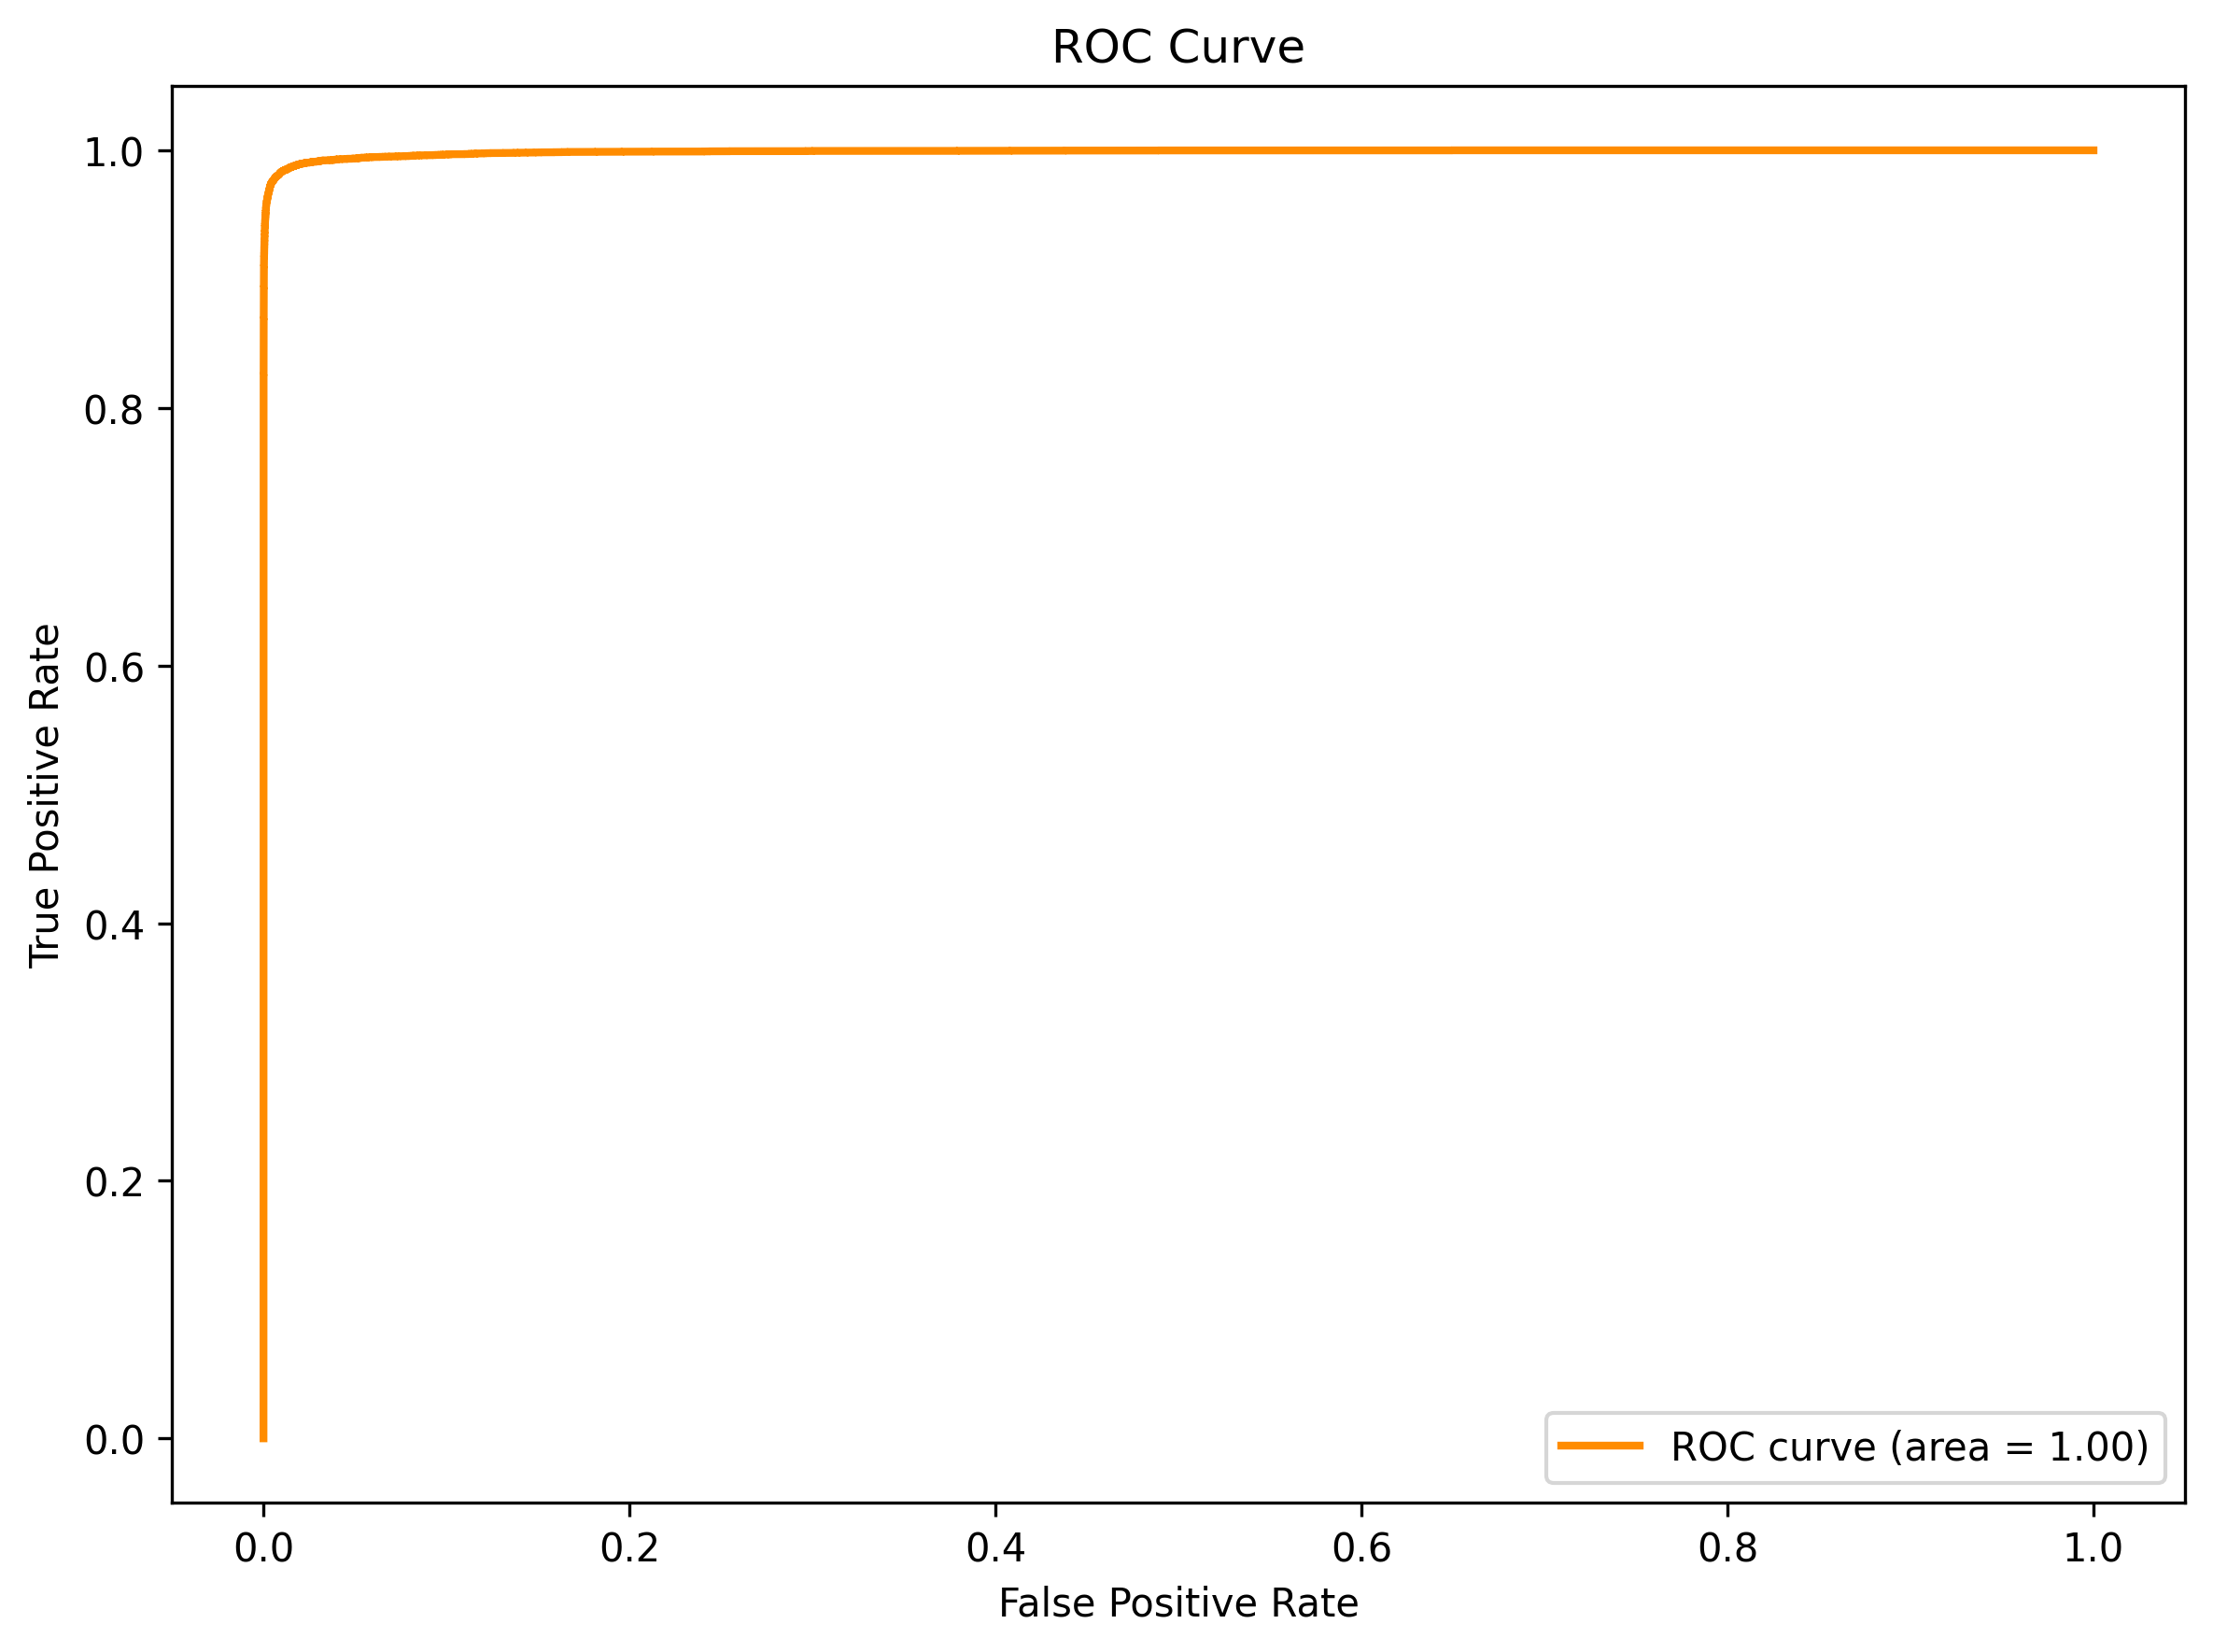

Training metrics: odict_keys(['binary_logloss', 'auc'])
Validation metrics: odict_keys(['binary_logloss', 'auc'])


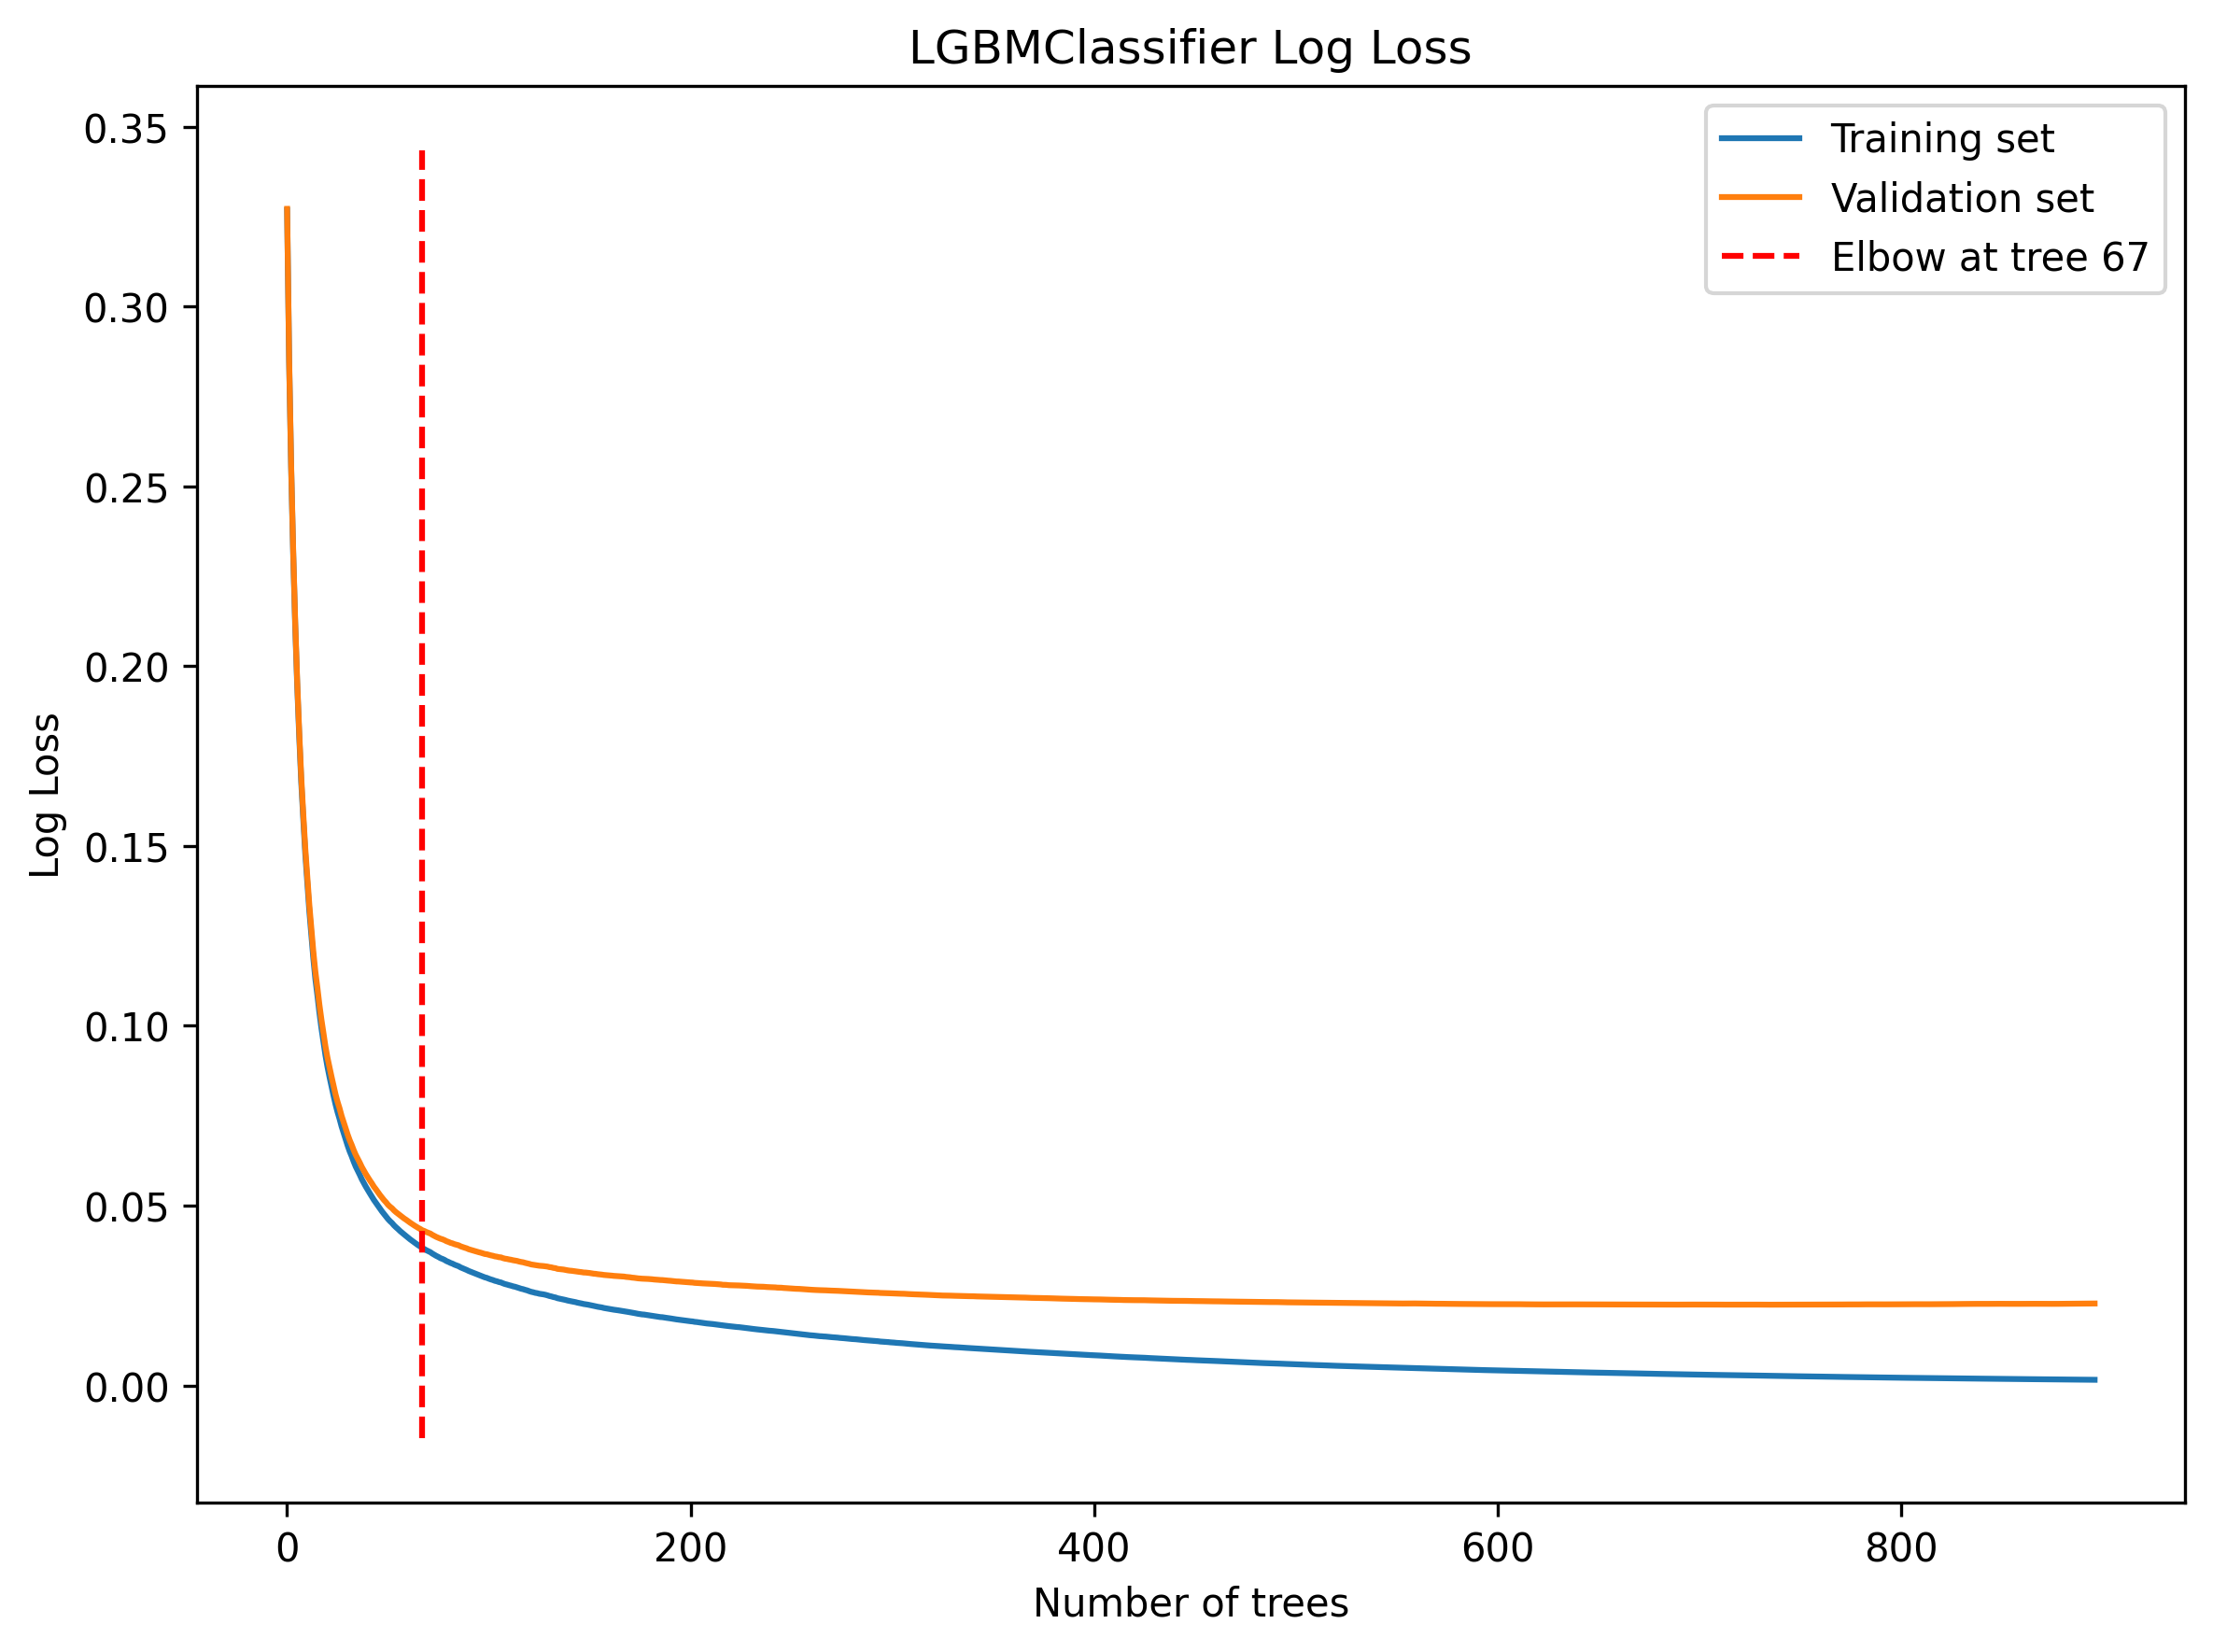

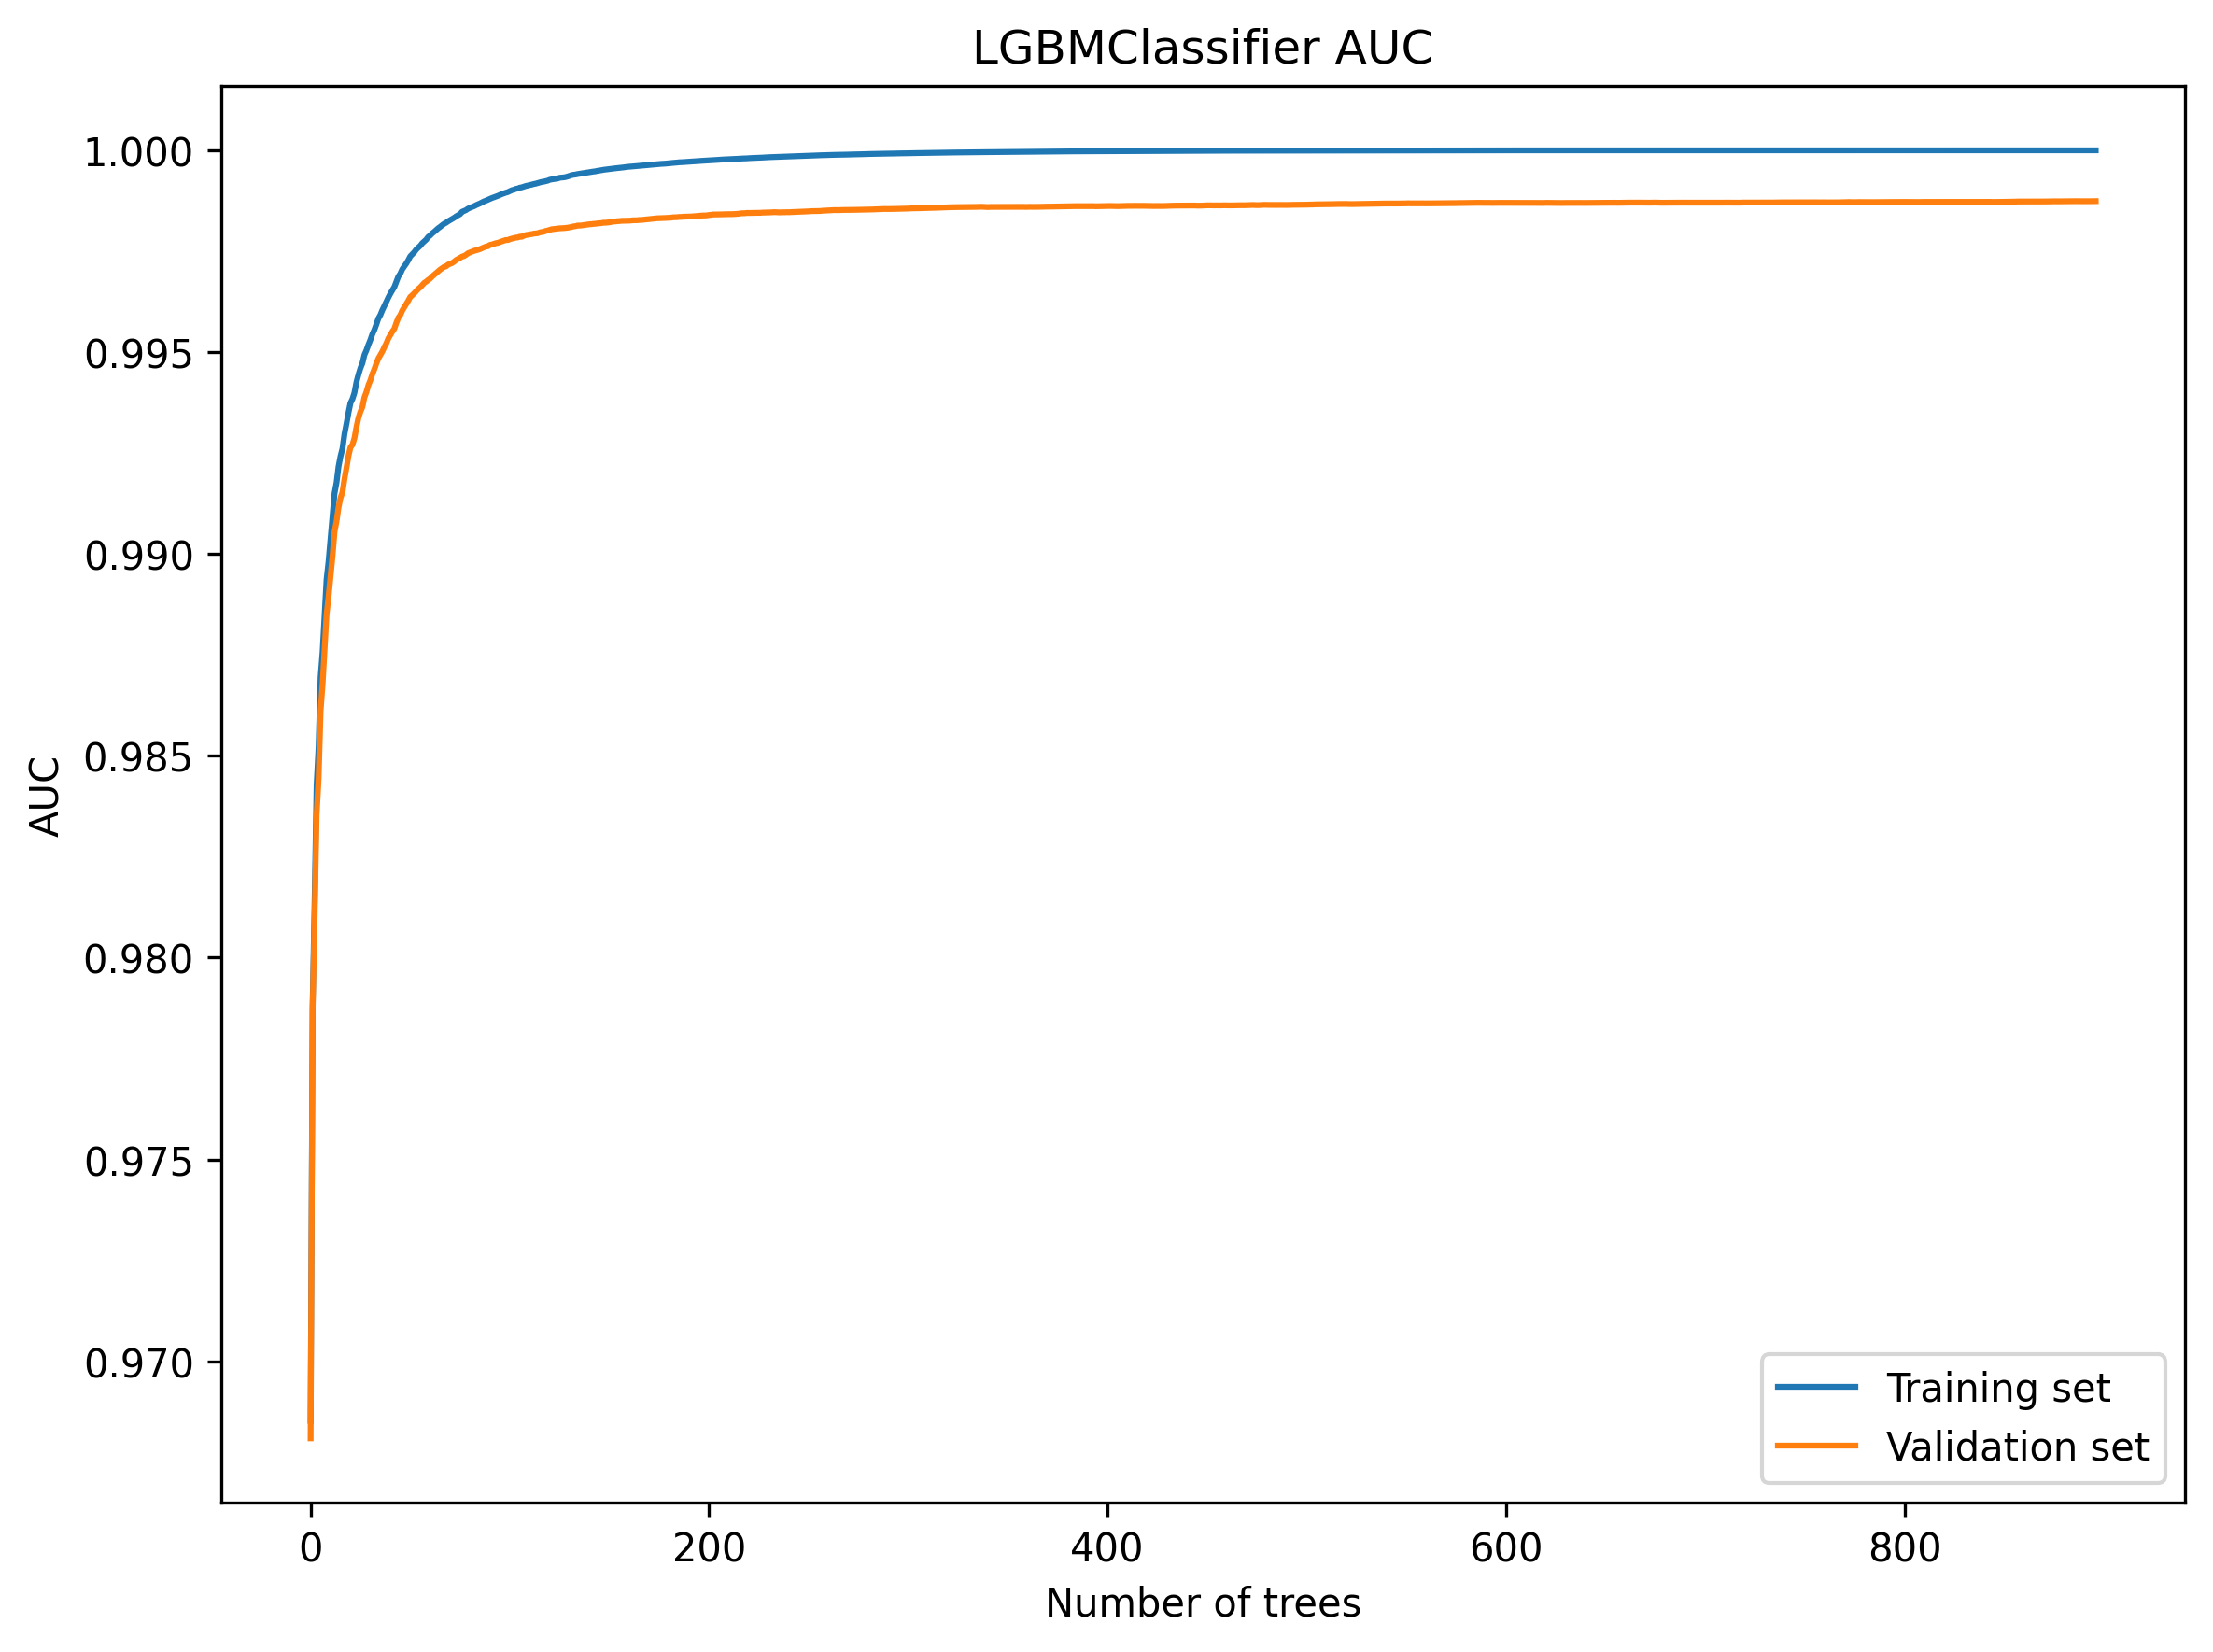

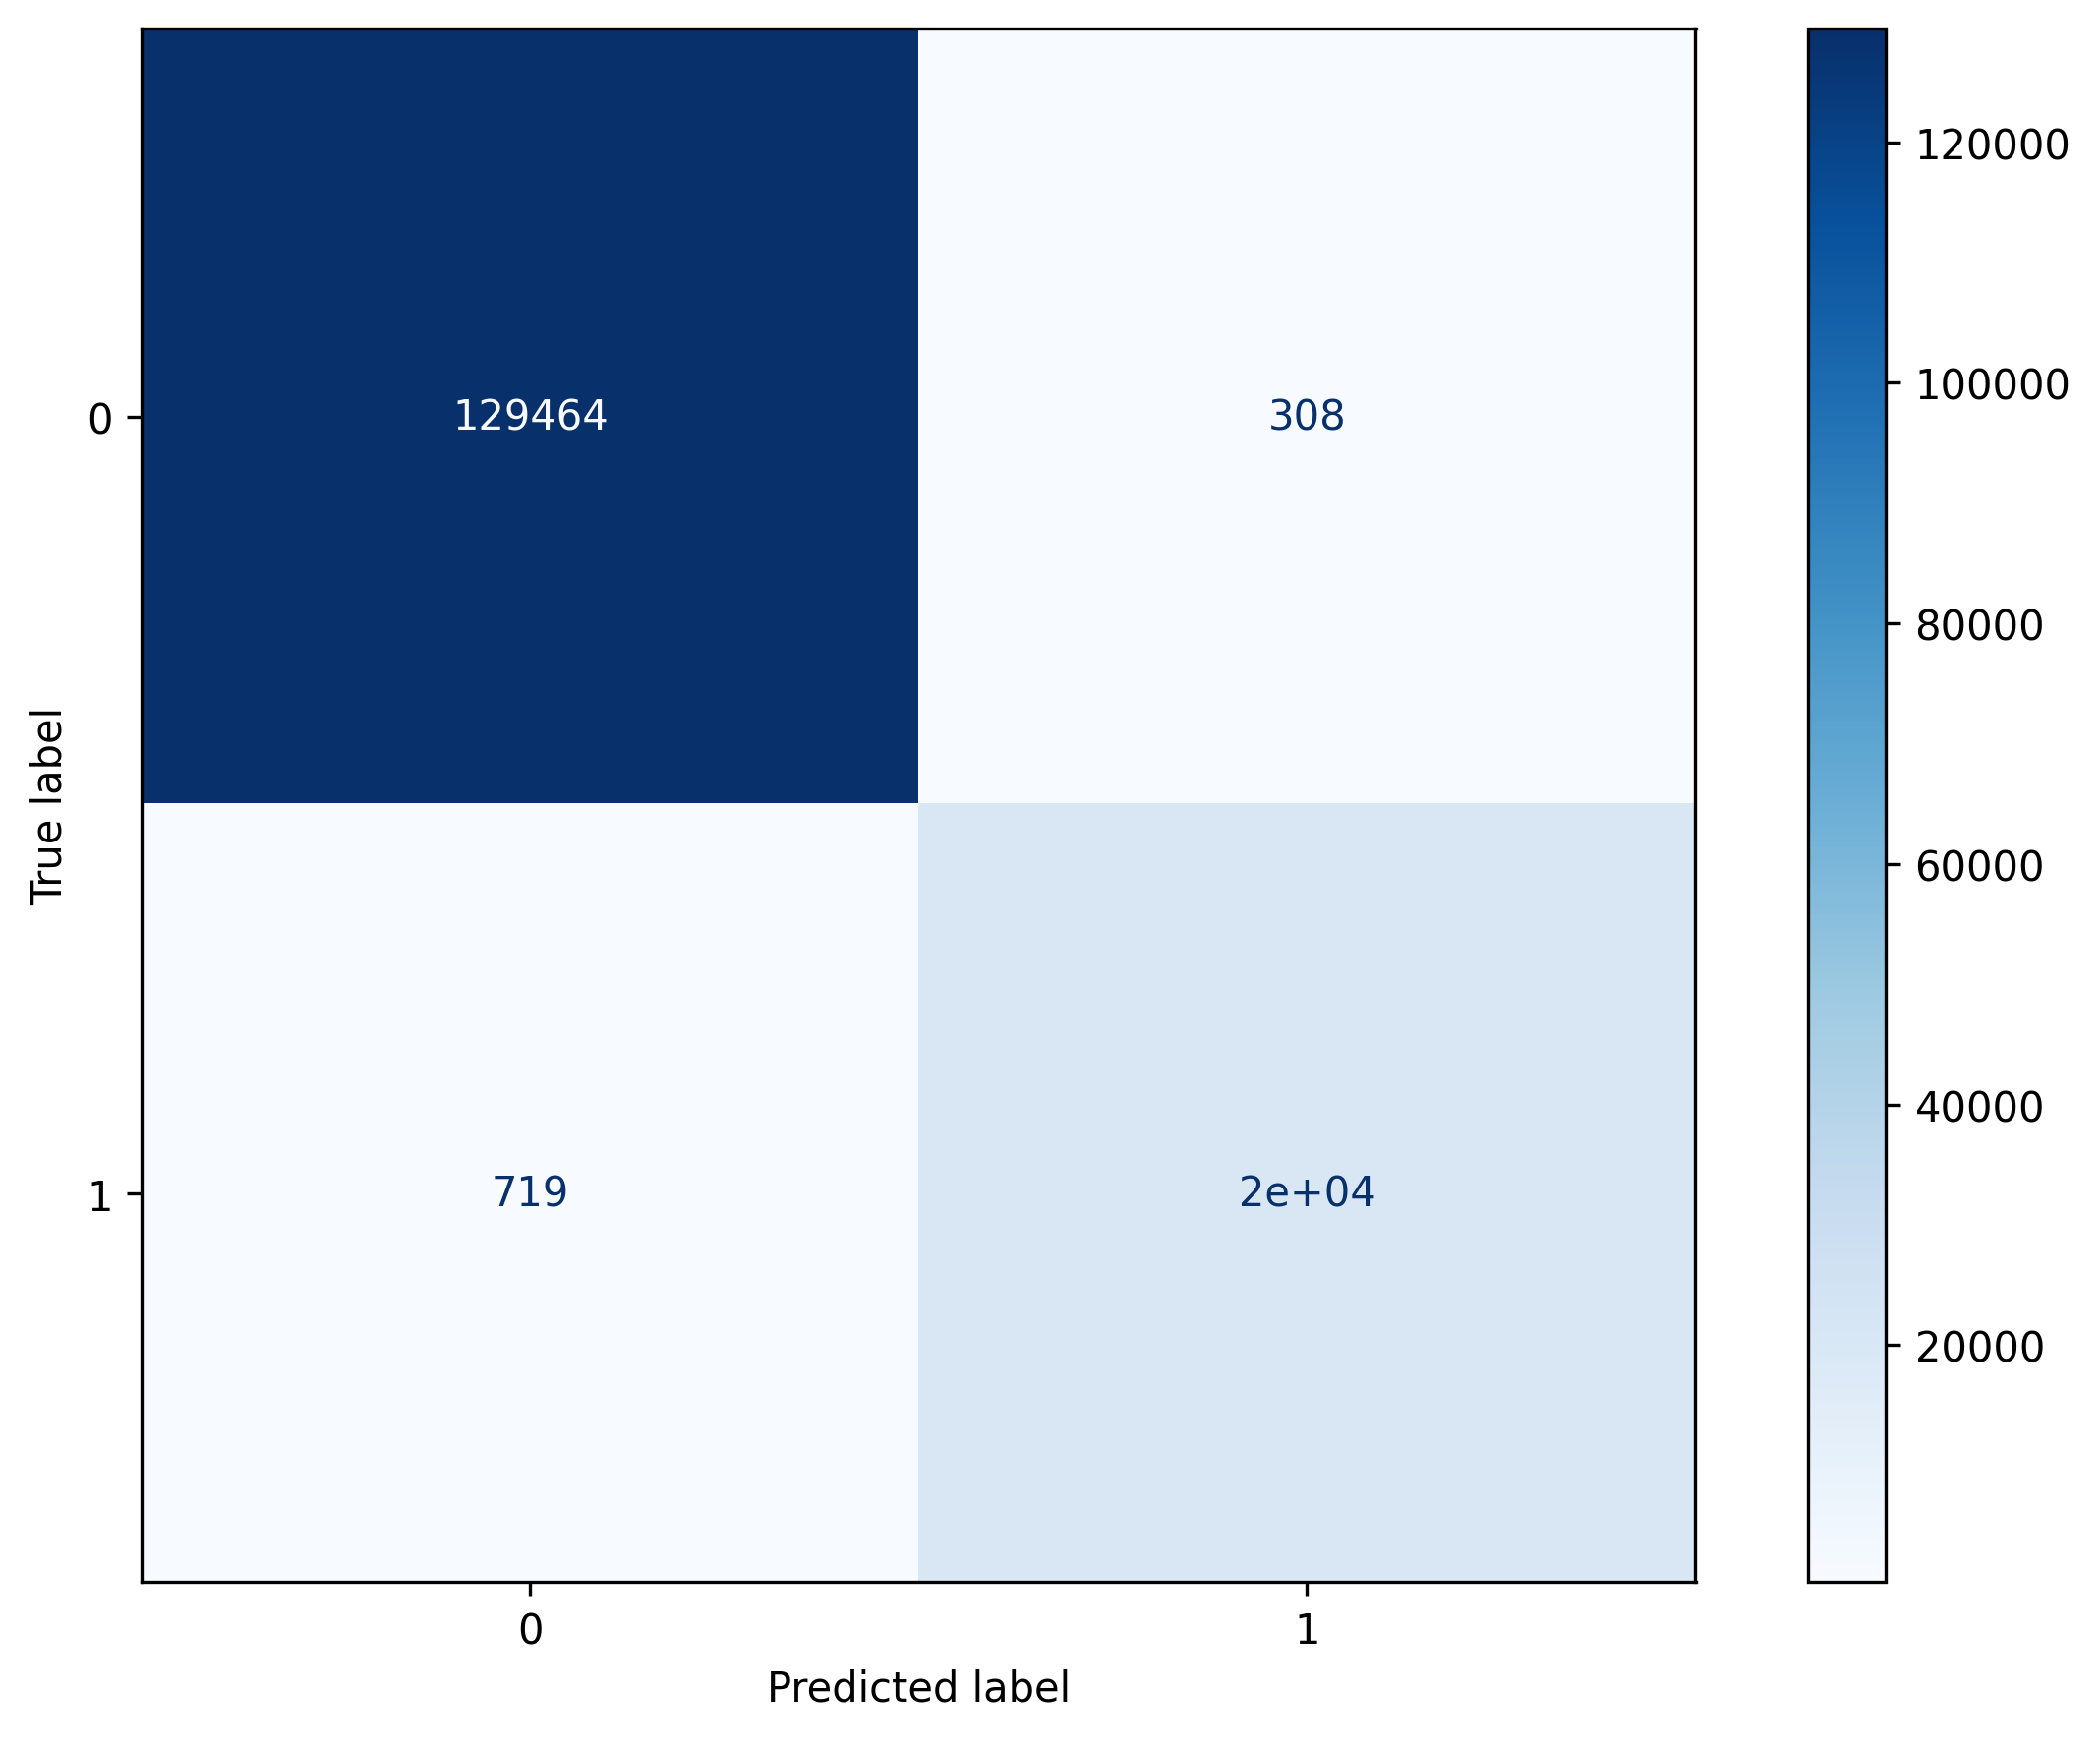

In [51]:
ValidateModel_advanced(X_test, y_test, model)

## LightGBM - Tuning

In [62]:
lgbm_tuning = True

if lgbm_tuning:
    import pandas as pd
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import StratifiedKFold
    from lightgbm import LGBMClassifier  # Updated import

    params = {
        "objective": "binary",  # binary classification
        "boosting_type": "gbdt",  # Gradient Boosting Decision Tree
        "n_estimators": 897, # Number of boosted trees to fit, equivalent to number of boosting iterations
        "num_leaves": 59,
        "max_depth": 17,
        "learning_rate": 0.15,
        "objective": "binary",
        "min_child_samples": 27,
        "colsample_bytree": 0.9,
        "reg_lambda": 0.11,
        "scale_pos_weight": 1.1, # default: 1.0
        "subsample_for_bin": 240000,
        "random_state": 7,
    }

    clf = LGBMClassifier(**params)  # Updated classifier instantiation

    # this is your grid of parameters to search through, every combination will be tried
    grid = {
        "n_estimators": [897, 1350, 1400, 1600],
        "max_depth": [10, 11],
        #"n_estimators": [897],
        #"num_leaves": [59],
        #"max_depth": [20],
        #"learning_rate": [0.11, 0.12, 0.13, 0.2],
        #'scale_pos_weight': [1.7, 1.8, 1.9],
        #"subsample": [0.1],
        #reg_lambda": [0.1],
        #'min_split_gain' : [0.0, 0.1, 0.2]
        #'subsample_for_bin': [215000, 220000, 230000, 240000],
    }

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)
    grid_search = GridSearchCV(
        estimator=clf,
        param_grid=grid,
        #n_jobs=-1,
        cv=cv,
        #scoring='neg_log_loss',
        #scoring='f1',  # You can change this to another scoring method if needed
        scoring=FETA_Score,  # Custom metric
        verbose=3,
        return_train_score=True
    )

    grid_search.fit(X_train, y_train)

    clf = grid_search.best_estimator_

    scores = pd.DataFrame(grid_search.cv_results_)
    col_names = ['mean_train_score', 'mean_test_score']

    scores = pd.DataFrame(grid_search.cv_results_)



Fitting 3 folds for each of 8 candidates, totalling 24 fits
[LightGBM] [Info] Number of positive: 31898, number of negative: 201866
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12388
[LightGBM] [Info] Number of data points in the train set: 233764, number of used features: 135
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.136454 -> initscore=-1.845061
[LightGBM] [Info] Start training from score -1.845061
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV 1/3] END max_depth=10, n_estimators=897;, score=(train=1.000, test=0.972) total time=  13.9s
[LightGBM] [Info] Number of positive: 31898, number of negative: 201867
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021585 seconds.
You can set `force_row_wise=tr

[CV 2/3] END max_depth=10, n_estimators=1600;, score=(train=1.000, test=0.973) total time=  25.3s
[LightGBM] [Info] Number of positive: 31898, number of negative: 201867
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12400
[LightGBM] [Info] Number of data points in the train set: 233765, number of used features: 135
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.136453 -> initscore=-1.845066
[LightGBM] [Info] Start training from score -1.845066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

[LightGBM] [Info] Number of positive: 31898, number of negative: 201867
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12400
[LightGBM] [Info] Number of data points in the train set: 233765, number of used features: 135
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.136453 -> initscore=-1.845066
[LightGBM] [Info] Start training from score -1.845066
[CV 3/3] END max_depth=11, n_estimators=1600;, score=(train=1.000, test=0.972) total time=  26.0s
[LightGBM] [Info] Number of positive: 47847, number of negative: 302800
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.127560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12392
[LightGBM] [Info] Number of data points in the train set: 350647, numbe

   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      13.062451      0.223880         1.107885        0.023007   
1      19.621575      0.184262         1.702284        0.029593   
2      20.115104      0.199528         1.875011        0.058634   
3      23.107118      0.330284         2.064274        0.173513   
4      12.901465      0.534020         1.151362        0.033506   
5      20.761530      1.994624         1.769609        0.006643   
6      21.566413      2.353979         1.757593        0.071808   
7      23.291121      0.463628         2.060971        0.117186   

  param_max_depth param_n_estimators                                   params  \
0              10                897   {'max_depth': 10, 'n_estimators': 897}   
1              10               1350  {'max_depth': 10, 'n_estimators': 1350}   
2              10               1400  {'max_depth': 10, 'n_estimators': 1400}   
3              10               1600  {'max_depth': 10, 'n_estimators': 

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      13.062451      0.223880         1.107885        0.023007   
1      19.621575      0.184262         1.702284        0.029593   
2      20.115104      0.199528         1.875011        0.058634   
3      23.107118      0.330284         2.064274        0.173513   
4      12.901465      0.534020         1.151362        0.033506   
5      20.761530      1.994624         1.769609        0.006643   
6      21.566413      2.353979         1.757593        0.071808   
7      23.291121      0.463628         2.060971        0.117186   

  param_max_depth param_n_estimators                                   params  \
0              10                897   {'max_depth': 10, 'n_estimators': 897}   
1              10               1350  {'max_depth': 10, 'n_estimators': 1350}   
2              10               1400  {'max_depth': 10, 'n_estimators': 1400}   
3              10               1600  {'max_depth': 10, 'n_estimators': 1600}   
4              11                897   {'max_depth': 11, 'n_estimators': 897}   
5              11               1350  {'max_depth': 11, 'n_estimators': 1350}   
6              11               1400  {'max_depth': 11, 'n_estimators': 1400}   
7              11               1600  {'max_depth': 11, 'n_estimators': 1600}   

   split0_test_score  split1_test_score  split2_test_score  mean_test_score  \
0           0.971745           0.972408           0.971394         0.971849   
1           0.972383           0.972633           0.972074         0.972363   
2           0.972512           0.972818           0.972168         0.972500   
3           0.972730           0.972920           0.972081         0.972577   
4           0.971903           0.973181           0.970976         0.972020   
5           0.972588           0.973668           0.971721         0.972659   
6           0.972650           0.973858           0.971558         0.972688   
7           0.973037           0.973926           0.971723         0.972895   

   std_test_score  rank_test_score  split0_train_score  split1_train_score  \
0        0.000421                8                 1.0            0.999984   
1        0.000229                6                 1.0            0.999984   
2        0.000266                5                 1.0            0.999984   
3        0.000359                4                 1.0            0.999984   
4        0.000904                7                 1.0            0.999984   
5        0.000796                3                 1.0            0.999984   
6        0.000939                2                 1.0            0.999984   
7        0.000905                1                 1.0            0.999984   

   split2_train_score  mean_train_score  std_train_score  
0                 1.0          0.999995         0.000007  
1                 1.0          0.999995         0.000007  
2                 1.0          0.999995         0.000007  
3                 1.0          0.999995         0.000007  
4                 1.0          0.999995         0.000007  
5                 1.0          0.999995         0.000007  
6                 1.0          0.999995         0.000007  
7                 1.0          0.999995         0.000007

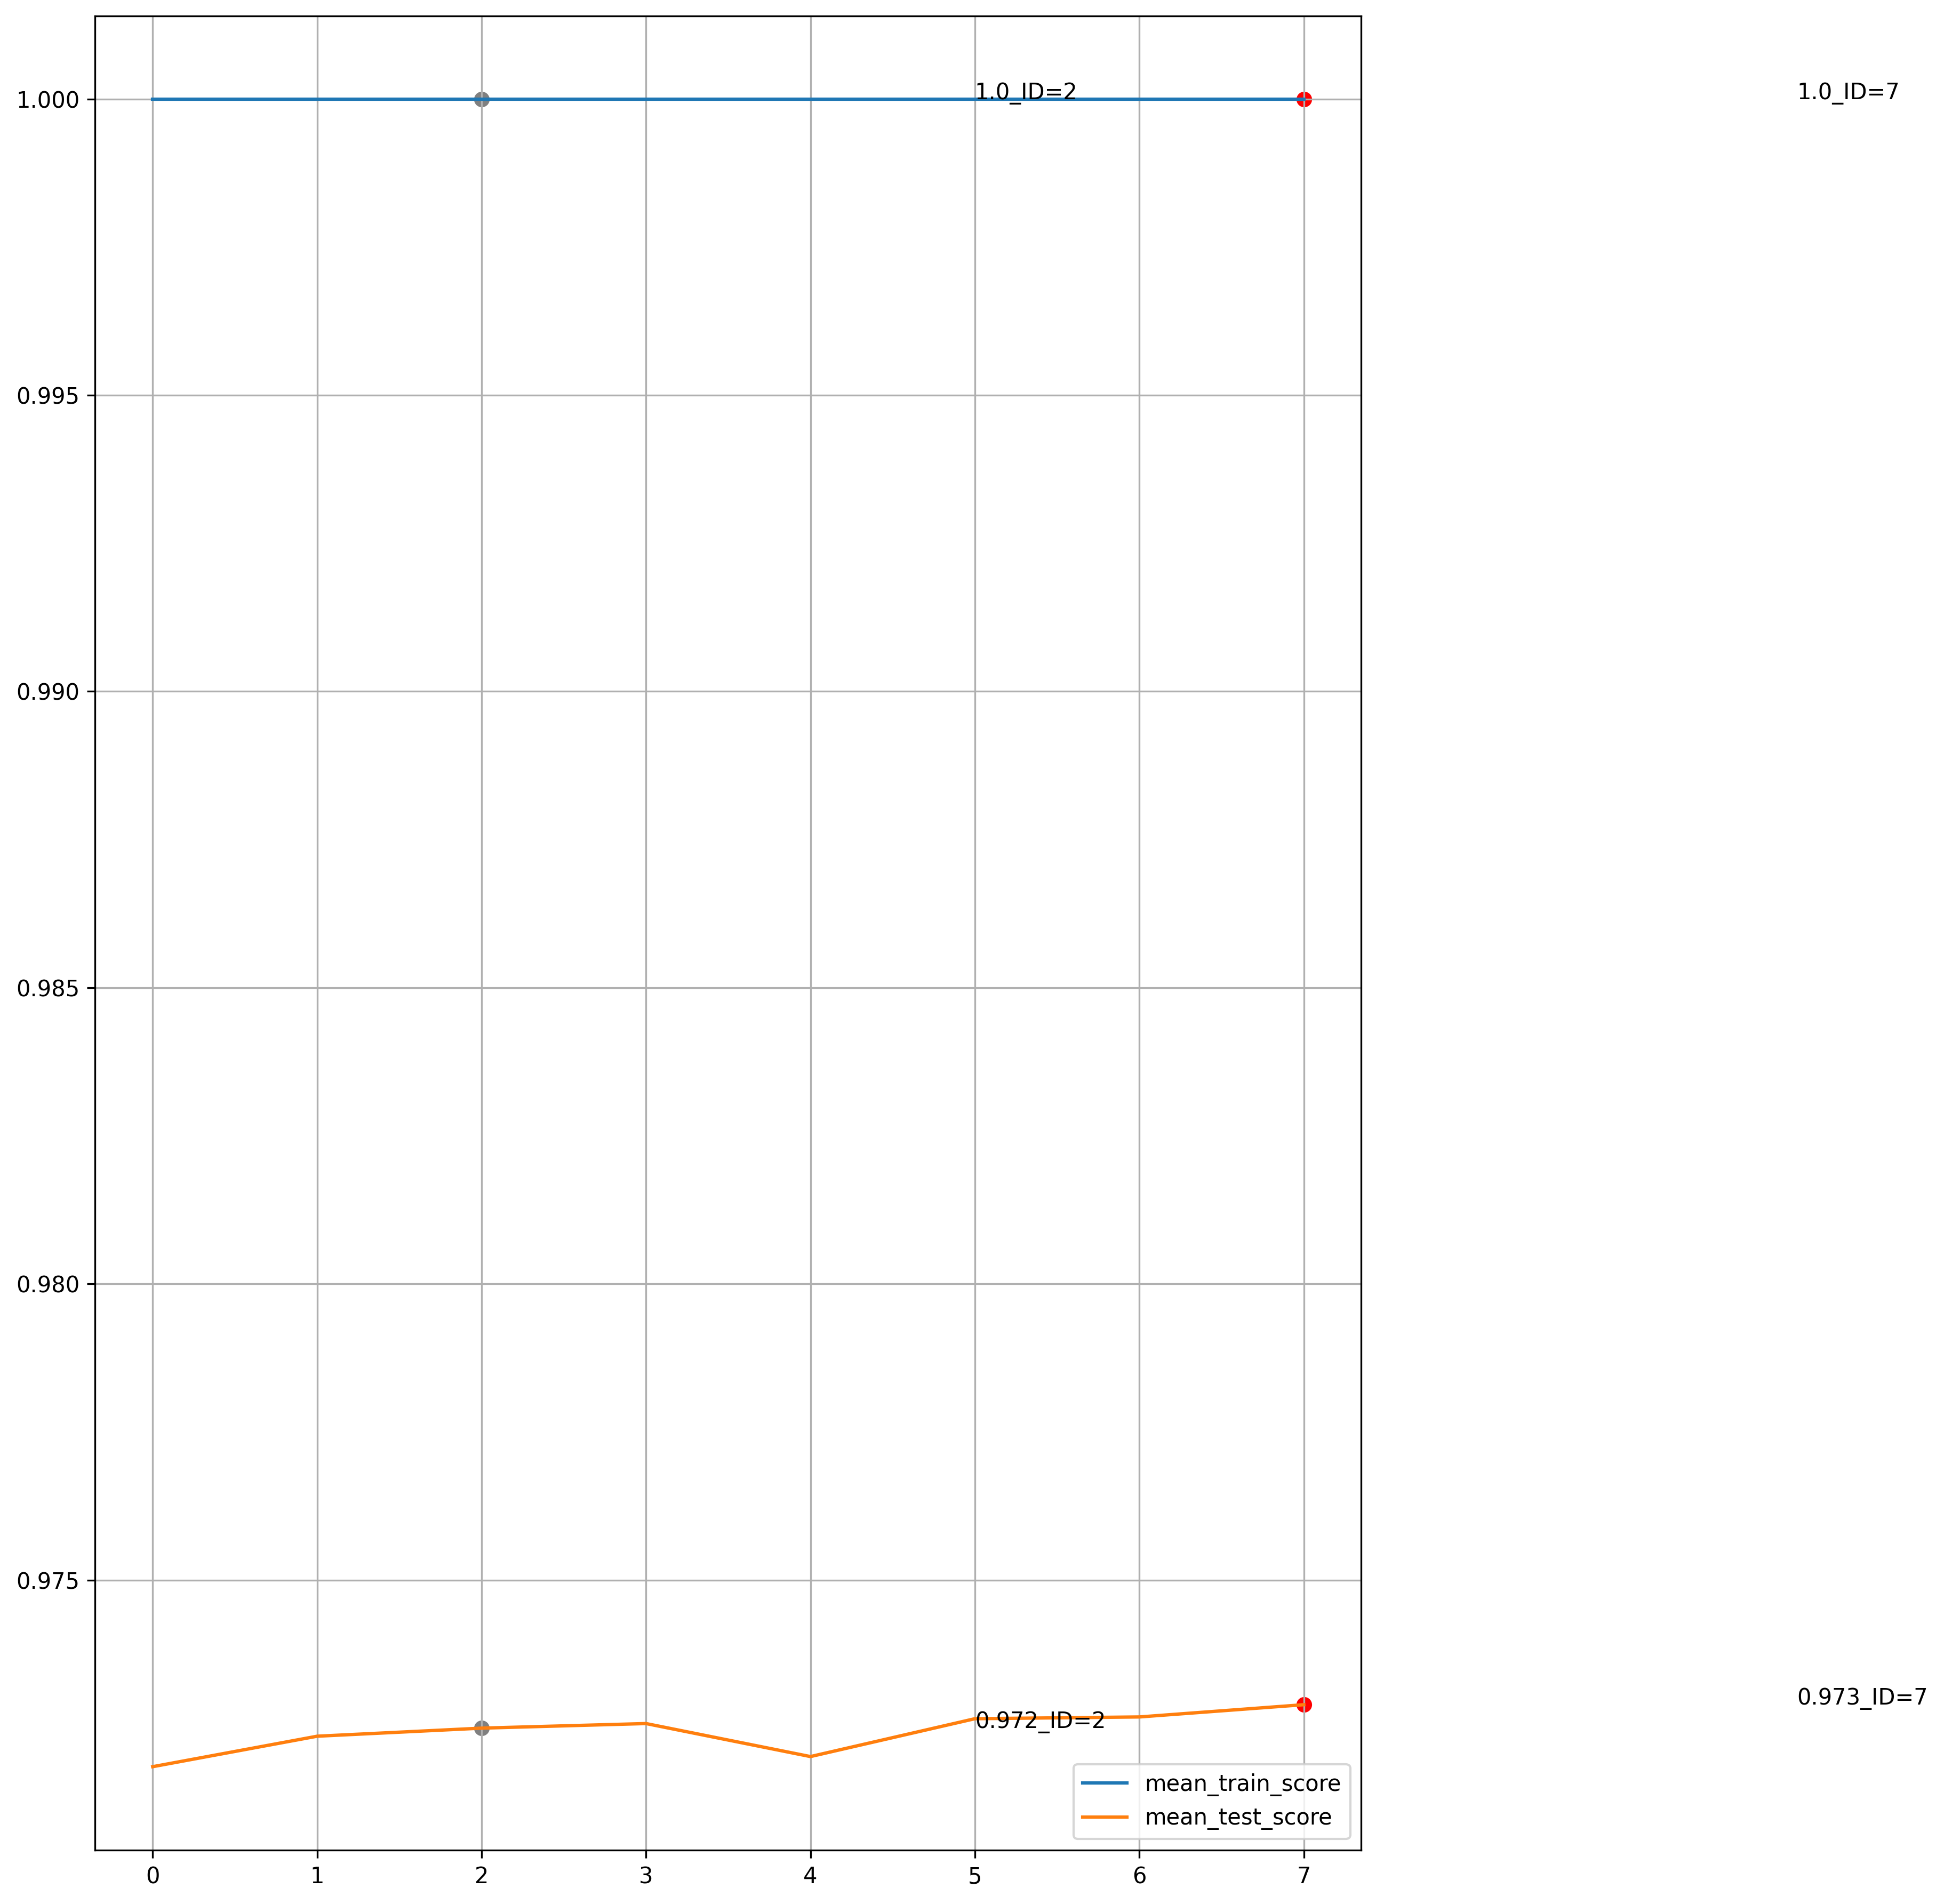

In [63]:
if lgbm_tuning:
    DisplayTuningGraph(scores)

scores